# Visualization of Russian Medical Statistics: Public Health Status

**Project Description**<br>
Currently, data on the health status of the Russian population is presented in the form of a large number of disparate tables published by [Federal State Statistics Service](https://eng.rosstat.gov.ru/) every two years. This method of presenting information is extremely challenging for consultation and analysis by most users — medical officials, healthcare management leaders, experts, and interested citizens. Data visualization can significantly improve the quality of healthcare management decisions. It is also an important social task — data on public health should be accessible and open to discussion.

**Goal**<br>
To transform disparate statistical tables into a simple and clear dashboards with the potential for future publication on the website http://WebMedStat.ru

**Data**<br>
- **Sourse:** [Federal State Statistics Service (Rosstat)](https://rosstat.gov.ru/folder/210/document/13218)
- **Description:** Data from analytical reports by Rosstat titled *"Healthcare in Russia"* from 2001 to 2023 (cover 1991-2022 period). The data was obtained by parsing the Rosstat website. The data is publicly available and can be used in any commercial and non-commercial projects. The data comes in various formats and is not always consistent with each other.
- [Parsed Data](https://disk.yandex.ru/d/OsAbA6Bhm1S3jQ)

In [1]:
# import libraries
import datetime as dt
import os
import re
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# display settings
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', None)
pd.set_option("display.precision", 4)

sns.set_style("darkgrid")

%matplotlib inline

In [3]:
# set data path
PATH_data = os.path.join('..', 'data/datasets')

# list of all subfolder names
years = sorted([f.name for f in os.scandir(PATH_data) if f.is_dir() and 'reg' not in f.name])
print('Years of analytical reports')
print(years)

Years of analytical reports
['2001', '2005', '2007', '2009', '2011', '2013', '2015', '2017', '2019', '2021', '2023']


## Morbidity by Major Classes, Groups, and Specific Diseases
Let's begin with the first general topic. Steps:
- Gather Data: Collect data from various years into a single dataframe.
- Include Children's Health Data: Incorporate health data for children under 1 year, 0 to 14 years, and 15 to 17 years into the dataframe.

The classes of diseases in the tables are provided according to the ICD-10 classification. We will create a dictionary where the key is the class number, and the value is the class name.

In [4]:
# dictionary for the ICD-10 classification
icd_10 = {
    '1': 'Certain infectious and parasitic diseases',
    '1.1': 'Intestinal infections',
    '2': 'Neoplasms',
    '3': 'Diseases of the blood, blood-forming organs, and certain disorders involving the immune mechanism',
    '3.1': 'Anemias',
    '4': 'Endocrine, nutritional, and metabolic diseases',
    '4.1': 'Diabetes mellitus',
    '4.2': 'Obesity',
    '4.3': 'Rickets',
    '5': 'Mental and behavioral disorders',
    '6': 'Diseases of the nervous system',
    '6.1': 'Cerebral palsy in children',
    '6.2': 'Epilepsy, status epilepticus',
    '7': 'Diseases of the eye and adnexa',
    '8': 'Diseases of the ear and mastoid process',
    '8.1': 'Chronic otitis',
    '9': 'Diseases of the circulatory system',
    '9.1,9.2': 'Hypertensive and ischemic heart diseases',
    '9.1': 'Hypertensive diseases',
    '9.2': 'Ischemic heart disease',
    '9.2.1': 'Angina pectoris',
    '9.2.2': 'Acute myocardial infarction',
    '9.3': 'Cerebrovascular diseases',
    '10': 'Diseases of the respiratory system',
    '11': 'Diseases of the digestive system',
    '11.1': 'Peptic / duodenal ulcer',
    '12': 'Diseases of the skin and subcutaneous tissue',
    '12.1': 'Contact dermatitis',
    '13': 'Diseases of the musculoskeletal system and connective tissue',
    '14': 'Diseases of the genitourinary system',
    '14.1': 'Kidney infections',
    '15': 'Pregnancy, childbirth, and the puerperium',
    '16': 'Certain conditions originating in the perinatal period',
    '17': 'Congenital malformations, deformations, and chromosomal abnormalities',
    '19': 'Injuries, poisoning, and certain other consequences of external causes',
    '22': 'COVID-19',
    'care for sick': 'Leave to care for the sick',
    'maternity leave': 'Maternity leave'
}

In [5]:
icd_10_short = {
    '1': 'Infections',
    '1.1': 'Intestinal Infections',
    '2': 'Cancers',
    '3': 'Blood & Immune Diseases',
    '3.1': 'Anemias',
    '4': 'Endocrine / Metabolic Diseases',
    '4.1': 'Diabetes',
    '4.2': 'Obesity',
    '4.3': 'Rickets',
    '5': 'Mental Disorders',
    '6': 'Nervous System Diseases',
    '6.1': 'Cerebral Palsy',
    '6.2': 'Epilepsy',
    '7': 'Eye Diseases',
    '8': 'Ear Diseases',
    '8.1': 'Chronic Otitis',    
    '9': 'Cardiovascular diseases',
    '9.1,9.2': 'Hypertensive / Ischemic heart diseases',
    '9.1': 'Hypertension',
    '9.2': 'Ischemic Heart Disease',
    '9.2.1': 'Stenocardia',
    '9.2.2': 'Heart Attack',
    '9.3': 'Stroke',
    '10': 'Respiratory Diseases',
    '11': 'Digestive Diseases',
    '11.1': 'Stomach / Duodenal Ulcer',
    '12': 'Skin Diseases',
    '12.1': 'Dermatitis',
    '13': 'Musculoskeletal Diseases',
    '14': 'Genitourinary Diseases',
    '14.1': 'Kidney Infections',
    '15': 'Pregnancy & Childbirth',
    '16': 'Perinatal Conditions',
    '17': 'Congenital Disorders',
    '19': 'Injuries / Poisoning',
    '22': 'COVID-19',
    'care for sick': 'Sick Leave',
    'maternity leave': 'Maternity Leave'
}

It was observed that the names of disease classes in tables from different years might appear in a different order, slightly differ, or contain special characters, Latin letters, etc. To simplify the work, we will replace the names with class numbers using a dictionary with keywords.

In [6]:
# dictionary for coding disease class names into numbers
class_dict = {'паразит': '1', 'кишечн': '1.1',
             'новообр': '2',
             'крови': '3', 'анеми': '3.1',
             'эндокрин': '4', 'сахар': '4.1', 'ожир': '4.2', 'рахит': '4.3',
             'психич': '5',
             'нервн': '6', 'паралич': '6.1', 'эпилепс': '6.2',
             'глаз': '7',
             'уха': '8', 'отит': '8.1',
             'кровообр': '9', 'гипертон': '9.1,9.2', 'давлен': '9.1', 'ишемич': '9.2',
             'стенокард': '9.2.1', 'инфаркт': '9.2.2', 'цереброваск': '9.3',
             'дыхан': '10',
             'пищеварен': '11', 'язва': '11.1',
             'кожи': '12', 'дерматит': '12.1',
             'костно': '13',
             'мочепол': '14', 'почек': '14.1',
             'беремен': '15', 'перинат': '16', 'аномалии': '17',
             'травмы': '19',
             'VID-19': '22',
             'все': 'total',
             'всего': 'total'}

The tables have different formats in different years. In some cases, the incidence per 100,000 people is given below the absolute values, while in others, it's to the right of them. Let's write functions to read files of different types.

In [7]:
def read_wide_table(year, file_name='2_1.csv', header=[3]):
    
    """
    Input: year, file_name, and header - the row from
    which to take the column names.
    FUnction reads the file, formats the names of disease classes, and replaces them with numbers. 
    Output: DataFrame with disease class numbers, incidence by year, and incidence type 
    (total, per 100k, first-time, first-time per 100k)
    """

    # read csv file
    df = pd.read_csv(os.path.join(*[PATH_data], year, file_name), header=header, encoding='utf-8')
    df = (df.rename(columns={df.columns[0]: 'disease_class'})
            .dropna(subset=df.columns[1:], how='all')
            .dropna(subset='disease_class'))
    
    # format disease names
    table = str.maketrans('acexopcyx', 'асехорсух')
    df['disease_class'] = (df['disease_class']
                           .str.lower()
                           .str.translate(table)
                           .str.replace('- ', ''))
    
    # change disease class names into numbers
    for k,v in class_dict.items():
        df['disease_class'] = np.where(df['disease_class'].str.contains(k, case=False), v, df['disease_class'])
    
    # identify the split point where the second table starts
    split_point = int((df.shape[1]-1)/2) 
        
    # split the dataframe into separate tabels
    df_total = df.iloc[:, 0:(-split_point)]
    df_total['type'] = 'total_abs'
    
    if df.columns.str.contains(df.columns[1]+'.2').any():
        df_total_per100k = df_total.drop(columns=df_total.columns[1:(int(split_point/2)+1)])
        df_total = df_total.drop(columns=df_total.columns[(int(split_point/2)+1):-1])
        # add the suffixes to the 'type' column
        df_total_per100k['type'] = 'total_per100k'
        df_total_per100k.columns = df_total.columns
      
        df_first = df.drop(columns=df.columns[1:(split_point+1)])
        df_first['type'] = 'first_abs'
        df_first_per100k = df_first.drop(columns=df_first.columns[1:(int(split_point/2)+1)])
        df_first = df_first.drop(columns=df_first.columns[(int(split_point/2)+1):-1])
        df_first.columns = df_total.columns
        df_first_per100k.columns = df_total.columns
        
        # add the suffixes to the 'type' column
        df_first_per100k['type'] = 'first_per100k'
    
        # concatenate tabels
        df = pd.concat([df_total, df_total_per100k, df_first, df_first_per100k], axis=0).reset_index(drop=True)

    else:
        df_total_per100k = df.drop(columns=df_total.columns[1:(split_point+1)])
        df_total_per100k['type'] = 'total_per100k'
        df_total_per100k.columns = df_total.columns
    
        # concatenate tabels
        df = pd.concat([df_total, df_total_per100k], axis=0).reset_index(drop=True)
    
    return df

In [8]:
def read_table(year, file_name='2_1.csv', file_name2023='2_1-2_13.xlsx', sheet_name='2.1', header=[2]):
    
    """
    Input: year, file_name, file_name2023, sheet_name, and header 
    - the row from which to take the column names.
    FUnction reads the file, formats the names of disease classes, 
    and replaces them with numbers. 
    Output: DataFrame with disease class numbers, incidence by year, 
    and incidence type (total, per 100k, first-time, first-time per 100k)
    """

    # read csv file
    if year == '2023':
        df = pd.read_excel(os.path.join(*[PATH_data], year, file_name2023), sheet_name=sheet_name, header=header)
        df.columns = df.columns.astype(str)
    else:
        df = pd.read_csv(os.path.join(*[PATH_data], year, file_name), header=header, encoding='utf-8')
    
    df = (df.drop(0)
            .rename(columns={df.columns[0]: 'disease_class'})
            .dropna(subset=df.columns[1:], how='all')
            .dropna(subset='disease_class'))

    # format disease names
    table = str.maketrans('acexopcyx', 'асехорсух')
    df['disease_class'] = (df['disease_class']
                           .str.lower()
                           .str.translate(table)
                           .str.replace('- ', ''))

    # change disease class names into numbers
    for k,v in class_dict.items():
        df['disease_class'] = np.where(df['disease_class'].str.contains(k, case=False), v, df['disease_class'])

    # drop rows containing "из них" in disease_class
    df = df[~df['disease_class'].str.contains("из", na=False)].reset_index(drop=True)
    
    # identify the split points where the second table starts
    rep = df[df['disease_class'].str.contains("total", na=False)]
    if len(rep) > 1:
        split_point_h = rep.index[1]
    else:
        split_point_h = len(df)
    
    # Create the new suffixes based on the split point
    suffixes = ['_abs' if i < split_point_h else '_per100k' for i in df.index]  
    
    if df.columns.str.contains(df.columns[1]+'.1').any():
        split_point_v = int((df.shape[1]-1)/2)
    
        # split the dataframe into two parts
        df_total = df.iloc[:, 0:-split_point_v]
        df_total['type'] = 'total'
    
        df_first = df.iloc[:, [0]+list(range(-split_point_v, 0))]
        df_first['type'] = 'first'
        df_first.columns = df_total.columns

        # add the suffixes to the 'type' column
        df_total['type'] = df_total['type'] + suffixes
        df_first['type'] = df_first['type'] + suffixes

        # concatenate tabels
        df = pd.concat([df_total, df_first], axis=0).reset_index(drop=True)
    
    else:
        df['type'] = 'total'
        # Add the suffixes to the 'type' column
        df['type'] = df['type'] + suffixes

    return df

### Entire Population

#### Data Load and Pre-Processing

Let's load all the tables into a dictionary of DataFrames, where the keys will be the reporting years.

In [9]:
# create dict of dataframes
data = {}

data['1990'] = read_table('2001', file_name='2_1_1990-1998.csv')
print('\033[1m1990\033[0m')
print('___________________')
display(data['1990'].head())

for year in years:
    print('\033[1m'+year+'\033[0m')
    print('___________________')
    
    if year == '2001':
        df = read_wide_table(year)
    else:
        df = read_table(year)

    display(df.head())

    # add dataframe to the dict of dataframes
    data[year] = df

1990
___________________


,disease_class,1990,1995,1996,1997,1998,type
0,total,158298.6,170179.2,167206.4,172252.6,174729.7,total_abs
1,1,7610.4,9268.8,8843.9,8720.4,9021.1,total_abs
2,2,3246.0,3735.1,3921.4,3863.1,4078.6,total_abs
3,4,2930.4,3974.9,4219.9,4487.4,4874.0,total_abs
4,4.1,1744.3,1904.4,1915.6,1951.4,2010.1,total_abs


2001
___________________


,disease_class,1999,2000,type
0,total,184495.6,191304.4,total_abs
1,1,9044.6,8984.8,total_abs
2,2,4284.4,4455.6,total_abs
3,3,1180.8,1278.5,total_abs
4,3.1,1008.7,1102.7,total_abs


2005
___________________


,disease_class,2000,2001,2002,2003,2004,type
0,total,191304.4,192404.8,198120.4,201075.4,204198.5,total_abs
1,1,8984.8,8894.3,8497.7,7942.0,8000.8,total_abs
2,2,4455.6,4548.0,4691.4,4758.7,4961.1,total_abs
3,3,1278.5,1343.2,1568.3,1514.3,1541.2,total_abs
4,3.1,1102.7,1154.1,1388.7,1337.8,1363.9,total_abs


2007
___________________


,disease_class,2000,2005,2006,type
0,total,191304.4,207763.9,216203.2,total_abs
1,1,8984.8,7598.6,7621.3,total_abs
2,2,4455.6,5037.9,5121.3,total_abs
3,3,1278.5,1558.3,1761.4,total_abs
4,3.1,1102.7,1366.6,1559.5,total_abs


2009
___________________


,disease_class,2000,2007,2008,type
0,total,191304.4,219459.7,221665.0,total_abs
1,1,8984.8,7571.5,7419.3,total_abs
2,2,4455.6,5252.7,5467.2,total_abs
3,3,1278.5,1808.8,1793.9,total_abs
4,3.1,1102.7,1598.3,1594.2,total_abs


2011
___________________


,disease_class,2000,2009,2010,type
0,total,191304.4,228074.6,226159.6,total_abs
1,1,8984.8,7181.6,6897.9,total_abs
2,2,4455.6,5724.8,5847.0,total_abs
3,3,1278.5,1791.2,1741.5,total_abs
4,3.1,1102.7,1586.7,1570.5,total_abs


2013
___________________


,disease_class,2010,2011,2012,type
0,total,"226159,6","229155,4","229717,1",total_abs
1,1,"6897,9","6878,3","6818,5",total_abs
2,2,"5847,0","5968,9","6147,5",total_abs
3,3,"1741,5","1726,4","1731,9",total_abs
4,3.1,"1570,5","1536,9","1551,4",total_abs


2015
___________________


,disease_class,2010,2013,2014,type
0,total,"226159,6","231134,9","235008,1",total_abs
1,1,"6897,9","6563,8","6696,4",total_abs
2,2,"5847,0","6236,9","6472,5",total_abs
3,3,"1741,5","1715,5","1827,2",total_abs
4,3.1,"1570,5","1529,2","1585,9",total_abs


2017
___________________


,disease_class,2010,2015,2016,type
0,total,"226159,6","234331,7","237067,7",total_abs
1,1,"6897,9","6480,0","6540,1",total_abs
2,2,"5847,0","6616,4","6927,6",total_abs
3,3,"1741,5","1825,5","1975,5",total_abs
4,3.1,"1570,5","1631,8","1637,8",total_abs


2019
___________________


,disease_class,2010,2017,2018,type
0,total,"226159,6","237494,3","240046,3",total_abs
1,1,"6897,9","6439,5","6403,7",total_abs
2,2,"5847,0","7189,3","7355,1",total_abs
3,3,"1741,5","1858,4","1837,2",total_abs
4,3.1,"1570,5","1649,6","1617,7",total_abs


2021
___________________


,disease_class,2010,2019,2020,type
0,total,"226 159,6","242 014,1","229 091,3",total_abs
1,1,"6 897,9","6 341,9","5 217,7",total_abs
2,2,"5 847,0","7 528,9","7 132,3",total_abs
3,3,"1 741,5","1 849,0","1 615,2",total_abs
4,3.1,"1 570,5","1 620,0","1 406,8",total_abs


2023
___________________


,disease_class,2020,2021,2022,type
0,total,229091.3,"245 149,0","254 022,5",total_abs
1,1,"5 217,7","5 358,0","5 550,1",total_abs
2,2,"7 132,3","7 295,9","7 616,5",total_abs
3,3,"1 615,2","1 686,5","1 730,7",total_abs
4,3.1,"1 406,8","1 446,1","1 507,4",total_abs


Let's combine the data into a single DataFrame, using data primarily from the more recent reports for any overlapping years. 

In [10]:
# merge data
df_adult = (data['2023']
          .merge(data['2021'].drop(columns=['2020', '2010']), how='outer', on=['disease_class', 'type'])
          .merge(data['2019'].drop(columns=['2010']), how='outer', on=['disease_class', 'type'])
          .merge(data['2017'].drop(columns=['2010']), how='outer', on=['disease_class', 'type'])
          .merge(data['2015'].drop(columns=['2010']), how='outer', on=['disease_class', 'type'])
          .merge(data['2013'].drop(columns=['2010']), how='outer', on=['disease_class', 'type'])
          .merge(data['2011'].drop(columns=['2000']), how='outer', on=['disease_class', 'type'])
          .merge(data['2009'].drop(columns=['2000']), how='outer', on=['disease_class', 'type'])
          .merge(data['2007'].drop(columns=['2000']), how='outer', on=['disease_class', 'type'])
          .merge(data['2005'].drop(columns=['2000']), how='outer', on=['disease_class', 'type'])
          .merge(data['2001'], how='outer', on=['disease_class', 'type'])
          .merge(data['1990'], how='outer', on=['disease_class', 'type'])
         )

# new order of columns
new_order = ['disease_class', 'type', 
             '1990', '1995', '1996',
             '1997', '1998', '1999',
             '2000', '2001', '2002',
             '2003', '2004', '2005',
             '2006', '2007', '2008',
             '2009', '2010', '2011',
             '2012', '2013', '2014',
             '2015', '2016', '2017',
             '2018', '2019', '2020',
             '2021', '2022']

# reorder the DataFrame
df_adult = df_adult[new_order]

In [11]:
df_adult.iloc[0:50, :]

,disease_class,type,1990,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,total,total_abs,158298.6,170179.2,167206.4,172252.6,174729.7,184495.6,191304.4,192404.8,198120.4,201075.4,204198.5,207763.9,216203.2,219459.7,221665.0,228074.6,226159.6,"229155,4","229717,1","231134,9","235008,1","234331,7","237067,7","237494,3","240046,3","242 014,1",229091.3,"245 149,0","254 022,5"
1,1,total_abs,7610.4,9268.8,8843.9,8720.4,9021.1,9044.6,8984.8,8894.3,8497.7,7942.0,8000.8,7598.6,7621.3,7571.5,7419.3,7181.6,6897.9,"6878,3","6818,5","6563,8","6696,4","6480,0","6540,1","6439,5","6403,7","6 341,9","5 217,7","5 358,0","5 550,1"
2,2,total_abs,3246.0,3735.1,3921.4,3863.1,4078.6,4284.4,4455.6,4548.0,4691.4,4758.7,4961.1,5037.9,5121.3,5252.7,5467.2,5724.8,5847.0,"5968,9","6147,5","6236,9","6472,5","6616,4","6927,6","7189,3","7355,1","7 528,9","7 132,3","7 295,9","7 616,5"
3,3,total_abs,469.2,872.3,933.1,992.3,1060.4,1180.8,1278.5,1343.2,1568.3,1514.3,1541.2,1558.3,1761.4,1808.8,1793.9,1791.2,1741.5,"1726,4","1731,9","1715,5","1827,2","1825,5","1975,5","1858,4","1837,2","1 849,0","1 615,2","1 686,5","1 730,7"
4,3.1,total_abs,...,707.4,777.5,835.7,900.4,1008.7,1102.7,1154.1,1388.7,1337.8,1363.9,1366.6,1559.5,1598.3,1594.2,1586.7,1570.5,"1536,9","1551,4","1529,2","1585,9","1631,8","1637,8","1649,6","1617,7","1 620,0","1 406,8","1 446,1","1 507,4"
5,4,total_abs,2930.4,3974.9,4219.9,4487.4,4874.0,5220.7,5549.9,5861.5,6316.6,6363.9,6664.9,6837.3,7569.5,7908.4,8179.2,8288.7,8494.4,"8842,8","9184,7","9519,1","10243,6","10872,2","11457,8","11872,2","12168,1","12 833,2","12 071,6","12 426,0","13 051,4"
6,4.1,total_abs,1744.3,1904.4,1915.6,1951.4,2010.1,2028.7,2061.8,2117.7,2184.0,2268.4,2387.1,2518.4,2684.2,2854.1,3029.4,3178.9,3378.0,"3592,4","3756,6",3941,"4174,8","4418,3","4610,8","4743,6","4880,6","5 110,1","5 106,5","5 168,9","5 277,6"
7,4.2,total_abs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"1726,9","1825,4","1936,3","2026,7","2 198,8","1 909,7","1 981,7","2 178,6"
8,6,total_abs,15246.1,19997.1,20804.0,21110.4,21955.1,6746.1,6523.9,6625.2,6771.2,6708.1,6911.6,7054.7,7540.4,7729.0,8024.3,8117.7,8162.5,"8269,0","8328,4","8462,1","8592,3","8578,4","8597,1","8539,3","8568,9","8 596,0","7 544,6","7 815,5","8 126,2"
9,7,total_abs,NaN,NaN,NaN,NaN,NaN,12807.8,13549.4,13738.7,14160.9,14281.5,14721.3,14783.4,15736.8,15724.2,15606.7,15680.9,15803.1,"15824,6","16162,2","15939,5","16142,9","15792,8","15527,5","15224,9","15234,6","15 109,4","12 766,8","13 148,1","13 410,1"


The data contains numbers in various formats, including symbols like "...", spaces, non-breaking spaces, and decimal parts sometimes separated by a comma and sometimes by a period. Let's format the data and convert it to numerical form.

In [12]:
def clean_values(value):
    
    """
    Input: string, digit, NaN
    The function takes a value, formats it, 
    Output: string or NaN if the value was missing 
    or contained "...", "-" instead of a number.
    """
    
    if pd.isna(value):
        return np.nan
    
    value = str(value)
    value = re.sub(r'\d\)', '', value) # remove footnotes (like "1)") 
    value = value.replace('...', 'NaN').replace('…', 'NaN').replace('–', 'NaN').replace('\xa0', '').replace(' ', '').replace(',', '.')
    # convert 'NaN' to np.nan
    if value == 'NaN':
        return np.nan
    return value

In [13]:
def format_clean(df, start=2):
    
    """
    Input: DataFrame, start - index of the column to start with.
    The function takes a DataFrame, formats the numbers 
    in columns from the specified index to the last column, 
    and converts them to float format.
    Output: DataFrame.
    """
    
    # apply the clean_values function to a Dataframe elementwise
    df.iloc[:, start:] = df.iloc[:, start:].applymap(clean_values)
    
    # convert the cleaned data to float
    cols = df.iloc[:, start:].columns
    df[cols]= df[cols].astype(float)
    return df

Let's also write a function to convert the DataFrame to "long format".

In [14]:
def df_long_clean(df, idvars=['type', 'disease_class'], varname='year', pivot=True, start=2):
    
    """
    Input:
    - df: DataFrame to be converted.
    - idvars: List of column names to be used as identifier variables (columns that remain as they are).
    - value_vars: List of column names to be melted into long format (columns to be unpivoted).
    - varname: Name for the new 'variable' column. Default is 'Year'.
    Converts a DataFrame to long format where registration years are in one column,
    and data types (e.g., total, per 100k population, first-time, etc.) are in separate columns.
    Output: DataFrame in long format.
    """ 
    
    # melt the DataFrame
    df_long = pd.melt(df, id_vars=idvars, var_name=varname, value_name='cases')

    # clean and convert to float
    df_long = format_clean(df_long, start=start)
    
    if pivot:
        # pivot the type column into separate columns
        df_long = df_long.pivot_table(index=['disease_class', 'year'], columns='type', values='cases').reset_index()
    
        # remove the 'type' label from the columns
        df_long.columns.name = None  
    
    df_long['year'] = df_long['year'].astype(int)
    
    return df_long

In [15]:
# transform dataframe into the long format
df_adult_long = df_long_clean(df_adult)
df_adult_long

,disease_class,year,first_abs,first_per100k,total_abs,total_per100k
0,1,1990,5165.4,3492.2,7610.4,5145.2
1,1,1995,6983.3,4725.7,9268.8,6272.3
2,1,1996,6399.1,4367.7,8843.9,6036.3
3,1,1997,6157.4,4213.4,8720.4,5967.3
4,1,1998,6414.7,4401.3,9021.1,6189.6
...,...,...,...,...,...,...
703,total,2018,114840.8,78213.1,240046.3,163485.2
704,total,2019,114512.2,78024.3,242014.1,164899.4
705,total,2020,111294.3,75347.8,229091.3,155097.9
706,total,2021,125022.4,84923.4,245149.0,166521.2


In [16]:
print('\033[1mNumber of missing values\033[0m')
df_adult_long.isna().sum()

Number of missing values


disease_class    0
year             0
first_abs        0
first_per100k    0
total_abs        0
total_per100k    0
dtype: int64

#### EDA

Let's build different plots to visualize the data on overall incidence and by different diseases.

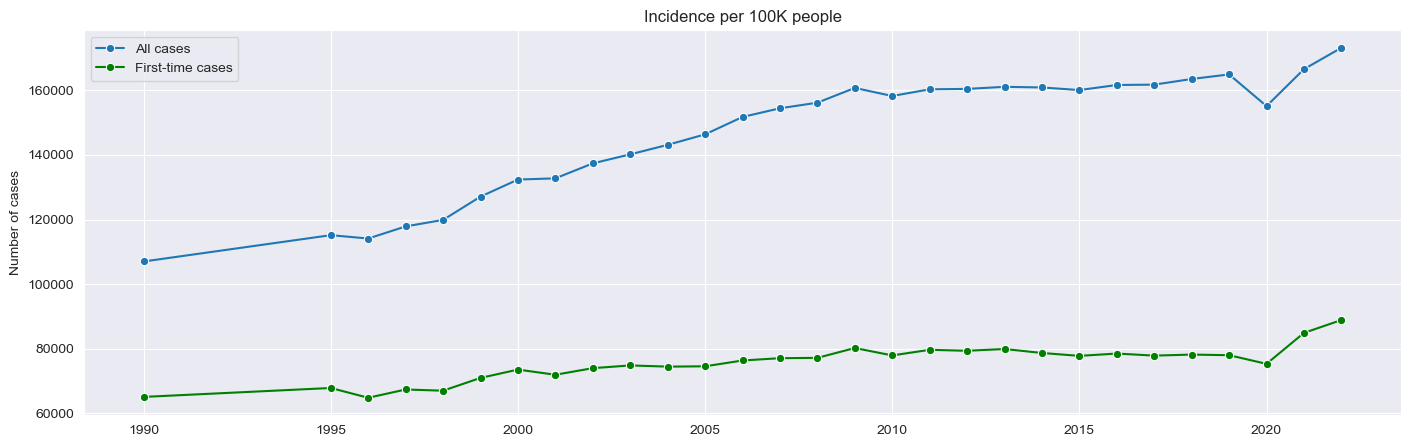

In [17]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_adult_long.query('disease_class in ["total"]'),
             x='year',
             y='total_per100k',
             label='All cases',
             marker='o')
sns.lineplot(data=df_adult_long.query('disease_class in ["total"]'),
             x='year',
             y='first_per100k',
             label='First-time cases',
             marker='o',  color='green')

plt.title('Incidence per 100K people')
plt.ylabel('Number of cases')
plt.xlabel(None)
plt.show()

Morbidity increased gradually until 2010, then stabilized somewhat, but since 2020, the "impact" of the COVID-19 pandemic is evident. The number of newly registered patients grew at a slower rate. Let's see which diseases make a greater contribution.

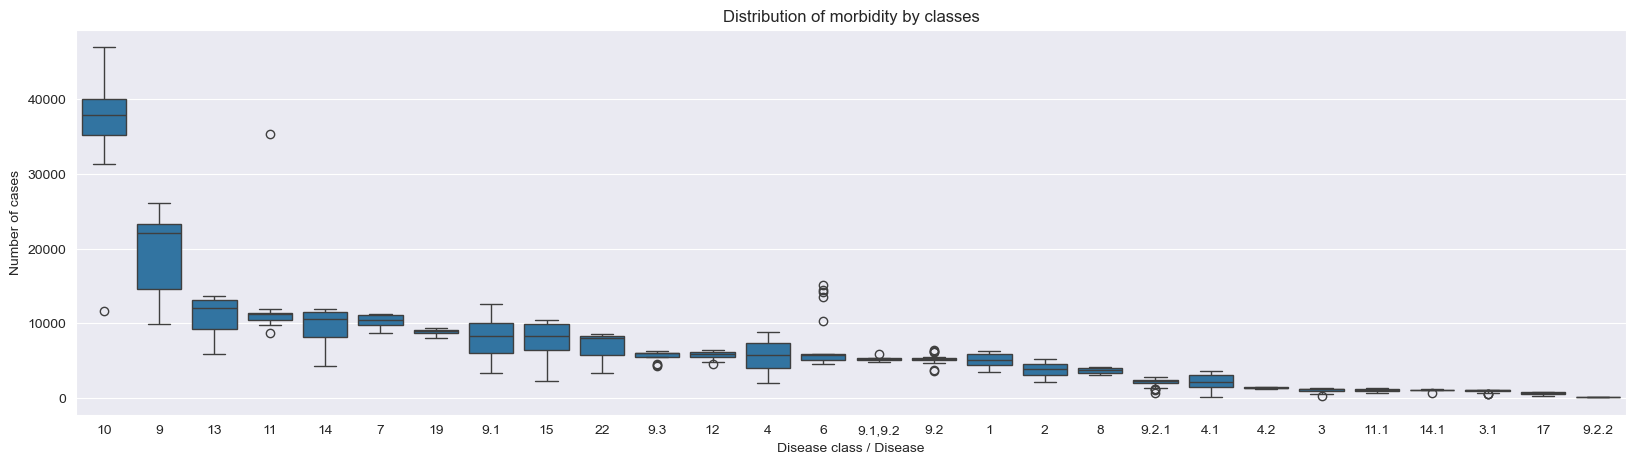

In [18]:
# boxplots

#calculate median cases by disease class
median_disease = df_adult_long.query('disease_class !="total"').groupby('disease_class')['total_per100k'].median().sort_values(ascending=False)

#create boxplots ordered by median number of cases
plt.figure(figsize=(20,5))
sns.boxplot(data=df_adult_long.query('disease_class !="total"'),
            x='disease_class',
            y='total_per100k',
            order=median_disease.index
           )

plt.title('Distribution of morbidity by classes')
plt.ylabel('Number of cases')
plt.xlabel('Disease class / Disease')
plt.show()

Respiratory diseases (10) are the most widespread, followed by diseases of the circulatory system (9). Among them, diseases characterized by high blood pressure (9.1) are more prominent than other individual diseases. Congenital anomalies (17) are the least common. There are outliers in the data, especially in classes 10, 11, and 6. Let's take a closer look at the dynamics of morbidity across different classes.

- **Respiratory diseases (10); digestive diseases (11); and circulatory system diseases (9)**

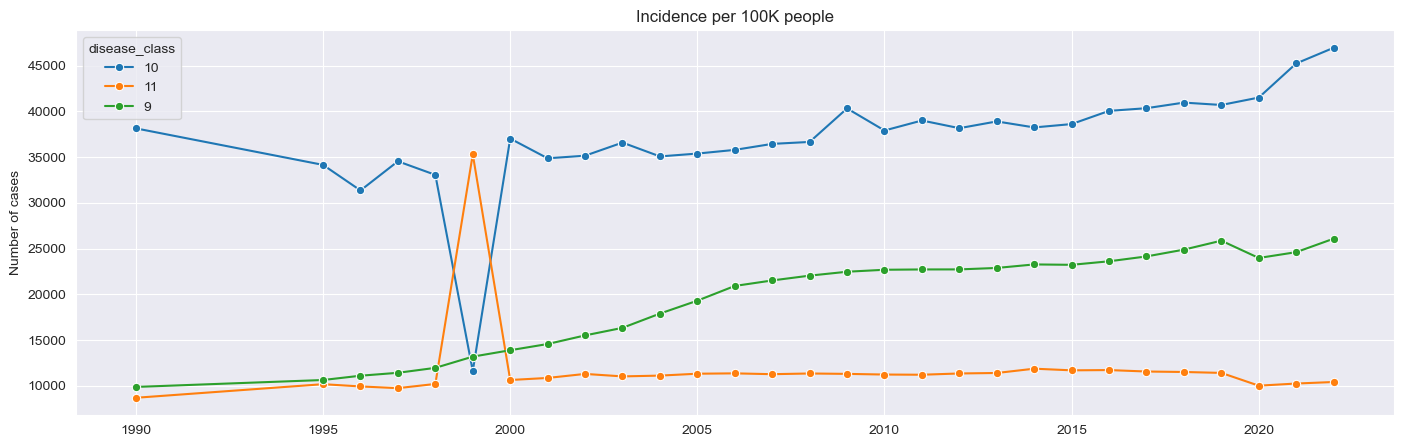

In [19]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_adult_long.query('disease_class in ["9", "10", "11"]'),
                x='year',
                y='total_per100k',
                hue='disease_class',
            marker='o')

plt.title('Incidence per 100K people')
plt.ylabel('Number of cases')
plt.xlabel(None)
plt.show()

In [20]:
df_adult_long.query('disease_class in ["10", "11"] and year in [1998, 1999, 2000]')

,disease_class,year,first_abs,first_per100k,total_abs,total_per100k
33,10,1998,41091.7,28193.9,48185.6,33061.1
34,10,1999,44054.6,30347.1,51257.5,11630.3
35,10,2000,46169.9,31947.0,53513.7,37028.4
62,11,1998,4748.1,3257.7,14889.1,10215.7
63,11,1999,4930.5,3164.9,15136.3,35308.8
64,11,2000,4698.2,3250.9,15386.3,10646.4


It seems that in 1999, the values for classes 10 and 11 in the incidence per 100K people (`total_per100k`) were swapped, as the absolute values are similar. The numbers in the original source are the same. In this case, we can swap the values for the neighboring disease classes.

In [21]:
# CHANGE VALUES
df_adult_long.iloc[34, 5] = 35308.8
df_adult_long.iloc[63, 5] = 11630.3

- **Diseases of the skin and subcutaneous tissue (12); musculoskeletal system and connective tissue (13); genitourinary system (14); and conditions related to pregnancy, childbirth, and the puerperium (15)**

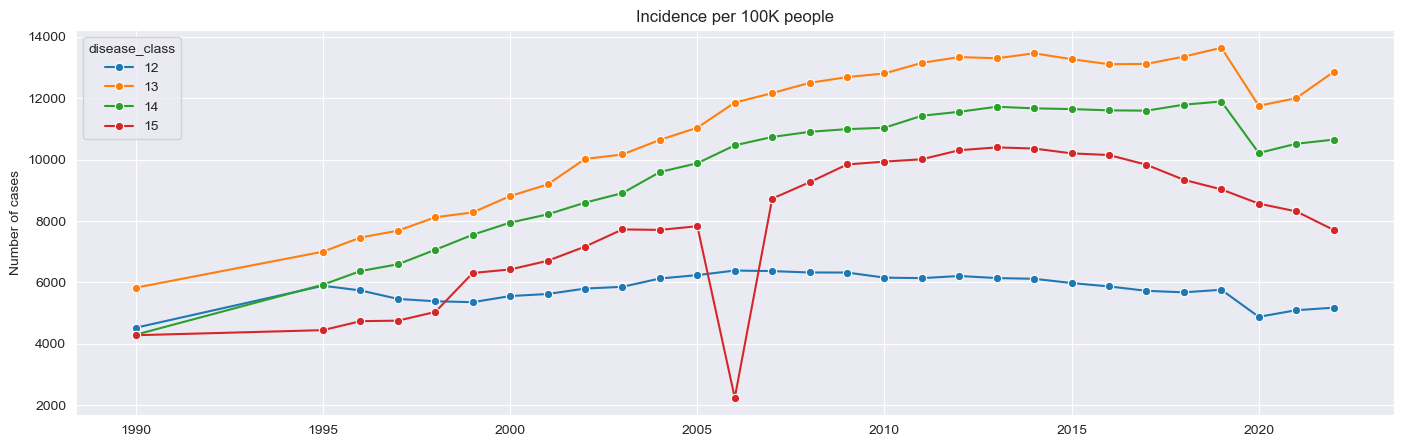

In [22]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_adult_long.query('disease_class in ["12", "13", "14", "15"]'),
                x='year',
                y='total_per100k',
                hue='disease_class',
            marker='o')

plt.title('Incidence per 100K people')
plt.ylabel('Number of cases')
plt.xlabel(None)
plt.show()

In [23]:
df_adult_long.query('disease_class=="15" and year in [2005, 2006, 2007]')

,disease_class,year,first_abs,first_per100k,total_abs,total_per100k
219,15,2005,2470.7,6289.2,3075.5,7828.6
220,15,2006,2519.0,1767.9,3187.9,2237.3
221,15,2007,2650.7,6816.7,3393.4,8726.7


In 2006, there is an incorrect value for class 15 in the incidence per 100K women, while the absolute values are similar. The data in the original source is the same. We can recalculate the incidence for 2006 based on the average number of women aged 15-49 years in 2006, which is 39,292,000.

In [24]:
print('2006. Total number of cases per 100K women')
print(round(3187.9 / 39292 * 100000, 1))
print('2006. Total number of new cases per 100K women')
print(round(2519.0 / 39292 * 100000, 1))

2006. Total number of cases per 100K women
8113.4
2006. Total number of new cases per 100K women
6411.0


These numbers seem more correct, let's use them.

In [25]:
# CHANGE VALUES
df_adult_long.iloc[220, 5] = round(3187.9 / 39292 * 100000, 1)
df_adult_long.iloc[220, 3] = round(2519.0 / 39292 * 100000, 1)

- **Neoplasms (2); endocrine, nutritional, and metabolic diseases(4), including diabetes mellitus (4.1) and obesity (4.2)**

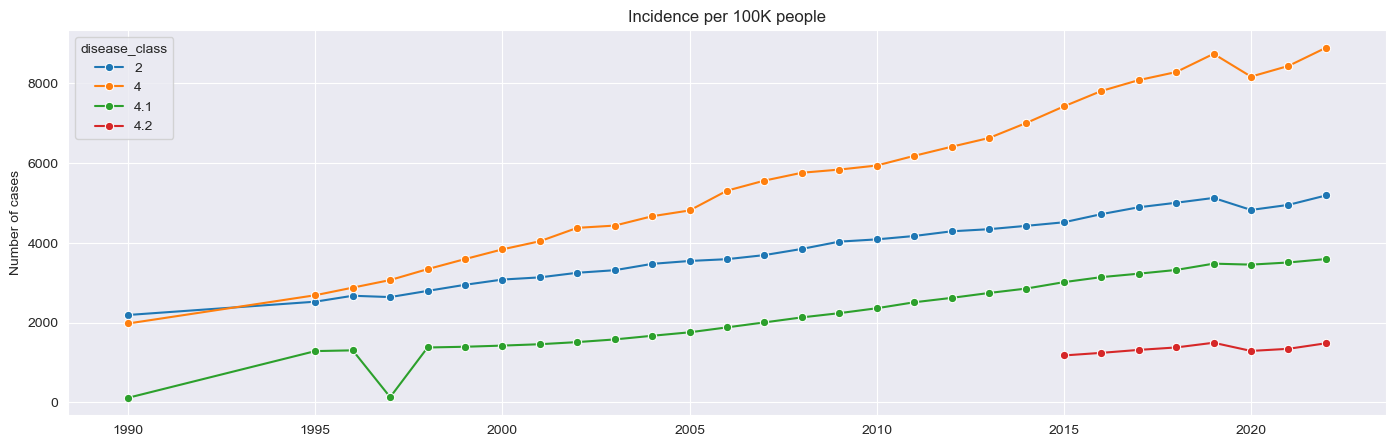

In [26]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_adult_long.query('disease_class in ["2", "4", "4.1", "4.2"]'),
                x='year',
                y='total_per100k',
                hue='disease_class',
            marker='o')

plt.title('Incidence per 100K people')
plt.ylabel('Number of cases')
plt.xlabel(None)
plt.show()

In [27]:
df_adult_long.query('disease_class=="4.1" and year in [1990, 1996, 1997, 1998]')

,disease_class,year,first_abs,first_per100k,total_abs,total_per100k
413,4.1,1990,174.4,117.9,1744.3,117.9
415,4.1,1996,146.2,99.8,1915.6,1307.5
416,4.1,1997,157.3,107.6,1951.4,133.5
417,4.1,1998,172.2,118.1,2010.1,1379.2


In 1997, there is an outlier for diabetes mellitus (4.1) in the incidence per 100K people, while the absolute values are similar. The data in the original source is the same. We can recalculate the incidence for 1997 based on the population of 147,137,000. Data for 1995 will not be adjusted or considered.

In [28]:
print('1997: Total number of cases per 100K people')
print(round(1951.4 / 147137 * 100000, 1))

1997: Total number of cases per 100K people
1326.2


This number seem more correct, let's use it.

In [29]:
# CHANGE VALUES
df_adult_long.iloc[416, 5] = round(1951.4 / 147137 * 100000, 1)

- **Diseases of the blood (3), including anemias (3.1); congenital malformations (17); peptic ulcer of the stomach and duodenum (11.1)**

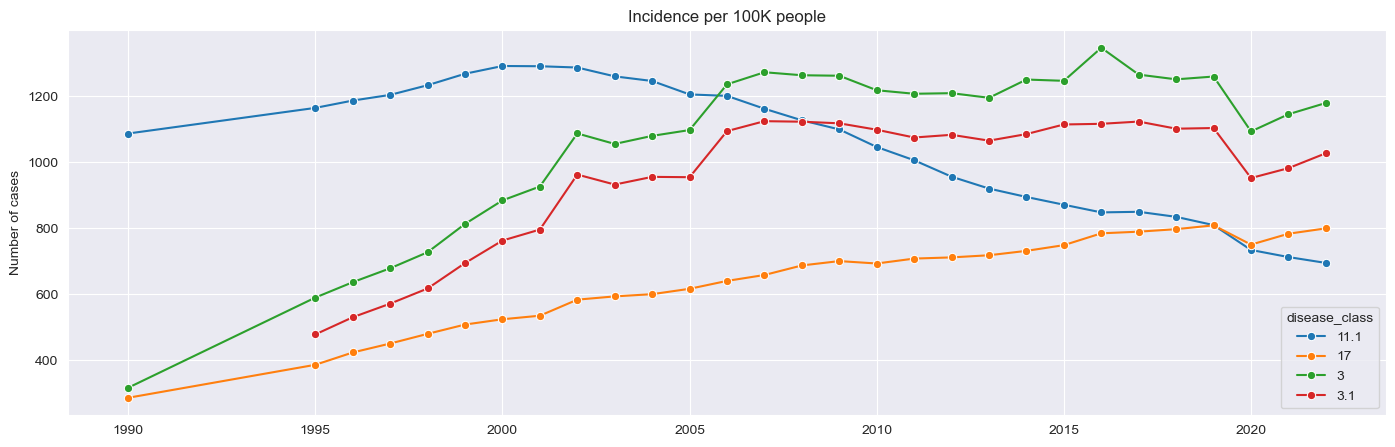

In [30]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_adult_long.query('disease_class in ["3", "3.1", "17", "11.1"]'),
                x='year',
                y='total_per100k',
                hue='disease_class',
            marker='o')

plt.title('Incidence per 100K people')
plt.ylabel('Number of cases')
plt.xlabel(None)
plt.show()

- **Diseases of the nervous system (6); eye and adnexa (7); ear and mastoid process (8)**

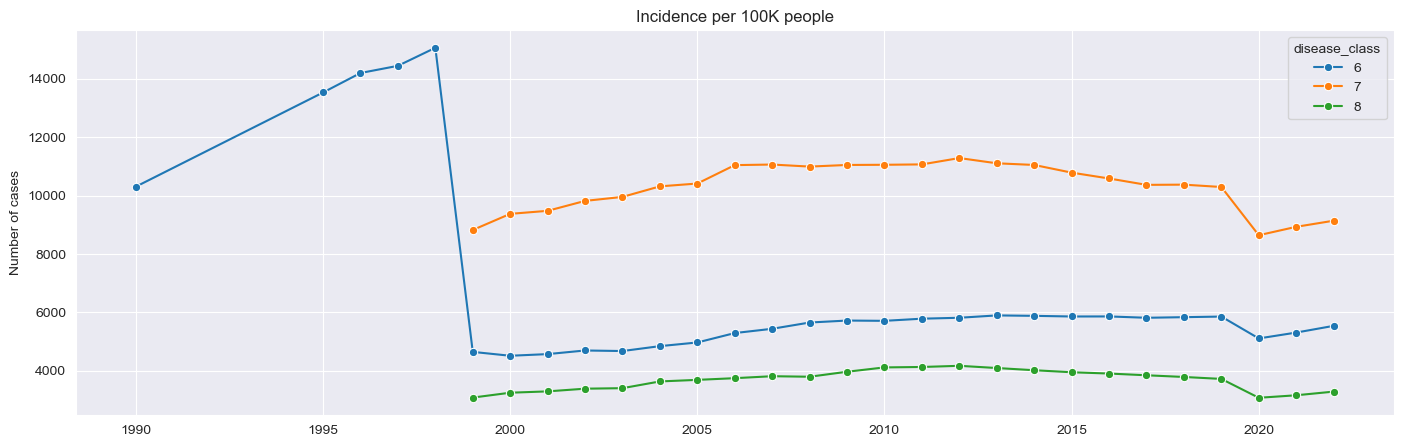

In [31]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_adult_long.query('disease_class in ["6", "7", "8"]'),
                x='year',
                y='total_per100k',
                hue='disease_class',
            marker='o')

plt.title('Incidence per 100K people')
plt.ylabel('Number of cases')
plt.xlabel(None)
plt.show()

It is evident that for diseases of the nervous system, there has been a change in the accounting system or something else since 1999.

- **Diseases characterized by high blood pressure (9.1), ischemic heart disease (9.2), including angina pectoris (9.2.1), acute myocardial infarction (9.2.2); cerebrovascular diseases (9.3)**

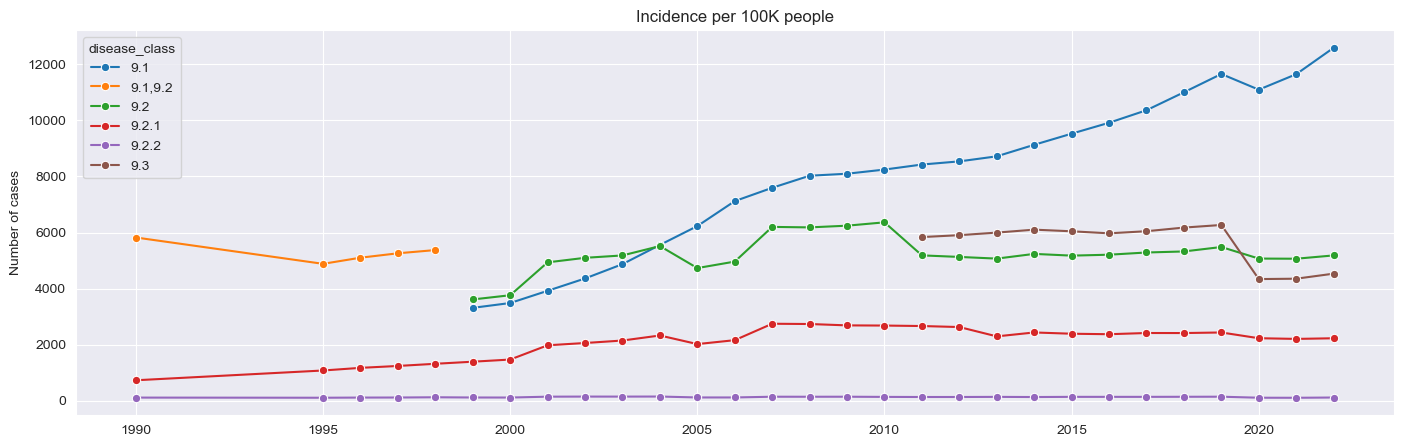

In [32]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_adult_long.query('disease_class in ["9.1", "9.2", "9.1,9.2", "9.3", "9.2.1", "9.2.2"]'),
                x='year',
                y='total_per100k',
                hue='disease_class',
            marker='o')

plt.title('Incidence per 100K people')
plt.ylabel('Number of cases')
plt.xlabel(None)
plt.show()

- **Certain infectious and parasitic diseases (1); injuries (19); COVID-19 (22)**

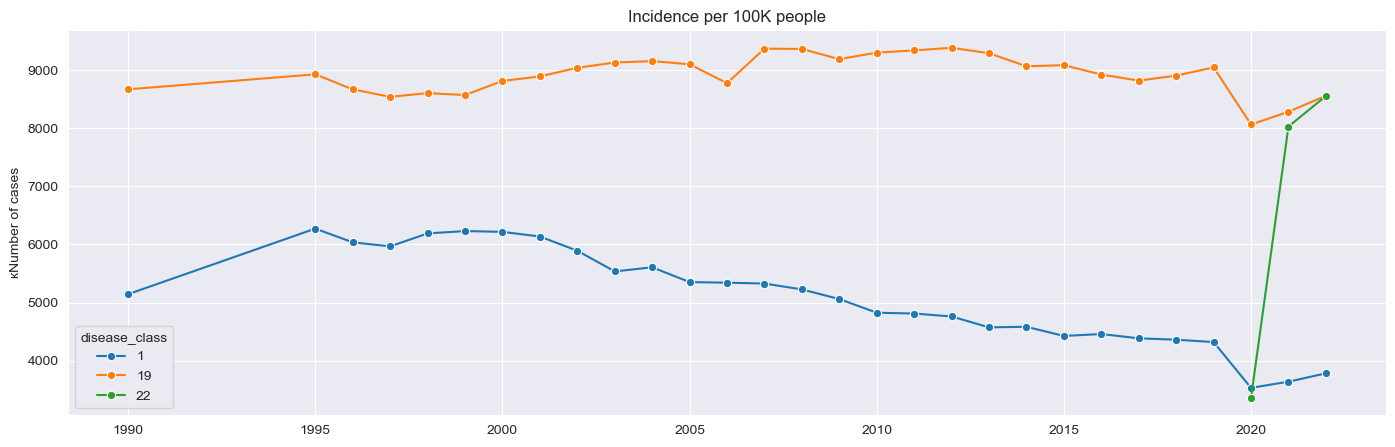

In [33]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_adult_long.query('disease_class in ["1", "19", "22"]'),
                x='year',
                y='total_per100k',
                hue='disease_class',
            marker='o')

plt.title('Incidence per 100K people')
plt.ylabel('кNumber of cases')
plt.xlabel(None)
plt.show()

### Children Under 1 Year Old

#### Data Load and Pre-Processing

For children under 1 year old, the relative data is provided per 1,000 children, rather than per 100,000.

In [34]:
# create dict of dataframes
data = {}

data['1990'] = read_wide_table('2001', file_name='2_42_1991-1998.csv', header=[2])
print('\033[1m1990\033[0m')
print('___________________')
display(data['1990'].tail())

for year in years:
    print('\033[1m'+year+'\033[0m')
    print('___________________')
    
    if year in ['2001', '2005', '2007', '2009']:
        df = read_wide_table(year, file_name='2_42.csv', header=[2])
    elif year == '2013':
        df = read_wide_table(year, file_name='2_42.csv', header=[1])
    elif year in ['2011', '2023']:
        df = read_table(year, file_name='2_42.csv', file_name2023='2_39-2_53.xlsx', sheet_name='2.42', header=[1])
    else:
        df = read_table(year, file_name='2_42.csv', header=[0])

    display(df.tail())

    # add dataframe to the dict of dataframes
    data[year] = df

1990
___________________


,disease_class,1991,1995,1996,1997,1998,type
25,11,55.2,89.8,102.0,104.0,120.6,total_per100k
26,14,14.0,24.0,27.0,29.0,33.1,total_per100k
27,17,26.3,39.1,45.4,46.6,53.0,total_per100k
28,16,167.9,303.2,347.8,366.2,430.6,total_per100k
29,19,15.4,17.3,16.4,15.8,16.1,total_per100k


2001
___________________


,disease_class,1999,2000,type
29,11,119.2,128.1,total_per100k
30,14,32.4,35.4,total_per100k
31,16,444.1,481.2,total_per100k
32,17,52.3,54.2,total_per100k
33,19,15.5,15.1,total_per100k


2005
___________________


,disease_class,2000,2001,2002,2003,2004,type
29,11,128.1,128.7,137.8,137.9,139.5,total_per100k
30,14,35.4,35.3,38.9,40.6,43.6,total_per100k
31,16,481.2,494.4,510.1,497.0,488.1,total_per100k
32,17,54.2,53.6,57.4,59.8,61.1,total_per100k
33,19,15.1,14.8,15.8,15.8,16.8,total_per100k


2007
___________________


,disease_class,2000,2005,2006,type
29,11,128.1,140.3,146.7,total_per100k
30,14,35.4,43.6,45.3,total_per100k
31,16,481.2,480.4,474.6,total_per100k
32,17,54.2,62.3,66.2,total_per100k
33,19,15.1,16.1,16.9,total_per100k


2009
___________________


,disease_class,2000,2005,2007,2008,type
29,11,128.1,132.6,140.2,144.2,total_per100k
30,14,35.4,41.2,44.6,47.5,total_per100k
31,16,481.2,454.2,431.8,405.4,total_per100k
32,17,54.2,58.9,66.9,73.1,total_per100k
33,19,15.1,15.3,15.4,16.0,total_per100k


2011
___________________


,disease_class,2000,2005,2009,2010,type
12,11,140.7,190.7,246.6,250.0,total_abs
13,14,38.9,59.3,83.2,84.3,total_abs
14,16,528.6,653.0,660.3,654.4,total_abs
15,17,59.6,84.7,123.1,125.3,total_abs
16,19,16.6,21.9,26.3,27.2,total_abs


2013
___________________


,disease_class,2012,type
29,11,"150,1",total_per100k
30,14,"51,5",total_per100k
31,16,"367,1",total_per100k
32,17,"76,8",total_per100k
33,19,"15,8",total_per100k


2015
___________________


,disease_class,2005,2010,2011,2012,2013,2014,type
29,11,"140,3","154,0","155,1","150,1","141,7","137,9",total_per100k
30,14,"43,6","51,9","51,5","51,5","51,1","50,4",total_per100k
31,16,"480,4","403,2","381,5","367,1","340,9","313,5",total_per100k
32,17,"62,3","77,2","75,4","76,8","72,2","74,6",total_per100k
33,19,"16,1","16,8","16,5","15,8","14,8","14,6",total_per100k


2017
___________________


,disease_class,2005,2010,2013,2014,2015,2016,type
29,11,"140,3","154,0","141,7","137,9","143,9","146,3",total_per100k
30,14,"43,6","51,9","51,1","50,4","50,6","57,5",total_per100k
31,16,"480,4","403,2","340,9","313,5","293,1","290,0",total_per100k
32,17,"62,3","77,2","72,2","74,6","73,9","86,3",total_per100k
33,19,"16,1","16,8","14,8","14,6","14,2","26,4",total_per100k


2019
___________________


,disease_class,2005,2010,2015,2016,2017,2018,type
29,11,"140,3","154,0","143,9","146,3","142,5","152,1",total_per100k
30,14,"43,6","51,9","50,6","57,5","54,3","56,5",total_per100k
31,16,"480,4","403,2","293,1","290,0","263,8","264,6",total_per100k
32,17,"62,3","77,2","73,9","86,3","81,9","90,9",total_per100k
33,19,"16,1","16,8","14,2","26,4","24,5","26,7",total_per100k


2021
___________________


,disease_class,2005,2010,2015,2018,2019,2020,type
31,14,"43,6","51,9","50,6","56,5","48,4","44,6",total_per100k
32,16,"480,4","403,2","293,1","264,6","246,9","242,5",total_per100k
33,17,"62,3","77,2","73,9","90,9","91,1","89,1",total_per100k
34,19,"16,1","16,8","14,2","26,7","24,6","24,2",total_per100k
35,22,NaN,NaN,NaN,NaN,NaN,"9,1",total_per100k


2023
___________________


,disease_class,2010,2015,2019,2020,2021,2022,type
31,14,49.8,46.4,45.9,42,43.3,40.9,total_per100k
32,16,386.3,268.3,234.4,228,225.4,210.6,total_per100k
33,17,74,67.7,86.5,83.7,90.8,94.8,total_per100k
34,19,16.1,13,23.3,22.8,22.7,23.1,total_per100k
35,22,NaN,NaN,NaN,8.6,36.8,72.5,total_per100k


In [35]:
# merge data
df_1y = (data['2023']
          .merge(data['2021'].drop(columns=['2020', '2019', '2015', '2010']), how='outer', on=['disease_class', 'type'])
          .merge(data['2019'].drop(columns=['2018', '2015', '2010', '2005']), how='outer', on=['disease_class', 'type'])
          .merge(data['2017'].drop(columns=['2016', '2015', '2010', '2005']), how='outer', on=['disease_class', 'type'])
          .merge(data['2015'].drop(columns=['2014', '2013', '2010', '2005']), how='outer', on=['disease_class', 'type'])
          .merge(data['2011'].drop(columns=['2010', '2005', '2000']), how='outer', on=['disease_class', 'type'])
          .merge(data['2009'].drop(columns=['2005']), how='outer', on=['disease_class', 'type'])
          .merge(data['2007'].drop(columns=['2000', '2005']), how='outer', on=['disease_class', 'type'])
          .merge(data['2005'].drop(columns=['2000']), how='outer', on=['disease_class', 'type'])
          .merge(data['2001'].drop(columns=['2000']), how='outer', on=['disease_class', 'type'])
          .merge(data['1990'], how='outer', on=['disease_class', 'type'])
         )

# new order of columns
new_order = ['disease_class', 'type', 
             '1991', '1995', '1996',
             '1997', '1998', '1999',
             '2000', '2001', '2002',
             '2003', '2004', '2005',
             '2006', '2007', '2008',
             '2009', '2010', '2011',
             '2012', '2013', '2014',
             '2015', '2016', '2017',
             '2018', '2019', '2020',
             '2021', '2022']

# reorder the DataFrame
df_1y = df_1y[new_order]
df_1y

,disease_class,type,1991,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,total,total_abs,2982.7,2858.3,2852.6,2873.4,2965.3,2955.0,2982.8,3070.3,3270.9,3453.6,3567.2,"3 625,4",3674.2,3857.9,4120.2,4318.3,"4 419,3","4402,9","4393,9","4449,7","4421,2","4 399,5","4761,6","4454,7","4 260,3","3 518,8","2 999,8","3 082,7","3 053,9"
1,1,total_abs,151.4,127.9,109.3,102.1,104.0,108.2,103.2,102.8,108.8,105.2,106.5,"104,6",104.3,108.4,111.3,113.5,116,"110,1","108,1","107,2","105,2",103.1,"109,5","104,0","97,3",76.5,57.3,59.8,60.9
2,1.1,total_abs,90.1,76.1,66.0,60.2,60.5,63.4,57.6,59.4,63.7,63.7,61.7,"60,8",60.2,63.7,65.5,70.5,71.5,"65,2","64,0","61,6","58,1",55.4,"53,1","48,5","42,6",32.6,22.6,22.2,22.8
3,3,total_abs,...,113.8,124.6,126.3,135.4,145.7,153.7,155.3,170.6,167.0,166.8,"164,9",168.3,172.8,184.3,181.9,181.4,"173,5","167,8","167,0","167,0",164.8,"154,5","148,0","137,0",99.5,84.8,83.4,79.6
4,3.1,total_abs,...,109.7,120.2,122.6,133.0,140.0,149.9,149.4,165.9,163.0,162.5,"160,5",159.0,166.0,178.4,176.0,176.3,"168,5","162,4","161,1","161,1",158.2,"146,3","141,3","130,4",94.5,81,79.3,75.1
5,4,total_abs,...,133.8,138.6,138.4,146.5,138.2,135.1,131.7,137.5,134.9,134.4,"131,0",133.1,132.0,135.1,129.9,128.9,"122,5","117,9","112,8","107,9",103,"91,8","83,9","78,5",65.8,56.8,54.6,50.5
6,4.3,total_abs,...,70.3,72.4,73.9,81.1,76.7,77.1,75.1,76.6,74.8,73.1,"71,3",73.0,72.2,69.0,66.6,64.6,"60,5","57,5","53,6","49,4",48.1,"43,0","39,7","36,3",31.8,28.8,24.9,23.3
7,6,total_abs,232.2,257.5,274.9,269.5,282.7,165.1,158.8,162.6,170.3,192.3,219.3,"227,2",244.1,277.0,319.9,326.0,331.2,"343,8","358,0","372,9","385,2",393.6,"434,4","402,3","398,4",329,297.7,303.4,281.5
8,6.1,total_abs,2.5,1.6,1.5,1.1,1.2,1.6,0.9,1.0,1.2,1.2,1.2,"1,2",1.2,1.2,1.3,1.4,1.8,"1,7","1,3","1,1","1,3",1.2,"1,5","1,0","0,9",0.9,–,0.03,0.2
9,7,total_abs,NaN,NaN,NaN,NaN,NaN,64.7,70.2,75.5,84.5,90.1,97.7,"104,4",107.9,116.9,135.8,139.3,150.2,"151,9","159,8","163,9","171,0",173.6,"195,5","184,2","179,3",145.1,119.4,120.5,111.9


In [36]:
# convert the cleaned data to long format
df_1y_long = df_long_clean(df_1y)
df_1y_long

,disease_class,year,total_abs,total_per100k
0,1,1991,151.4,92.9
1,1,1995,127.9,104.4
2,1,1996,109.3,94.6
3,1,1997,102.1,87.4
4,1,1998,104.0,91.8
...,...,...,...,...
476,total,2018,4260.3,2738.4
477,total,2019,3518.8,2296.0
478,total,2020,2999.8,2075.0
479,total,2021,3082.7,2196.5


In [37]:
print('\033[1mNumber of missing values\033[0m')
df_1y_long.isna().sum()

Number of missing values


disease_class     0
year              0
total_abs         0
total_per100k    17
dtype: int64

In [38]:
df_1y_long[df_1y_long.total_per100k.isna()]

,disease_class,year,total_abs,total_per100k
15,1,2009,113.5,NaN
44,1.1,2009,70.5,NaN
73,10,2009,1936.8,NaN
102,11,2009,246.6,NaN
131,14,2009,83.2,NaN
160,16,2009,660.3,NaN
189,17,2009,123.1,NaN
218,19,2009,26.3,NaN
249,3,2009,181.9,NaN
277,3.1,2009,176.0,NaN


For 2009, there is no data on the incidence of diseases per 1,000 children under 1 year old. This indicator can only be estimated approximately, as there is no data on the number of children under 1 year old in 2009—the demographic report for 2011 is missing.

#### EDA

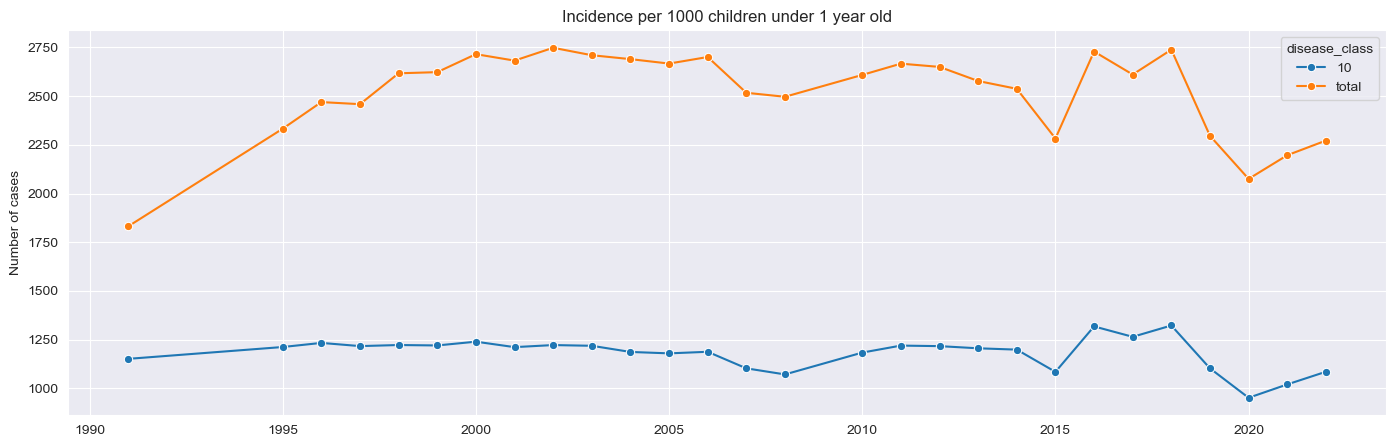

In [39]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_1y_long.query('disease_class in ["total", "10"]'),
             x='year',
             y='total_per100k',
             hue='disease_class',
             marker='o')

plt.title('Incidence per 1000 children under 1 year old')
plt.ylabel('Number of cases')
plt.xlabel(None)
plt.show()

Morbidity of children under 1 year old has not increased since 2000, but there are noticeable spikes starting from 2015. The trend in overall incidence mirrors the trend in respiratory diseases.

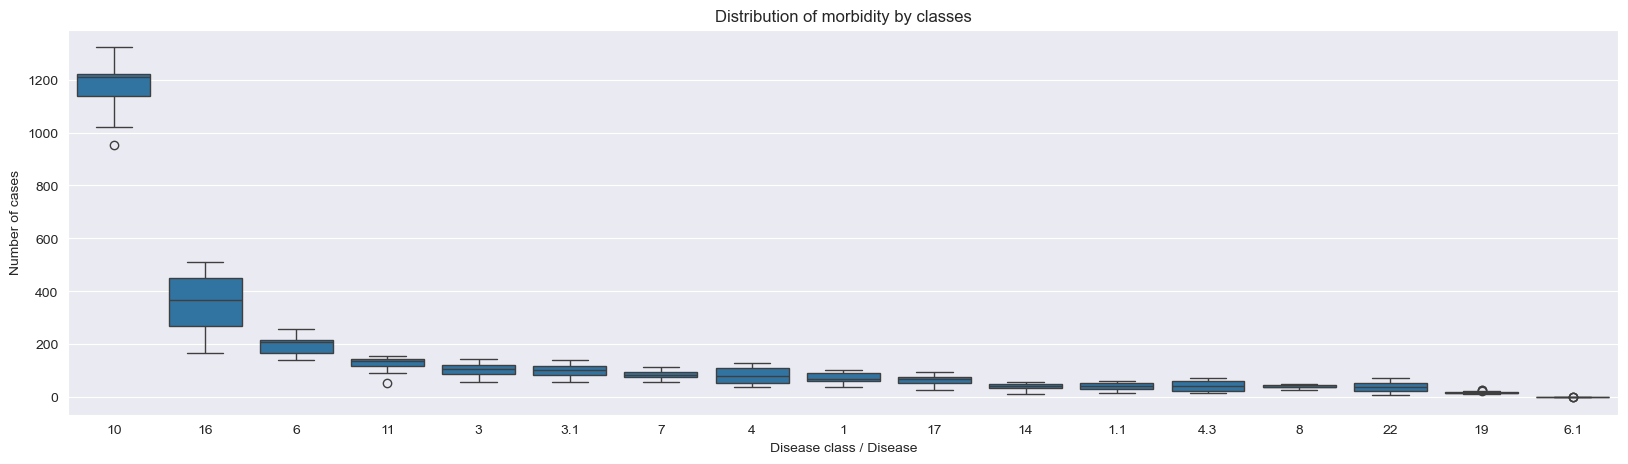

In [40]:
# boxplots

#calculate median cases by disease class
median_disease = df_1y_long.query('disease_class !="total"').groupby('disease_class')['total_per100k'].median().sort_values(ascending=False)

#create boxplots ordered by median number of cases
plt.figure(figsize=(20,5))
sns.boxplot(data=df_1y_long.query('disease_class !="total"'),
            x='disease_class',
            y='total_per100k',
            order=median_disease.index)

plt.title('Distribution of morbidity by classes')
plt.ylabel('Number of cases')
plt.xlabel('Disease class / Disease')
plt.show()

As with the overall population, respiratory diseases are the most common, followed by perinatal diseases. Nervous system diseases are less common, and injuries are the least frequent, which is logical.

- **Diseases of the nervous system (6); digestive system (11), and certain conditions originating in the perinatal period (16)**

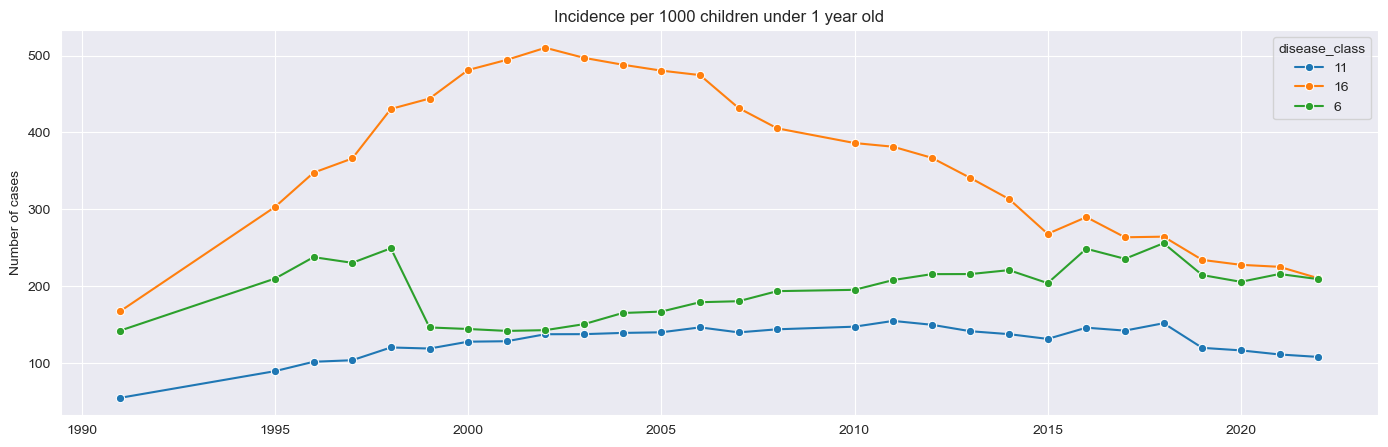

In [41]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_1y_long.query('disease_class in ["16", "6", "11"]'),
                x='year',
                y='total_per100k',
                hue='disease_class',
            marker='o')

plt.title('Incidence per 1000 children under 1 year old')
plt.ylabel('Number of cases')
plt.xlabel(None)
plt.show()

- **Diseases of the blood (3), including anemias (3.1); endocrine, nutritional, and metabolic diseases (4), including rickets (4.3)**

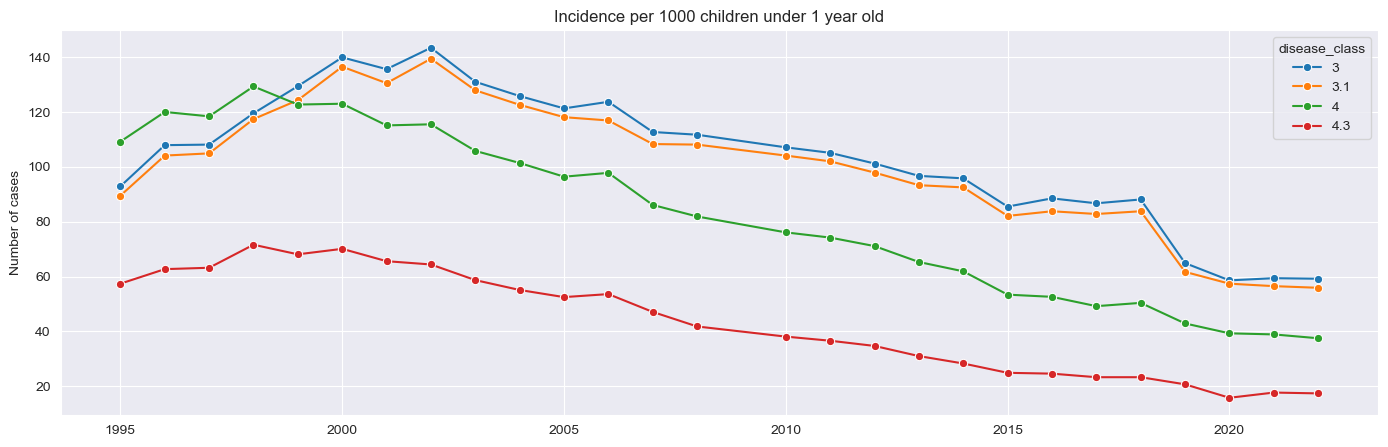

In [42]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_1y_long.query('disease_class in ["3", "3.1", "4", "4.3"]'),
                x='year',
                y='total_per100k',
                hue='disease_class',
            marker='o')

plt.title('Incidence per 1000 children under 1 year old')
plt.ylabel('Number of cases')
plt.xlabel(None)
plt.show()

- **Certain infectious and parasitic diseases (1), including intestinal infections(1.1); diseases of the genitourinary system (14), eye and adnexa (7), congenital malformations (17)**

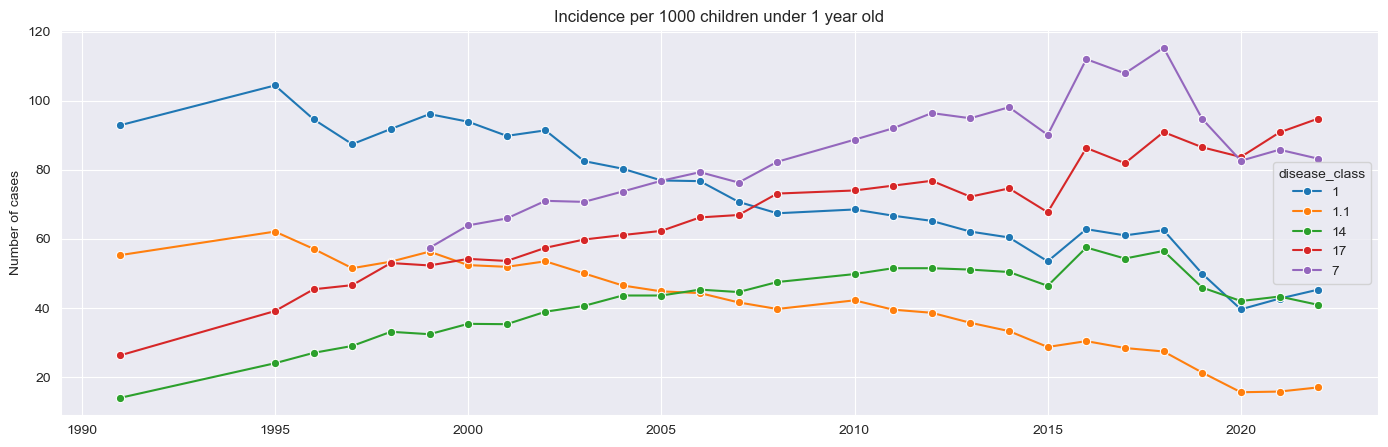

In [43]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_1y_long.query('disease_class in ["1", "1.1", "7", "14", "17"]'),
                x='year',
                y='total_per100k',
                hue='disease_class',
            marker='o')

plt.title('Incidence per 1000 children under 1 year old')
plt.ylabel('Number of cases')
plt.xlabel(None)
plt.show()

- **Diseases of the ear and mastoid process (8); injuries (19), COVID-19 (22)**

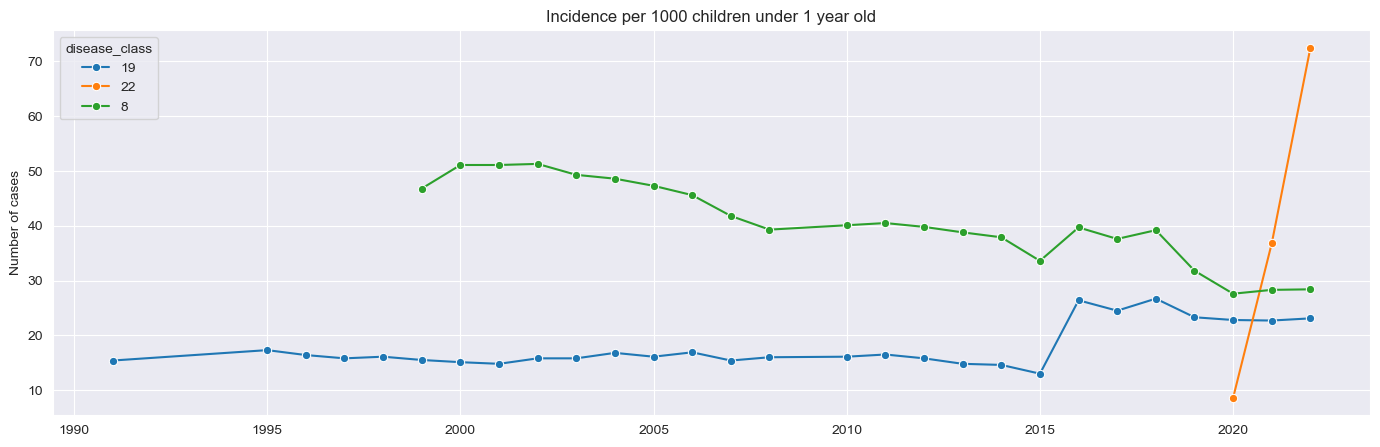

In [44]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_1y_long.query('disease_class in ["8", "19", "22"]'),
                x='year',
                y='total_per100k',
                hue='disease_class',
            marker='o')

plt.title('Incidence per 1000 children under 1 year old')
plt.ylabel('Number of cases')
plt.xlabel(None)
plt.show()

- **Cerebral palsy in children(6.1)**

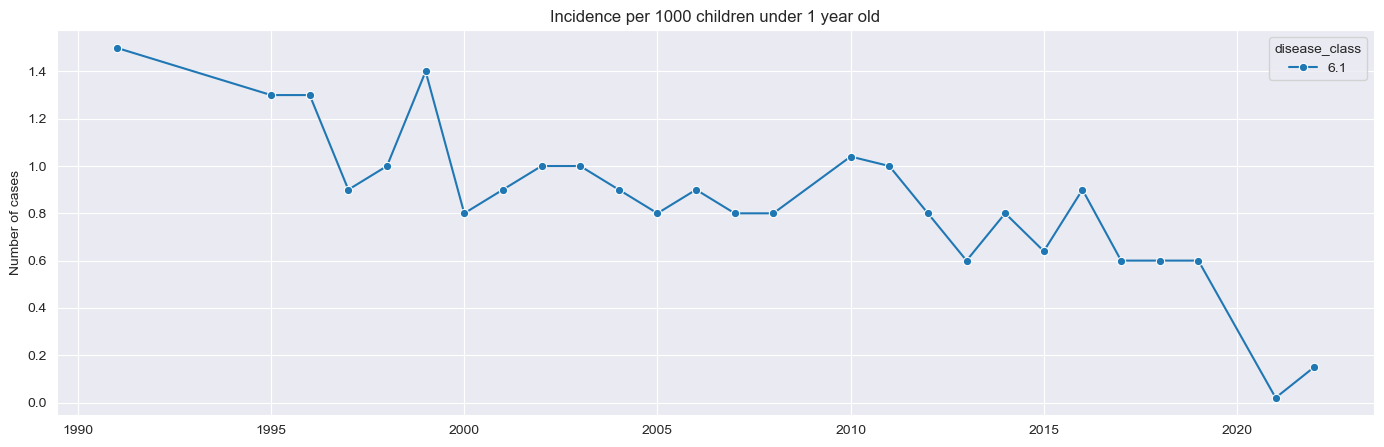

In [45]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_1y_long.query('disease_class in ["6.1"]'),
                x='year',
                y='total_per100k',
                hue='disease_class',
            marker='o')

plt.title('Incidence per 1000 children under 1 year old')
plt.ylabel('Number of cases')
plt.xlabel(None)
plt.show()

In [46]:
df_1y_long.query('disease_class in ["6.1"] and year in [2017, 2018, 2019,2020, 2021, 2022]')

,disease_class,year,total_abs,total_per100k
399,6.1,2017,1.00,0.60
400,6.1,2018,0.90,0.60
401,6.1,2019,0.90,0.60
402,6.1,2021,0.03,0.02
403,6.1,2022,0.20,0.15


### Children Aged 0 to 14 Years

#### Data Load and Pre-Processing

In [47]:
# create dict of dataframes
data = {}

data['1990'] = read_table('2001', file_name='2_45_1990-1998.csv', header=[1])
print('\033[1m1990\033[0m')
print('___________________')
display(data['1990'].head())

for year in years:
    print('\033[1m'+year+'\033[0m')
    print('___________________')

    if year == '2001':
        df = read_wide_table(year, file_name='2_45.csv', header=[2])
    elif year in ['2013', '2015', '2017', '2019', '2021']:
        df = read_table(year, file_name='2_45.csv', header=[0])
    else:
        df = read_table(year, file_name='2_45.csv', file_name2023='2_39-2_53.xlsx', sheet_name='2.45', header=[1])

    display(df.head())

    # add dataframe to the dict of dataframes
    data[year] = df

1990
___________________


,disease_class,1990,1995,1996,1997,1998,type
0,total,38587.1,37986.5,35154.5,36425.2,36704.2,total_abs
1,1,3002.7,3361.3,2790.0,2554.9,2718.6,total_abs
2,2,35.4,51.1,53.0,54.7,59.4,total_abs
3,4,183.6,306.5,322.0,341.7,372.9,total_abs
4,4.1,2.1,2.7,3.0,3.1,2.8,total_abs


2001
___________________


,disease_class,1999,2000,type
0,total,37582.0,38225.7,total_abs
1,1,2809.3,2689.4,total_abs
2,2,59.5,59.7,total_abs
3,3,293.0,316.4,total_abs
4,3.1,260.9,286.7,total_abs


2005
___________________


,disease_class,2000,2001,2002,2003,2004,type
0,total,38225.7,36983.0,37934.4,37118.6,36471.8,total_abs
1,1,2689.4,2578.0,2314.8,1970.2,2012.6,total_abs
2,2,59.7,59.5,64.1,65.8,72.6,total_abs
3,3,316.4,322.5,466.2,370.9,279.0,total_abs
4,3.1,286.7,292.8,438.5,344.1,349.9,total_abs


2007
___________________


,disease_class,2000,2003,2004,2005,2006,type
0,total,38225.7,37118.6,36471.8,36837.3,37388.5,total_abs
1,1,2689.4,1970.2,2012.6,1905.1,1897.0,total_abs
2,2,59.7,65.8,72.6,73.1,75.2,total_abs
3,3,316.4,370.9,279.0,382.1,417.7,total_abs
4,3.1,286.7,344.1,349.9,353.3,386.9,total_abs


2009
___________________


,disease_class,2000,2005,2006,2007,2008,type
0,total,38225.7,36837.3,37388.5,38140.5,38293.8,total_abs
1,1,2689.4,1905.1,1897.0,1973.7,1937.1,total_abs
2,2,59.7,73.1,75.2,80.2,86.6,total_abs
3,3,316.4,382.1,417.7,424.5,416.1,total_abs
4,3.1,286.7,353.3,386.9,394.5,386.0,total_abs


2011
___________________


,disease_class,2000,2005,2006,2009,2010,type
0,total,38225.7,36837.3,37388.5,41302.0,40903.5,total_abs
1,1,2689.4,1905.1,1897.0,1833.8,1765.4,total_abs
2,2,59.7,73.1,75.2,92.1,96.2,total_abs
3,3,316.4,382.1,417.7,393.8,389.9,total_abs
4,3.1,286.7,353.3,386.9,367.4,366.6,total_abs


2013
___________________


,disease_class,2005,2010,2011,2012,type
0,total,"36837,4","40903,5","42055,8","42549,7",total_abs
1,1,"1905,1","1765,4","1790,9","1854,5",total_abs
2,2,"73,1","96,2","101,2","107,9",total_abs
3,3,"382,1","389,9","365,3","365,6",total_abs
4,3.1,"353,3","366,6","340,4","339,5",total_abs


2015
___________________


,disease_class,2005,2010,2011,2012,2013,2014,type
0,total,"36837,4","40903,5","42055,8","42549,7","43155,1","44157,6",total_abs
1,1,"1905,1","1765,4","1790,9","1854,5","1811,4","1944,0",total_abs
2,2,"73,1","96,2","101,2","107,9","110,3","115,4",total_abs
3,3,"382,1","389,9","365,3","365,6","350,9","359,6",total_abs
4,3.1,"353,3","366,6","340,4","339,5","326,2","332,2",total_abs


2017
___________________


,disease_class,2005,2010,2013,2014,2015,2016,type
0,total,"36837,4","40903,5","43155,1","44157,6","43843,0","44831,9",total_abs
1,1,"1905,1","1765,4","1811,4","1944,0","1797,4","1793,4",total_abs
2,2,"73,1","96,2","110,3","115,4","118,0","118,8",total_abs
3,3,"382,1","389,9","350,9","359,6","345,3","344,7",total_abs
4,3.1,"353,3","366,6","326,2","332,2","319,8","319,8",total_abs


2019
___________________


,disease_class,2005,2010,2015,2016,2017,2018,type
0,total,"36837,4","40903,5","43843,0","44831,9","44919,0","45210,9",total_abs
1,1,"1905,1","1765,4","1797,4","1793,4","1793,4","1793,6",total_abs
2,2,"73,1","96,2","118,0","118,8","121,7","121,2",total_abs
3,3,"382,1","389,9","345,3","344,7","316,1","306,1",total_abs
4,3.1,"353,3","366,6","319,8","319,8","292,7","279,1",total_abs


2021
___________________


,disease_class,2005,2010,2015,2018,2019,2020,type
0,total,"36 837,4","40 903,5","43 843,0","45 210,9","44 734,3","38 526,1",total_abs
1,1,"1 905,1","1 765,4","1 797,4","1 793,6","1 792,0","1 321,0",total_abs
2,2,"73,1","96,2","118,0","121,2","128,0","105,7",total_abs
3,3,"382,1","389,9","345,3","306,1","286,5","232,4",total_abs
4,3.1,"353,3","366,6","319,8","279,1","260,0","214,6",total_abs


2023
___________________


,disease_class,2010,2015,2019,2020,2021,2022,type
0,total,"40 903,5","43 843,0","44 734,3","38 526,1",43047.6,45192.9,total_abs
1,1,"1 765,4","1 797,4","1 792,0","1 321,0",1417.6,1553.1,total_abs
2,2,96.2,118,128,105.7,118.4,120.1,total_abs
3,3,389.9,345.3,286.5,232.4,244.1,241.6,total_abs
4,3.1,366.6,319.8,260,214.6,225.4,220.1,total_abs


In [48]:
# merge data
df_0_14 = (data['2023']
          .merge(data['2021'].drop(columns=['2020', '2019', '2015', '2010']), how='outer', on=['disease_class', 'type'])
          .merge(data['2019'].drop(columns=['2018', '2015', '2010', '2005']), how='outer', on=['disease_class', 'type'])
          .merge(data['2017'].drop(columns=['2016', '2015', '2010', '2005']), how='outer', on=['disease_class', 'type'])
          .merge(data['2015'].drop(columns=['2014', '2013', '2010', '2005']), how='outer', on=['disease_class', 'type'])
          .merge(data['2011'].drop(columns=['2010', '2005', '2006', '2000']), how='outer', on=['disease_class', 'type'])
          .merge(data['2009'].drop(columns=['2005']), how='outer', on=['disease_class', 'type'])
          .merge(data['2007'].drop(columns=['2000', '2003', '2004', '2005', '2006']), how='outer', on=['disease_class', 'type'])
          .merge(data['2005'].drop(columns=['2000']), how='outer', on=['disease_class', 'type'])
          .merge(data['2001'].drop(columns=['2000']), how='outer', on=['disease_class', 'type'])
          .merge(data['1990'], how='outer', on=['disease_class', 'type'])
         )

# new order of columns
new_order = ['disease_class', 'type', 
             '1990', '1995', '1996',
             '1997', '1998', '1999',
             '2000', '2001', '2002',
             '2003', '2004', '2005',
             '2006', '2007', '2008',
             '2009', '2010', '2011',
             '2012', '2013', '2014',
             '2015', '2016', '2017',
             '2018', '2019', '2020',
             '2021', '2022']

# reorder the DataFrame
df_0_14 = df_0_14[new_order]
df_0_14

,disease_class,type,1990,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,total,total_abs,38587.1,37986.5,35154.5,36425.2,36704.2,37582.0,38225.7,36983.0,37934.4,37118.6,36471.8,"36 837,4",37388.5,38140.5,38293.8,41302.0,"40 903,5","42055,8","42549,7","43155,1","44157,6","43 843,0","44831,9","44919,0","45 210,9","44 734,3","38 526,1",43047.6,45192.9
1,1,total_abs,3002.7,3361.3,2790.0,2554.9,2718.6,2809.3,2689.4,2578.0,2314.8,1970.2,2012.6,"1 905,1",1897.0,1973.7,1937.1,1833.8,"1 765,4","1790,9","1854,5","1811,4","1944,0","1 797,4","1793,4","1793,4","1 793,6","1 792,0","1 321,0",1417.6,1553.1
2,2,total_abs,35.4,51.1,53.0,54.7,59.4,59.5,59.7,59.5,64.1,65.8,72.6,"73,1",75.2,80.2,86.6,92.1,96.2,"101,2","107,9","110,3","115,4",118,"118,8","121,7","121,2",128,105.7,118.4,120.1
3,3,total_abs,139.6,243.0,251.3,256.9,269.8,293.0,316.4,322.5,466.2,370.9,279.0,"382,1",417.7,424.5,416.1,393.8,389.9,"365,3","365,6","350,9","359,6",345.3,"344,7","316,1","306,1",286.5,232.4,244.1,241.6
4,3.1,total_abs,...,201.1,216.0,225.2,237.6,260.9,286.7,292.8,438.5,344.1,349.9,"353,3",386.9,394.5,386.0,367.4,366.6,"340,4","339,5","326,2","332,2",319.8,"319,8","292,7","279,1",260,214.6,225.4,220.1
5,4,total_abs,183.6,306.5,322.0,341.7,372.9,387.9,392.4,382.7,541.3,400.0,405.1,"385,3",393.0,388.0,379.2,364.4,357.3,"374,9","378,5","355,6","364,1",367,"391,5","385,8","395,5",415.3,345,370.7,377.1
6,4.1,total_abs,2.1,2.7,3.0,3.1,2.8,2.8,2.9,2.9,2.7,2.7,2.7,"2,7",2.8,2.8,2.8,2.9,3.1,"3,3","3,6","3,9","4,5",4.7,"5,3","5,2","5,4",6.2,6.2,7.0,7.0
7,4.2,total_abs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"55,8",NaN,NaN,NaN,NaN,69.2,NaN,NaN,"83,7","87,0",93.2,"91,8","90,8","97,1",112.1,90.7,105.6,108.9
8,6,total_abs,2110.8,2581.7,2663.2,2664.0,2788.4,759.3,713.9,697.8,780.3,740.0,772.9,"779,8",802.5,843.4,904.3,914.8,928.5,"943,9","953,0","966,0","971,7",927.6,"931,2","907,8","906,9",887.6,745.3,789.3,796.1
9,6.1,total_abs,8.2,7.9,8.2,7.9,7.8,7.0,6.6,6.4,6.9,6.9,6.7,"7,1",7.5,7.4,7.5,7.4,7,"7,0","7,0","6,9","7,7",7.9,"8,4","7,5","7,2",6.9,5.6,6.0,6.2


In [49]:
# convert the cleaned data to long format
df_0_14_long = df_long_clean(df_0_14)
df_0_14_long

,disease_class,year,total_abs,total_per100k
0,1,1990,3002.7,8841.6
1,1,1995,3361.3,10717.6
2,1,1996,2790.0,9225.9
3,1,1997,2554.9,8723.6
4,1,1998,2718.6,9647.1
...,...,...,...,...
550,total,2018,45210.9,174694.0
551,total,2019,44734.3,172428.1
552,total,2020,38526.1,148698.8
553,total,2021,43047.6,166564.3


In [50]:
print('\033[1mNumber of missing values\033[0m')
df_0_14_long.isna().sum()

Number of missing values


disease_class     0
year              0
total_abs         0
total_per100k    19
dtype: int64

In [51]:
df_0_14_long[df_0_14_long.total_per100k.isna()].year.value_counts()

year
2009    19
Name: count, dtype: int64

It is also evident that relative data is missing only for the year 2009.

#### EDA

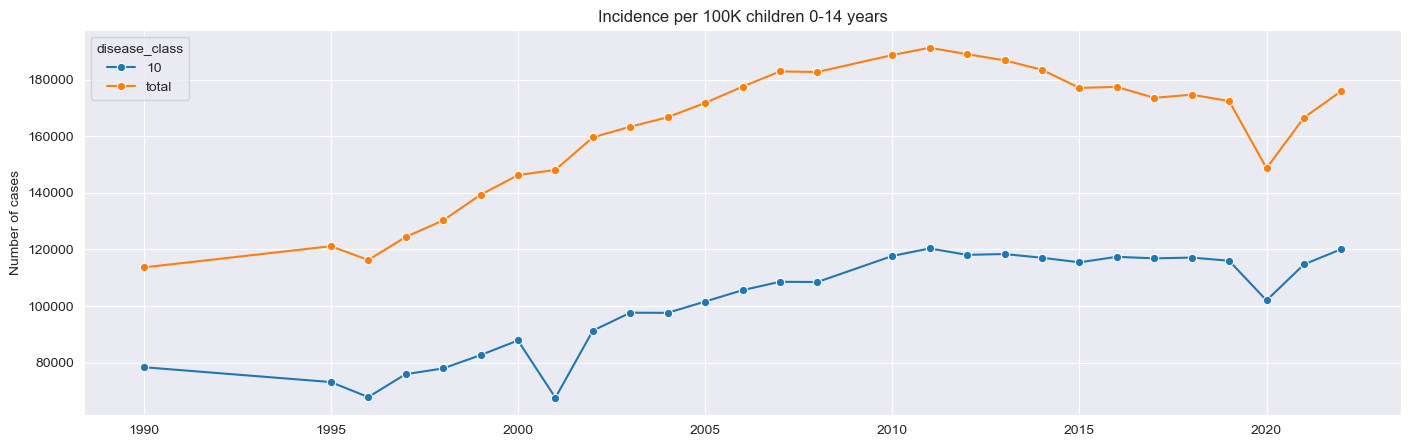

In [52]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_0_14_long.query('disease_class in ["total", "10"]'),
                x='year',
                y='total_per100k',
                hue='disease_class',
            marker='o')

plt.title('Incidence per 100K children 0-14 years')
plt.ylabel('Number of cases')
plt.xlabel(None)
plt.show()

The incidence of diseases in children has not increased since 2011. The impact of the COVID-19 pandemic is visible, and the trend in overall morbidity mirrors the trend in respiratory diseases, where a strange spike is observed in 2001.

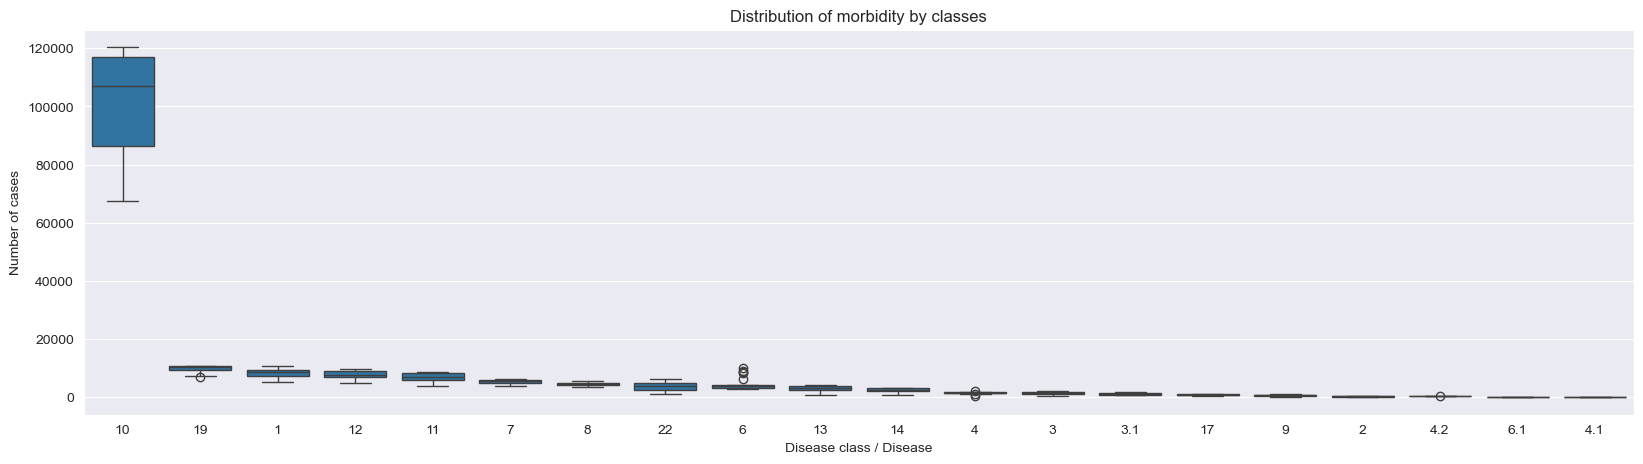

In [53]:
# boxplots

#calculate median cases by disease class
median_disease = df_0_14_long.query('disease_class !="total"').groupby('disease_class')['total_per100k'].median().sort_values(ascending=False)

#create boxplots ordered by median number of cases
plt.figure(figsize=(20,5))
sns.boxplot(data=df_0_14_long.query('disease_class !="total"'),
            x='disease_class',
            y='total_per100k',
            order=median_disease.index)

plt.title('Distribution of morbidity by classes')
plt.ylabel('Number of cases')
plt.xlabel('Disease class / Disease')
plt.show()

Let's take a look at the spike in respiratory diseases in 2001.

In [54]:
df_0_14_long.query('disease_class == "10" and year in [2000, 2001, 2002]')

,disease_class,year,total_abs,total_per100k
35,10,2000,22952.2,87805.6
36,10,2001,21859.2,67549.4
37,10,2002,21692.8,91256.4


The absolute values are similar, and the numbers in the original source are the same. We can recalculate the relative indicator based on the average number of children aged 0-14 years in 2001, which is 25,309,000.

In [55]:
print('2001. Total number of cases per 100K children')
print(round(21859.2 / 25309 * 100000, 1))

2001. Total number of cases per 100K children
86369.3


The year 2001 appears only once in statistical reports, so it is not possible to verify the value in other tables. The calculated number seems more accurate, let's use it.

In [56]:
# CHANGE VALUE
df_0_14_long.iloc[36, 3] = round(21859.2 / 25309 * 100000, 1)

- **Certain infectious and parasitic diseases (1); diseases of the digestive system (11); skin and subcutaneous tissue (12); injuries (19); COVID-19 (22)**

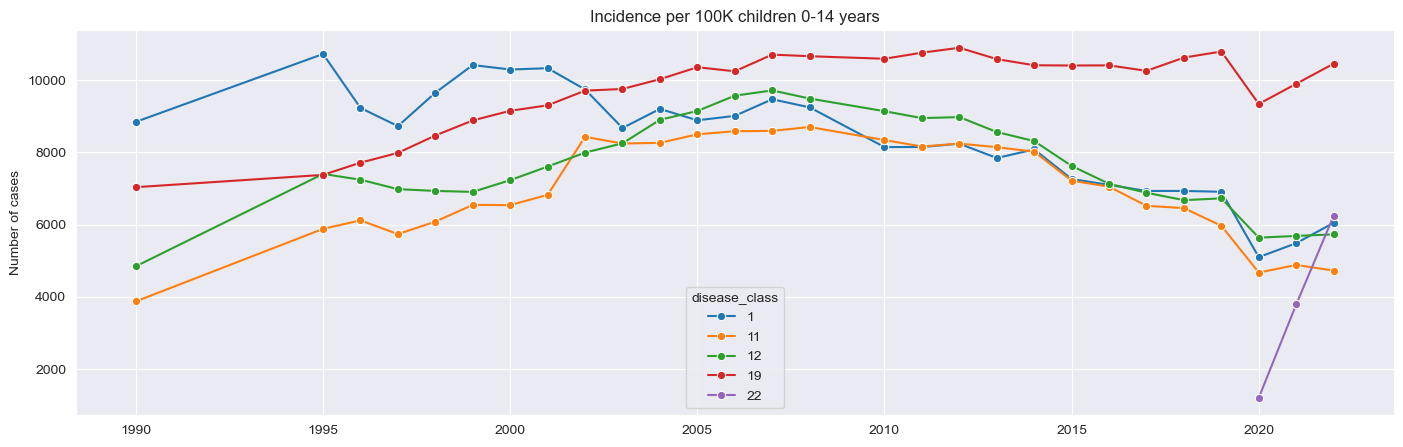

In [57]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_0_14_long.query('disease_class in ["19", "1", "12", "11", "22"]'),
                x='year',
                y='total_per100k',
                hue='disease_class',
            marker='o')

plt.title('Incidence per 100K children 0-14 years')
plt.ylabel('Number of cases')
plt.xlabel(None)
plt.show()

- **Diseases of the nervous system (6); eye and adnexa(7); ear and mastoid process(8); musculoskeletal system and connective tissue (13); genitourinary system(14)**

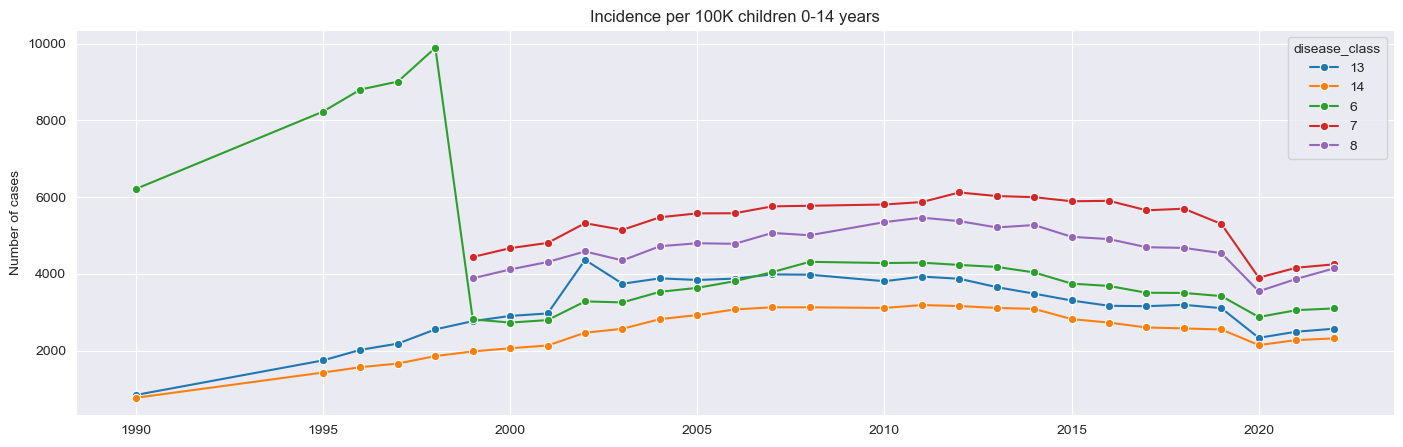

In [58]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_0_14_long.query('disease_class in ["6", "7", "8", "13", "14"]'),
                x='year',
                y='total_per100k',
                hue='disease_class',
            marker='o')

plt.title('Incidence per 100K children 0-14 years')
plt.ylabel('Number of cases')
plt.xlabel(None)
plt.show()

In 2002, an outlier in morbidity is observed for class 13.

In [59]:
df_0_14_long.query('disease_class in ["13"] and year in [2001, 2002, 2003]')

,disease_class,year,total_abs,total_per100k
123,13,2001,741.3,2969.0
124,13,2002,1037.9,4366.1
125,13,2003,850.5,3743.3


The outlier is seen in both absolute and relative values, and the numbers in the original source are the same. We can recalculate the relative indicator based on the average number of children aged 0-14 years in 2002, which is 24,128,000

In [60]:
print('2002: Total number of cases per 100K children')
1037.9 / 24128 * 100000

2002: Total number of cases per 100K children


4301.64124668435

The recalculated number differs from the one indicated, but the scale is similar, as there is also an outlier in the absolute value, so the data cannot be "corrected."

- **Diseases of the blood (3), including anemia (3.1); endocrine, nutritional, and metabolic diseases (4), including diabetes (4.1) and obesity (4.2)**

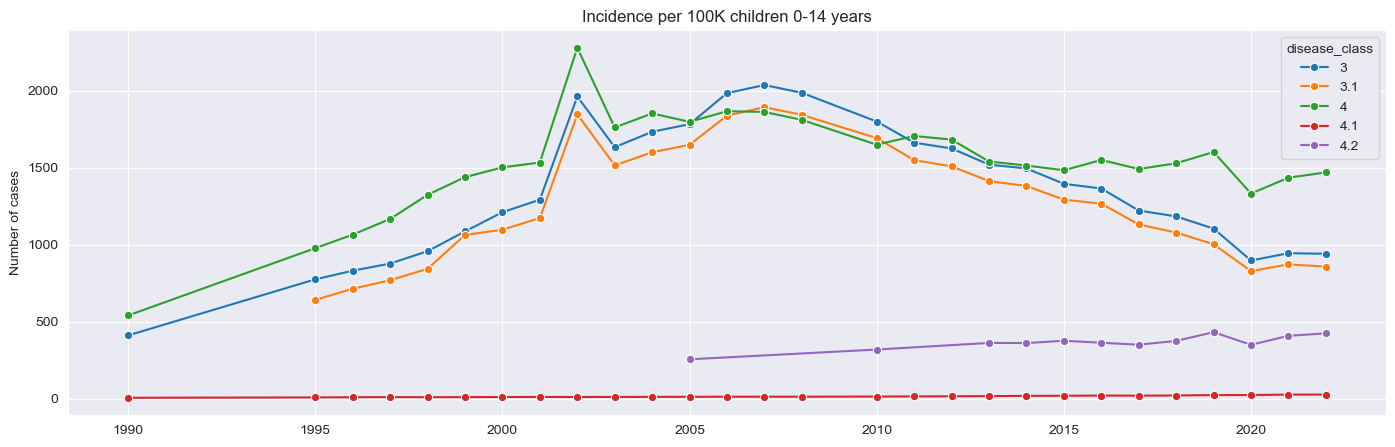

In [61]:
# scatter plot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_0_14_long.query('disease_class in ["3", "3.1", "4", "4.1", "4.2"]'),
                x='year',
                y='total_per100k',
                hue='disease_class',
            marker='o')

plt.title('Incidence per 100K children 0-14 years')
plt.ylabel('Number of cases')
plt.xlabel(None)
plt.show()

In [62]:
df_0_14_long.query('disease_class in ["3", "3.1", "4"] and year in [2001, 2002, 2003, 2004, 2005]')

,disease_class,year,total_abs,total_per100k
271,3,2001,322.5,1291.7
272,3,2002,466.2,1961.2
273,3,2003,370.9,1632.2
274,3,2004,279.0,1732.2
275,3,2005,382.1,1781.6
299,3.1,2001,292.8,1172.7
300,3.1,2002,438.5,1844.7
301,3.1,2003,344.1,1514.3
302,3.1,2004,349.9,1599.3
303,3.1,2005,353.3,1647.7


There is a strange spike in 2002—both in absolute values and per 100k children. However, there are no other tables for 2002, as it only appears in the 2005 report. Additionally, there is a strange drop in absolute morbidity values for blood diseases in 2004, but this drop is not reflected in the relative values. This value is repeated in other tables. We can estimate what it should have been, based on the relative indicators and the average number of children aged 0-14 years in 2004, which is 22,242,000.

In [63]:
print('2004: Total number of cases per 100K children')
1732.2 * 22242 / 100000

2004: Total number of cases per 100K children


385.275924

This number seems more correct, let's use it.

In [64]:
# CHANGE VALUE
df_0_14_long.iloc[274, 2] = round(1732.2 * 22242 / 100000, 1)

- **Diseases of the circulatory system (9); neoplasms (2); congenital malformations (17); cerebral palsy in children (6.1)**

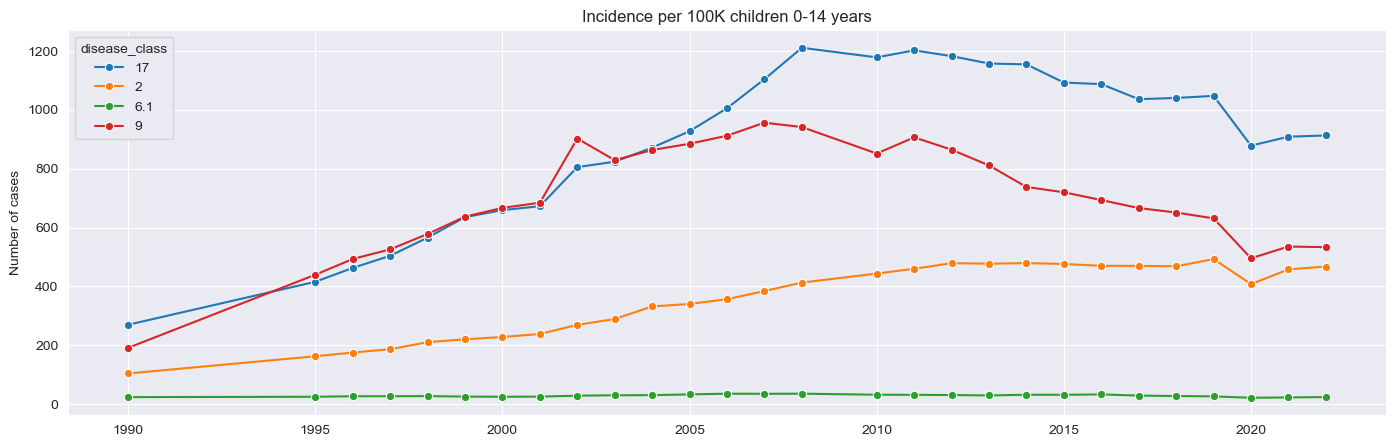

In [65]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_0_14_long.query('disease_class in ["2", "9", "17", "6.1"]'),
                x='year',
                y='total_per100k',
                hue='disease_class',
            marker='o')

plt.title('Incidence per 100K children 0-14 years')
plt.ylabel('Number of cases')
plt.xlabel(None)
plt.show()

For circulatory diseases, there is also a spike in 2002 in both absolute and relative values.

*In 2002, there were unusual spikes—increases across various diseases.*

### Adolescents Aged 15 to 17 Years

#### Data Load and Pre-Processing

In [66]:
# create dict of dataframes
data = {}

data['1990'] = read_table('2001', file_name='2_56_1991,1995-1998.csv', header=[1])
print('\033[1m1990\033[0m')
print('___________________')
display(data['1990'].head())

for year in years:
    print('\033[1m'+year+'\033[0m')
    print('___________________')

    if year == '2001':
        df = read_wide_table(year, file_name='2_56.csv', header=[2])
    elif year in ['2013', '2015', '2017', '2019', '2021']:
        df = read_table(year, file_name='2_56.csv', header=[0])
    else:
        df = read_table(year, file_name='2_56.csv', file_name2023='2_56-2_63.xlsx', sheet_name='2.56', header=[1])

    display(df.head())

    # add dataframe to the dict of dataframes
    data[year] = df

1990
___________________


,disease_class,1991,1995,1996,1997,1998,type
0,total,3612.5,4653.2,4548.2,49995.2,5418.0,total_abs
1,1,132.9,268.2,265.1,269.2,289.4,total_abs
2,2,4.2,8.5,9.7,11.2,13.1,total_abs
3,4,32.7,75.3,88.7,110.2,139.1,total_abs
4,4.1,0.8,1.0,1.0,1.0,1.0,total_abs


2001
___________________


,disease_class,1999,2000,type
0,total,6216.6,6621.0,total_abs
1,1,307.9,304.3,total_abs
2,2,15.5,16.9,total_abs
3,3,30.7,36.2,total_abs
4,3.1,26.6,31.8,total_abs


2005
___________________


,disease_class,2000,2001,2002,2003,2004,type
0,total,6621.0,6834.9,7354.7,7814.9,7802.3,total_abs
1,1,304.3,326.1,307.2,282.0,300.9,total_abs
2,2,16.9,17.6,17.4,18.7,21.7,total_abs
3,3,36.2,37.4,47.9,44.5,45.4,total_abs
4,3.1,31.8,33.0,43.3,40.3,41.0,total_abs


2007
___________________


,disease_class,2000,2003,2004,2005,2006,type
0,total,6621.0,7814.9,7802.3,7730.2,7593.2,total_abs
1,1,304.3,282.0,300.9,292.3,284.0,total_abs
2,2,16.9,18.7,21.7,21.7,20.3,total_abs
3,3,36.2,44.5,45.4,46.7,49.1,total_abs
4,3.1,31.8,40.3,41.0,41.6,44.0,total_abs


2009
___________________


,disease_class,2000,2005,2006,2007,2008,type
0,total,6621.0,7730.2,7593.2,7238.6,6589.4,total_abs
1,1,304.3,292.3,284.0,250.6,225.2,total_abs
2,2,16.9,21.7,20.3,20.1,17.9,total_abs
3,3,36.2,46.7,49.1,47.7,44.3,total_abs
4,3.1,31.8,41.6,44.0,43.4,40.3,total_abs


2011
___________________


,disease_class,2000,2005,2009,2010,type
0,total,6621.0,7730.2,6751.8,6266.8,total_abs
1,1,304.3,292.3,196.7,183.8,total_abs
2,2,16.9,21.7,17.6,17.8,total_abs
3,3,36.2,46.7,42.1,38.5,total_abs
4,3.1,31.8,41.6,38.9,35.7,total_abs


2013
___________________


,disease_class,2000,2005,2010,2011,2012,type
0,total,"6621,0","7730,2","6266,8","6204,7","6016,9",total_abs
1,1,"304,3","292,3","183,8","176,9","166,9",total_abs
2,2,"16,9","21,7","17,8","17,7","18,1",total_abs
3,3,"36,2","46,7","38,5","37,4","36,8",total_abs
4,3.1,"31,8","41,6","35,7","33,1","33,8",total_abs


2015
___________________


,disease_class,2005,2010,2011,2012,2013,2014,type
0,total,"7730,2","6266,8","6204,7","6016,9","5813,3","5675,3",total_abs
1,1,"292,3","183,8","176,9","166,9","156,0","158,6",total_abs
2,2,"21,7","17,8","17,7","18,1","18,2","19,0",total_abs
3,3,"46,7","38,5","37,4","36,8","39,7","38,7",total_abs
4,3.1,"41,6","35,7","33,1","33,8","35,6","33,9",total_abs


2017
___________________


,disease_class,2005,2010,2013,2014,2015,2016,type
0,total,"7730,2","6266,8","5813,3","5675,3","5492,9","5529,4",total_abs
1,1,"292,3","183,8","156,0","158,6","140,5","138,8",total_abs
2,2,"21,7","17,8","18,2","19,0","20,0","18,9",total_abs
3,3,"46,7","38,5","39,7","38,7","36,3","37,4",total_abs
4,3.1,"41,6","35,7","35,6","33,9","33,6","34,4",total_abs


2019
___________________


,disease_class,2005,2010,2015,2016,2017,2018,type
0,total,"7730,2","6266,8","5492,9","5529,4","5568,8","5737,3",total_abs
1,1,"292,3","183,8","140,5","138,8","136,4","144,2",total_abs
2,2,"21,7","17,8","20,0","18,9","19,9","22,2",total_abs
3,3,"46,7","38,5","36,3","37,4","35,9","36,6",total_abs
4,3.1,"41,6","35,7","33,6","34,4","30,9","32,4",total_abs


2021
___________________


,disease_class,2005,2010,2015,2018,2019,2020,type
0,total,"7 730,2","6 266,8","5 492,9","5 737,3","5 859,5","5 441,8",total_abs
1,1,"2 92,3","183,8","140,5","144,2","141,8","115,8",total_abs
2,2,"21,7","17,8","20,0","22,2","23,8","20,7",total_abs
3,3,"46,7","38,5","36,3","36,6","35,9","30,5",total_abs
4,3.1,"41,6","35,7","33,6","32,4","32,4","28,0",total_abs


2023
___________________


,disease_class,2010,2015,2019,2020,2021,2022,type
0,total,"6 266,8","5 492,9","5 859,5","5 441,8",6164.3,6706.1,total_abs
1,1,183.8,140.5,141.8,115.8,123.7,136.1,total_abs
2,2,17.8,20,23.8,20.7,23.2,24.4,total_abs
3,3,38.5,36.3,35.9,30.5,34.3,39.2,total_abs
4,3.1,35.7,33.6,32.4,28,31.6,35.4,total_abs


In [67]:
# merge data
df_15_17 = (data['2023']
          .merge(data['2021'].drop(columns=['2020', '2019', '2015', '2010']), how='outer', on=['disease_class', 'type'])
          .merge(data['2019'].drop(columns=['2018', '2015', '2010', '2005']), how='outer', on=['disease_class', 'type'])
          .merge(data['2017'].drop(columns=['2016', '2015', '2010', '2005']), how='outer', on=['disease_class', 'type'])
          .merge(data['2015'].drop(columns=['2014', '2013', '2010', '2005']), how='outer', on=['disease_class', 'type'])
          .merge(data['2011'].drop(columns=['2010', '2005', '2000']), how='outer', on=['disease_class', 'type'])
          .merge(data['2009'].drop(columns=['2005']), how='outer', on=['disease_class', 'type'])
          .merge(data['2007'].drop(columns=['2000', '2005', '2006']), how='outer', on=['disease_class', 'type'])
          .merge(data['2005'].drop(columns=['2000', '2003', '2004']), how='outer', on=['disease_class', 'type'])
          .merge(data['2001'].drop(columns=['2000']), how='outer', on=['disease_class', 'type'])
          .merge(data['1990'], how='outer', on=['disease_class', 'type'])
         )

# new order of columns
new_order = ['disease_class', 'type', 
             '1991', '1995', '1996',
             '1997', '1998', '1999',
             '2000', '2001', '2002',
             '2003', '2004', '2005',
             '2006', '2007', '2008',
             '2009', '2010', '2011',
             '2012', '2013', '2014',
             '2015', '2016', '2017',
             '2018', '2019', '2020',
             '2021', '2022']

# reorder the DataFrame
df_15_17 = df_15_17[new_order]
df_15_17

,disease_class,type,1991,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,total,total_abs,3612.5,4653.2,4548.2,49995.2,5418.0,6216.6,6621.0,6834.9,7354.7,7814.9,7802.3,"7 730,2",7593.2,7238.6,6589.4,6751.8,"6 266,8","6204,7","6016,9","5813,3","5675,3","5 492,9","5529,4","5568,8","5 737,3","5 859,5","5 441,8",6164.3,6706.1
1,1,total_abs,132.9,268.2,265.1,269.2,289.4,307.9,304.3,326.1,307.2,282.0,300.9,"2 92,3",284.0,250.6,225.2,196.7,183.8,"176,9","166,9","156,0","158,6",140.5,"138,8","136,4","144,2",141.8,115.8,123.7,136.1
2,2,total_abs,4.2,8.5,9.7,11.2,13.1,15.5,16.9,17.6,17.4,18.7,21.7,"21,7",20.3,20.1,17.9,17.6,17.8,"17,7","18,1","18,2","19,0",20,"18,9","19,9","22,2",23.8,20.7,23.2,24.4
3,3,total_abs,6.9,18.6,20.5,24.8,27.9,30.7,36.2,37.4,47.9,44.5,45.4,"46,7",49.1,47.7,44.3,42.1,38.5,"37,4","36,8","39,7","38,7",36.3,"37,4","35,9","36,6",35.9,30.5,34.3,39.2
4,3.1,total_abs,4.8,14.9,16.3,20.1,23.4,26.6,31.8,33.0,43.3,40.3,41.0,"41,6",44.0,43.4,40.3,38.9,35.7,"33,1","33,8","35,6","33,9",33.6,"34,4","30,9","32,4",32.4,28,31.6,35.4
5,4,total_abs,32.7,75.3,88.7,110.2,139.1,159.8,162.4,169.1,208.3,185.2,185.0,"168,8",156.5,147.9,133.3,120.6,116.2,"109,4","110,6","104,7","105,9",113.6,"113,4","113,8","117,6",131.1,104.5,124.8,134.4
6,4.1,total_abs,0.8,1.0,1.0,1.0,1.0,1.1,1.0,1.1,1.1,1.0,1.0,"1,1",1.0,1.0,0.8,0.8,0.8,"0,8","0,8","0,9","0,9",1.1,"1,3","1,3","1,3",1.3,1.4,1.6,1.6
7,4.2,total_abs,8.5,9.2,10.3,11.7,12.6,11.6,11.7,12.9,19.1,18.7,20.0,"20,1",21.6,21.7,21.8,20.8,21.4,"22,6","23,4","23,6","25,6",29.3,"29,5","29,7","32,2",38.8,31.6,37.1,40.2
8,6,total_abs,207.7,344.3,381.0,400.4,455.5,154.2,153.2,170.7,197.1,198.1,208.4,"212,8",211.6,203.7,195.5,181.2,176.9,"174,2","173,6","170,3","168,1",157.4,"155,7","155,4","159,5",165.7,141.3,159.6,169.5
9,6.1,total_abs,0.5,0.5,0.7,0.6,0.8,0.6,0.8,0.8,1.1,1.1,1.0,"1,0",0.9,0.7,0.6,0.4,0.4,"0,4","0,4","0,4","0,4",0.6,"0,7","0,8","0,8",0.7,0.6,–,–


In [68]:
# convert the cleaned data to long format
df_15_17_long = df_long_clean(df_15_17)
df_15_17_long

,disease_class,year,total_abs,total_per100k
0,1,1991,132.9,2124.7
1,1,1995,268.2,4092.7
2,1,1996,265.1,4031.5
3,1,1997,269.2,4022.6
4,1,1998,289.4,4188.1
...,...,...,...,...
653,total,2018,5737.3,136020.2
654,total,2019,5859.5,131672.9
655,total,2020,5441.8,120336.8
656,total,2021,6164.3,136490.5


In [69]:
print('\033[1mNumber of missing values\033[0m')
df_15_17_long.isna().sum()

Number of missing values


disease_class     0
year              0
total_abs         0
total_per100k    23
dtype: int64

In [70]:
df_15_17_long[df_15_17_long.total_per100k.isna()].year.value_counts()

year
2009    23
Name: count, dtype: int64

It is also evident that relative data is missing only for the year 2009.

#### EDA

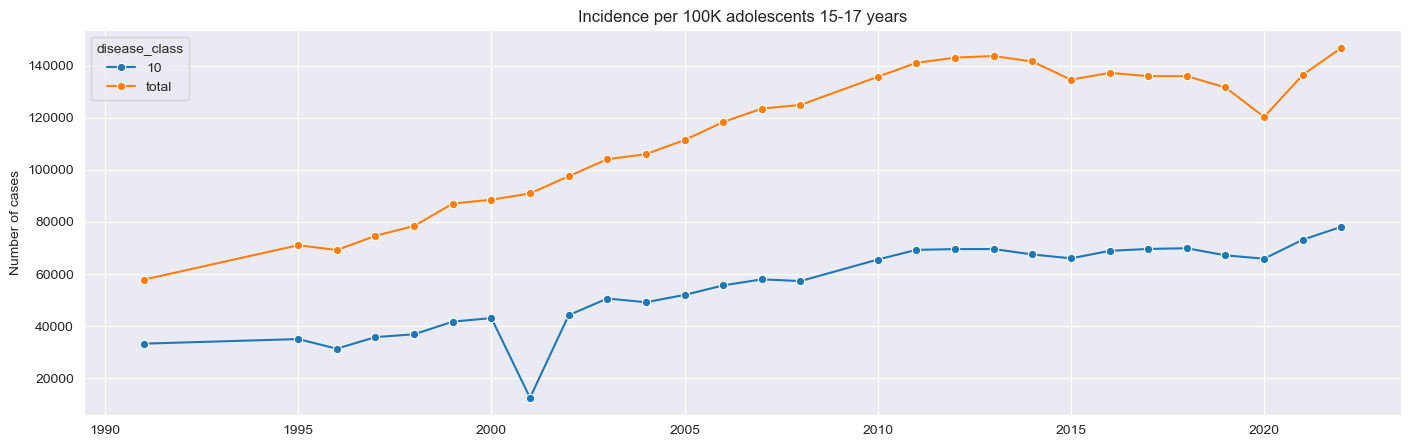

In [71]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_15_17_long.query('disease_class in ["total", "10"]'),
                x='year',
                y='total_per100k',
                hue='disease_class',
            marker='o')

plt.title('Incidence per 100K adolescents 15-17 years')
plt.ylabel('Number of cases')
plt.xlabel(None)
plt.show()

The incidence in diseases in adolescents has also not increased since 2011. The COVID-19 pandemic is evident, and the trend in overall morbidity mirrors the trend in respiratory diseases, where a strange spike is observed in 2001.

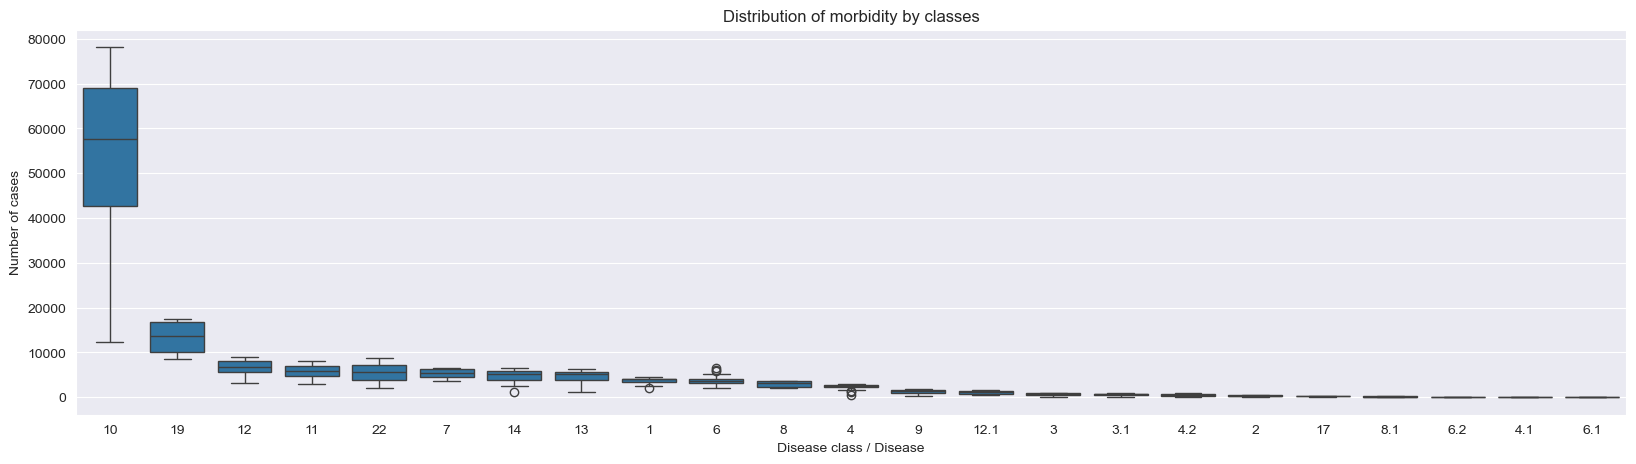

In [72]:
# boxplots

#calculate median cases by disease class
median_disease = df_15_17_long.query('disease_class !="total"').groupby('disease_class')['total_per100k'].median().sort_values(ascending=False)

#create boxplots ordered by median number of cases
plt.figure(figsize=(20,5))
sns.boxplot(data=df_15_17_long.query('disease_class !="total"'),
            x='disease_class',
            y='total_per100k',
            order=median_disease.index)

plt.title('Distribution of morbidity by classes')
plt.ylabel('Number of cases')
plt.xlabel('Disease class / Disease')
plt.show()

Let's examine the spike in respiratory diseases in 2001.

In [73]:
df_15_17_long.query('disease_class in ["10"] and year in [2000, 2001, 2002]')

,disease_class,year,total_abs,total_per100k
35,10,2000,3217.4,43012.2
36,10,2001,3185.3,12368.1
37,10,2002,3326.1,44107.4


The absolute values are similar, and the numbers in the original source are the same. We can recalculate the relative indicator based on the average number of adolescents aged 15-17 years in 2001, which is 7,583,000.

In [74]:
print('2001. Total number of cases per 100K adolescents')
round(3185.3 / 7583 * 100000, 1)

2001. Total number of cases per 100K adolescents


42005.8

The year 2001 appears only once in the statistical reports, so the value cannot be verified in other tables. The calculated number seems more accurate, let's use it.

In [75]:
# CHANGE VALUES
df_15_17_long.iloc[26, 3] = 42005.8

- **Certain infectious and parasitic diseases (1); diseases of the digestive system (11), skin and subcutaneous tissue (12), injuries (19), COVID (22)**

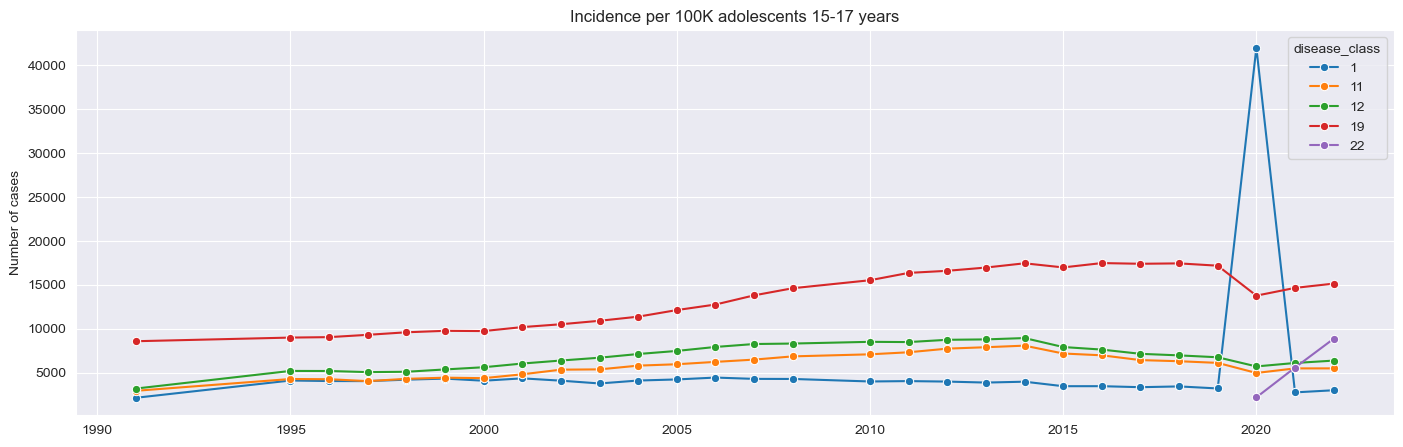

In [76]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_15_17_long.query('disease_class in ["19", "1", "12", "11", "22"]'),
                x='year',
                y='total_per100k',
                hue='disease_class',
            marker='o')

plt.title('Incidence per 100K adolescents 15-17 years')
plt.ylabel('Number of cases')
plt.xlabel(None)
plt.show()

- **Diseases of the nervous system (6); eye and adnexa (7); ear and mastoid process (8); musculoskeletal system and connective tissue (13); genitourinary system (14)**

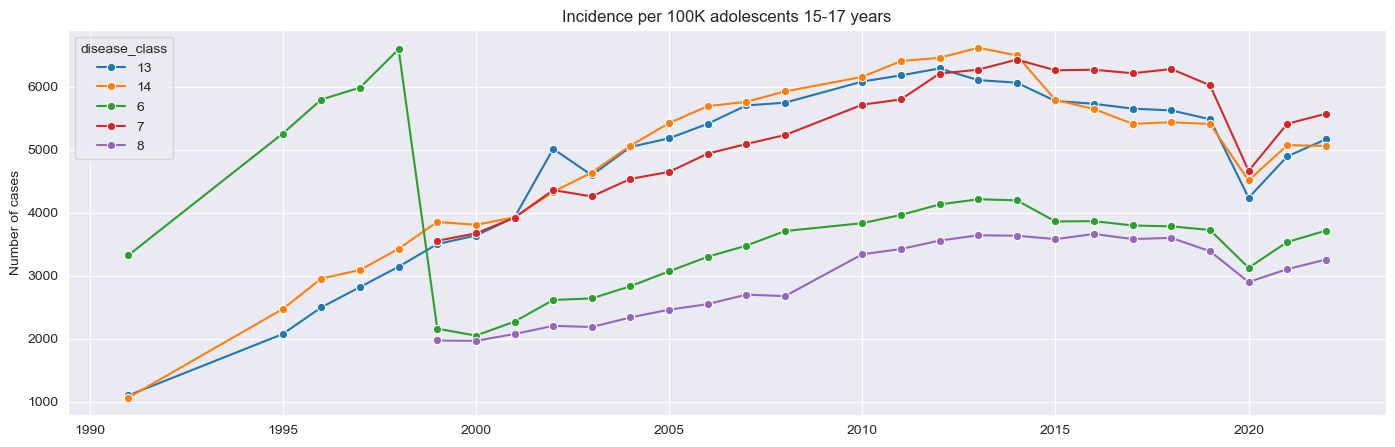

In [77]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_15_17_long.query('disease_class in ["6", "7", "8", "13", "14"]'),
                x='year',
                y='total_per100k',
                hue='disease_class',
            marker='o')

plt.title('Incidence per 100K adolescents 15-17 years')
plt.ylabel('Number of cases')
plt.xlabel(None)
plt.show()

For diseases in class 13, there is also a spike in 2002 in both absolute and relative values.

- **Diseases of the blood (3), including anemia (3.1); endocrine, nutritional, and metabolic diseases (4), including diabetes (4.1) and obesity (4.2)**

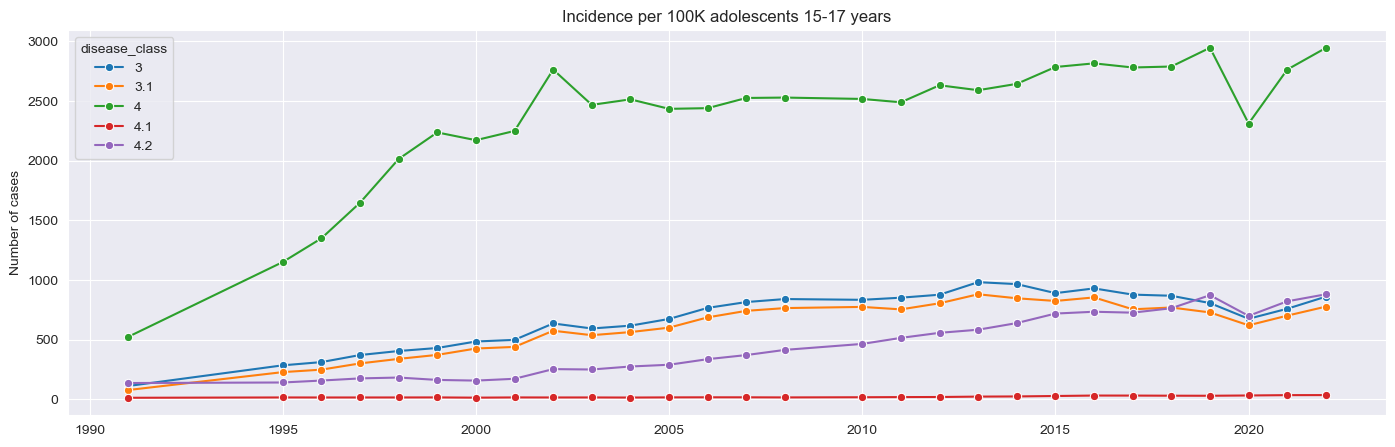

In [78]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_15_17_long.query('disease_class in ["3", "3.1", "4", "4.1", "4.2"]'),
                x='year',
                y='total_per100k',
                hue='disease_class',
            marker='o')

plt.title('Incidence per 100K adolescents 15-17 years')
plt.ylabel('Number of cases')
plt.xlabel(None)
plt.show()

Again, a rise is visible in 2002 for diseases in classes 3, 3.1, and 4.

- **Circulatory diseases (9); contact dermatitis (12.1); neoplasms (2); nongenital malformations (17)**

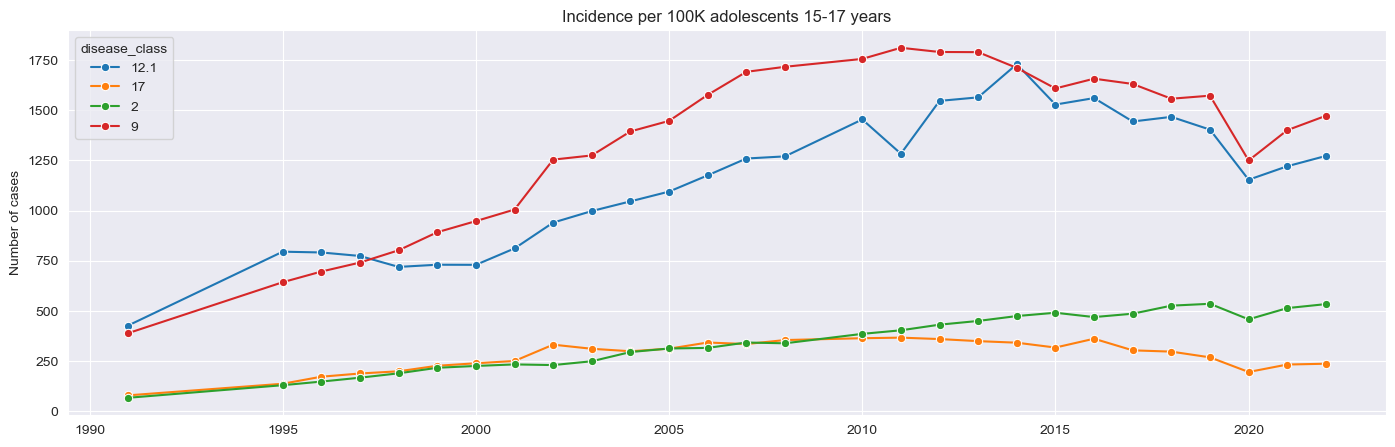

In [79]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_15_17_long.query('disease_class in ["9", "12.1", "2", "17"]'),
                x='year',
                y='total_per100k',
                hue='disease_class',
            marker='o')

plt.title('Incidence per 100K adolescents 15-17 years')
plt.ylabel('Number of cases')
plt.xlabel(None)
plt.show()

- **Epilepsy (6.2); cerebral palsy in children (6.1); chronic otitis (8.1)**

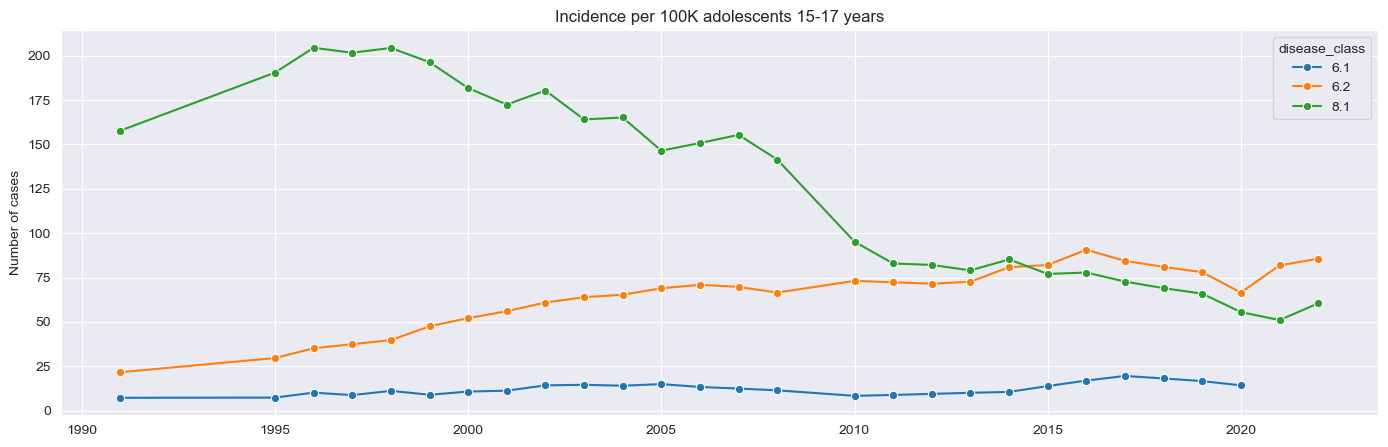

In [80]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_15_17_long.query('disease_class in ["6.1", "6.2", "8.1"]'),
                x='year',
                y='total_per100k',
                hue='disease_class',
            marker='o')

plt.title('Incidence per 100K adolescents 15-17 years')
plt.ylabel('Number of cases')
plt.xlabel(None)
plt.show()

### Export and Merge DataFrames

Let's save the DataFrames as .csv files

In [81]:
# saving dataframes to CSV files
df_adult_long.to_csv('disease_classes_all.csv', index=False)
df_1y_long.to_csv('disease_classes_babies.csv', index=False)
df_0_14_long.to_csv('disease_classes_children.csv', index=False)
df_15_17_long.to_csv('disease_classes_teens.csv', index=False)

Let's also create merged DataFrame with all age groups

In [82]:
# add 'age' suffixes
df_adult_long.columns =  ['disease_class', 'year'] + [col + '_all' for col in df_adult_long.columns[2:]]
df_1y_long.columns =  ['disease_class', 'year'] + [col + '_1y' for col in df_1y_long.columns[2:]]
df_0_14_long.columns =  ['disease_class', 'year'] + [col + '_child' for col in df_0_14_long.columns[2:]]
df_15_17_long.columns =  ['disease_class', 'year'] + [col + '_teen' for col in df_15_17_long.columns[2:]]

In [83]:
# merge data
disease_classes = (df_adult_long.merge(df_1y_long, how='outer', on=['disease_class', 'year'])
                   .merge(df_0_14_long, how='outer', on=['disease_class', 'year'])
                   .merge(df_15_17_long, how='outer', on=['disease_class', 'year'])
                  )

In [84]:
disease_classes

,disease_class,year,first_abs_all,first_per100k_all,total_abs_all,total_per100k_all,total_abs_1y,total_per100k_1y,total_abs_child,total_per100k_child,total_abs_teen,total_per100k_teen
0,1,1990,5165.4,3492.2,7610.4,5145.2,NaN,NaN,3002.7,8841.6,NaN,NaN
1,1,1995,6983.3,4725.7,9268.8,6272.3,127.9,104.4,3361.3,10717.6,268.2,4092.7
2,1,1996,6399.1,4367.7,8843.9,6036.3,109.3,94.6,2790.0,9225.9,265.1,4031.5
3,1,1997,6157.4,4213.4,8720.4,5967.3,102.1,87.4,2554.9,8723.6,269.2,4022.6
4,1,1998,6414.7,4401.3,9021.1,6189.6,104.0,91.8,2718.6,9647.1,289.4,4188.1
...,...,...,...,...,...,...,...,...,...,...,...,...
943,8.1,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.9,65.9
944,8.1,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,55.5
945,8.1,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.3,51.0
946,8.1,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.8,60.4


### Errors / Outliers
It is worth noting that the data contain outliers — mainly in the calculation of relative values. If the absolute values in consecutive years are similar, but there is an outlier in the relative values, it is most likely an error. Depending on the research goals and data usage, these values can be recalculated using demographic data.

Report 2001:
- Table 2_1 ("Population Morbidity by Major Classes, Groups, and Specific Diseases"):
    - 1999: Values for disease classes 10 and 11 were swapped in the rate per 100,000 population (absolute values are correct) -> **corrected by swapping**.
    - 1997: Outlier (drop) in the rate per 100,000 population for diabetes (4.1) (absolute values are correct) -> **recalculated based on the average population in 1997**.

Report 2005:
- Table 2_1:
    - 2002: Outliers (spikes) in both absolute and relative values for disease classes 3, 3.1.
- Table 2_42 ("Morbidity of Children Under 1 Year Old by Major Classes and Groups of Diseases"):
    - 2002: Outliers (spikes) in both absolute and relative values for disease classes 3, 3.1.
- Table 2_45 ("Morbidity of Children Aged 0–14 by Major Classes and Groups of Diseases"):
    - 2001: Outlier (drop ) in rate per 100,000 children for disease class 10 (absolute values are correct) -> **recalculated based on the average number of children aged 0-14 in 2001**.
    - 2002: Outliers (spikes) in both absolute and relative values for disease classes 13, 3, 3.1, 4, 9.
        2004: Drop in absolute values for class 3 (relative values are correct) -> **recalculated based on relative values and the average number of children aged 0-14 in 2004**.
- Table 2_56 ("Morbidity of Children Aged 15–17 by Major Classes and Groups of Diseases"):
    - 2001: Outlier (drop) in rate per 100,000 adolescents for disease class 10 (absolute values are correct) -> **recalculated based on the average number of adolescents aged 15-17 in 2001.**
    - 2002: Outliers (spikes) in both absolute and relative values for disease classes 13, 3, 3.1, 4.

Report 2007:
- Table 2_1:
    - 2006: Outlier (drop) in rate per 100,000 people and per 100,000 first-time cases for disease class 15 (absolute values are correct) -> **recalculated based on the number of women aged 15-49 in 2006.**
- Table 2_45:
    - 2003: Outlier (drop) in the absolute value for disease class 8 (98.9 instead of 998.6 in the 2005 report) -> **typo, data taken from the 2005 report.**
    - 2004: Outlier (spike) in rate per 100,000 people for disease class 4 (18,541.4 instead of 1,851.4 as in the 2005 report) -> **typo, data taken from the 2005 report.**
    - 2004: Outlier (drop) in absolute values for disease class 3 (relative values are correct) -> **data taken from the 2005 report.**

### Observations

It is evident that morbidity rates per 100,000 people are higher in children, particularly in those under one year old. The impact of the COVID-19 pandemic is clearly visible.

**The largest morbidity is observed in the following disease classes:**
- For the entire population: Respiratory diseases, circulatory system diseases, musculoskeletal system diseases.
- For children under one year old: Respiratory diseases by a large margin, conditions arising in the perinatal period, and nervous system diseases.
- For children aged 0–14: Respiratory diseases by a large margin, followed by relatively similar rates for injuries, skin diseases, infections, and digestive system diseases.
- For adolescents aged 15–17: Respiratory diseases by a large margin, followed by a higher incidence of injuries, skin diseases, digestive system diseases, and eye diseases.

**Morbidity dynamic in 1995-2022 years**
- For the entire population:
    - The largest increase is observed in diseases characterized by high blood pressure and endocrine, nutritional, and metabolic diseases, particularly diabetes.
    - The greatest decline is seen in peptic ulcer disease, infectious and parasitic diseases, and diseases related to pregnancy, childbirth, and the postpartum period.
- For children under one year old:
    - There appears to be some growth in congenital anomalies (malformations), deformations, and chromosomal disorders.
    - The largest decline is seen in endocrine, nutritional, and metabolic diseases, especially rickets, as well as some infectious and parasitic diseases, particularly intestinal infections.
- For children aged 0–14 years, morbidity across many categories is decreasing:
    - The largest growth is seen in diabetes, with some increase in obesity.
    - The greatest decline is observed in blood diseases (particularly anemia), as well as digestive and circulatory system diseases.
- For adolescents aged 15–17 years, morbidity across many categories remains relatively stable:
    - The largest increases are in diabetes, obesity, and neoplasms.
    - The greatest declines are observed in chronic otitis and congenital anomalies.

## Diseases Leading to Temporary Disability

### Data Load and Pre-Processing
These data are available only starting from 2012. It include number of cases and total number of days of temporal disability by reason of disability. Let's begin with collecting data from various years into a single dataframe.

The names of disease classes in tables from different years appear in a different order, slightly differ, or contain special characters, Latin letters, etc. Let's replace the names with class numbers using a dictionary with keywords.

In [85]:
class_dict = {'паразит': '1',
             'новообр': '2',
             'крови': '3',
             'эндокрин': '4', 'сахар': '4.1',
             'психич': '5',
             'нервн': '6',
             'глаз': '7',
             'уха': '8',
             'кровообр': '9', 'ишемич': '9.2', 'цереброваск': '9.3',
             'дыхан': '10',
             'пищеварен': '11', 
             'кожи': '12',
             'костно': '13',
             'мочепол': '14',
             'период': '15', 
             'аномалии': '17',
             'травмы': '19',
             'vid-19': '22', 
             'всего': 'total',
             'уход': 'care for sick',
             'отпуск': 'maternity leave'}

The tables have different formats in different years. Let's write function to read files of different types.

In [86]:
def read_table(year, file_name='2_2.csv', file_name2023='2_1-2_13.xlsx', sheet_name='2.2', header=[2]):

    """
    Input: year, file_name, file_name2023, sheet_name, and header 
    - the row from which to take the column names.
    Function reads the file, formats the names of disease classes, 
    and replaces them with numbers. 
    Output: DataFrame with disease class numbers, incidence by year, 
    and type - number of cases or days of disability.
    """

    # read csv/excel file
    if year == '2023':
        df = pd.read_excel(os.path.join(*[PATH_data], year, file_name2023), sheet_name=sheet_name, header=header)
        df.columns = df.columns.astype(str)
    else:
        df = pd.read_csv(os.path.join(*[PATH_data], year, file_name), header=header, encoding='utf-8')
    
    df = (df.drop(0)
            .rename(columns={df.columns[0]: 'disease_class'})
            .dropna(subset=df.columns[1:], how='all')
            .dropna(subset='disease_class'))

    # format disease names
    table = str.maketrans('acexopcyx', 'асехорсух')
    df['disease_class'] = (df['disease_class']
                           .str.lower()
                           .str.translate(table)
                           .str.replace('- ', ''))

    # change disease class names into numbers
    for k,v in class_dict.items():
        df['disease_class'] = np.where(df['disease_class'].str.contains(k, case=False), v, df['disease_class'])
    
    df = df[~df['disease_class'].str.contains("из", na=False)]
    df = df[~df['disease_class'].str.contains("кроме", na=False)].reset_index(drop=True)
    
    # split the dataframe into two parts
    split_point = int((df.shape[1]-1)/2)
    df_cases = df.iloc[:, 0:-split_point]
    df_cases['type'] = 'disability_cases'
    
    df_days = df.iloc[:, [0]+list(range(-split_point, 0))]
    df_days['type'] = 'disability_days'
    df_days.columns = df_cases.columns

    df = pd.concat([df_cases, df_days], axis=0).reset_index(drop=True)

    return df

In [87]:
# create dict of dataframes
data = {}

for year in ['2015', '2017', '2019', '2021', '2023']:
    print('\033[1m'+year+'\033[0m')
    print('___________________')
    
    df = read_table(year)

    display(df.head())

    # add dataframe to the dict of dataframes
    data[year] = df

2015
___________________


,disease_class,2012,2013,2014,type
0,total,2.1424e+07,21184534,20072505,disability_cases
1,1,3.4222e+05,311131,313176,disability_cases
2,2,5.3021e+05,528744,536773,disability_cases
3,3,5.3318e+04,49528,48351,disability_cases
4,4,1.3696e+05,128592,127962,disability_cases


2017
___________________


,disease_class,2014,2015,2016,type
0,total,20072505,1.9649e+07,1.9532e+07,disability_cases
1,1,313176,2.8957e+05,2.8749e+05,disability_cases
2,2,536773,5.3494e+05,5.3543e+05,disability_cases
3,3,48351,4.9438e+04,4.8904e+04,disability_cases
4,4,127962,1.2570e+05,1.1890e+05,disability_cases


2019
___________________


,disease_class,2015,2017,2018,type
0,total,19648688,1.9443e+07,1.9578e+07,disability_cases
1,1,289572,2.8539e+05,2.8589e+05,disability_cases
2,2,534945,5.3466e+05,5.4085e+05,disability_cases
3,3,49438,4.9618e+04,4.9998e+04,disability_cases
4,4,125701,1.1926e+05,1.1895e+05,disability_cases


2021
___________________


,disease_class,2015,2019,2020,type
0,total,19 648 688,19 005 988,23 205 130,disability_cases
1,1,289 572,269 394,224 983,disability_cases
2,2,53 4945,542 841,446 891,disability_cases
3,3,49 438,48 065,41 461,disability_cases
4,4,125 701,114 651,88 716,disability_cases


2023
___________________


,disease_class,2020,2021,2022,type
0,total,23 205 130,26 289 108,2.9278e+07,disability_cases
1,1,224 983,226444,2.8498e+05,disability_cases
2,2,446 891,493938,5.9210e+05,disability_cases
3,3,41 461,52894,6.0580e+04,disability_cases
4,4,88 716,93081,1.1084e+05,disability_cases


In [88]:
# merge data
df_disability = (data['2015']
                 .merge(data['2017'].drop(columns=['2014']), how='outer', on=['disease_class', 'type'])
                 .merge(data['2019'].drop(columns=['2015']), how='outer', on=['disease_class', 'type'])
                 .merge(data['2021'].drop(columns=['2015']), how='outer', on=['disease_class', 'type'])
                 .merge(data['2023'].drop(columns=['2020']), how='outer', on=['disease_class', 'type'])
                )

# new order of columns
new_order = ['disease_class', 'type', 
             '2012', '2013', '2014',
             '2015', '2016', '2017',
             '2018', '2019', '2020',
             '2021', '2022']

# reorder the DataFrame
df_disability = df_disability[new_order]
df_disability

,disease_class,type,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,total,disability_cases,2.1424e+07,21184534,20072505,1.9649e+07,1.9532e+07,1.9443e+07,1.9578e+07,19 005 988,23 205 130,26 289 108,2.9278e+07
1,1,disability_cases,3.4222e+05,311131,313176,2.8957e+05,2.8749e+05,2.8539e+05,2.8589e+05,269 394,224 983,226444,2.8498e+05
2,2,disability_cases,5.3021e+05,528744,536773,5.3494e+05,5.3543e+05,5.3466e+05,5.4085e+05,542 841,446 891,493938,5.9210e+05
3,3,disability_cases,5.3318e+04,49528,48351,4.9438e+04,4.8904e+04,4.9618e+04,4.9998e+04,48 065,41 461,52894,6.0580e+04
4,4,disability_cases,1.3696e+05,128592,127962,1.2570e+05,1.1890e+05,1.1926e+05,1.1895e+05,114 651,88 716,93081,1.1084e+05
5,4.1,disability_cases,5.1718e+04,89749,89618,8.6311e+04,8.2881e+04,8.5240e+04,8.4887e+04,82 066,62 223,65129,7.9984e+04
6,5,disability_cases,1.6941e+05,151954,143423,1.3093e+05,1.1928e+05,1.1324e+05,1.0961e+05,108 419,87 512,93303,9.4259e+04
7,6,disability_cases,4.4891e+05,417395,410592,3.9077e+05,3.8612e+05,3.8772e+05,3.9805e+05,392 287,356 353,407497,4.3914e+05
8,7,disability_cases,3.2551e+05,311855,315248,2.9622e+05,2.8537e+05,2.8659e+05,2.8608e+05,280 522,230 149,256111,2.8220e+05
9,8,disability_cases,2.1291e+05,195617,185760,1.7043e+05,1.6389e+05,1.5936e+05,1.5938e+05,147 329,129 770,135299,1.4906e+05


In [89]:
# transform dataframe into the long format
df_disability_long = df_long_clean(df_disability)
df_disability_long

,disease_class,year,disability_cases,disability_days
0,1,2012,3.4222e+05,8.2334e+06
1,1,2013,3.1113e+05,7.6296e+06
2,1,2014,3.1318e+05,7.4937e+06
3,1,2015,2.8957e+05,7.0557e+06
4,1,2016,2.8749e+05,6.7725e+06
...,...,...,...,...
249,total,2018,1.9578e+07,2.6252e+08
250,total,2019,1.9006e+07,2.5572e+08
251,total,2020,2.3205e+07,3.3938e+08
252,total,2021,2.6289e+07,3.8871e+08


In [90]:
# add duration of temporal disability
df_disability_long['disability_duration'] = round(df_disability_long['disability_days'] / df_disability_long['disability_cases']).astype(int)

In [91]:
print('\033[1mNumber of missing values\033[0m')
df_disability_long.isna().sum()

Number of missing values


disease_class          0
year                   0
disability_cases       0
disability_days        0
disability_duration    0
dtype: int64

### EDA

Let's build different plots to visualize the data of temporal disability.

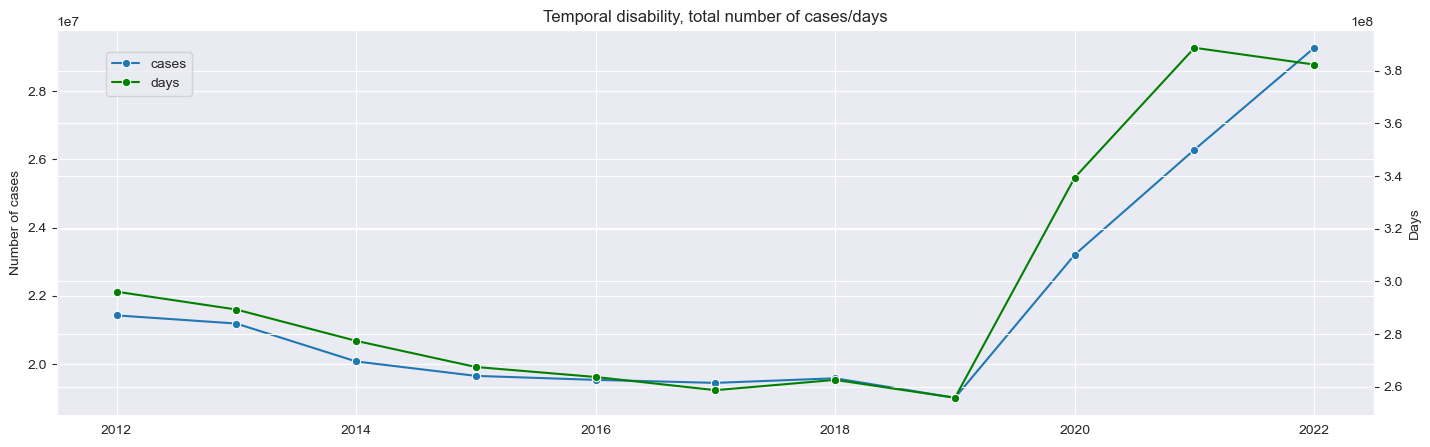

In [92]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_disability_long.query('disease_class=="total"'),
             x='year',
             y='disability_cases',
             label='cases', legend=False,
             marker='o')
plt.xlabel(None)
plt.ylabel('Number of cases')

ax2 = plt.twinx()
sns.lineplot(data=df_disability_long.query('disease_class=="total"'),
             x='year',
             y='disability_days',
             label='days', legend=False, 
             ax=ax2,
             marker='o', color='green')
plt.xlabel(None)
plt.ylabel('Days')

ax2.figure.legend(loc="upper left", bbox_to_anchor=(0.15, 0.85))
plt.title('Temporal disability, total number of cases/days')
plt.show()

Let's see which diseases make a greater contribution.

#### Number of cases

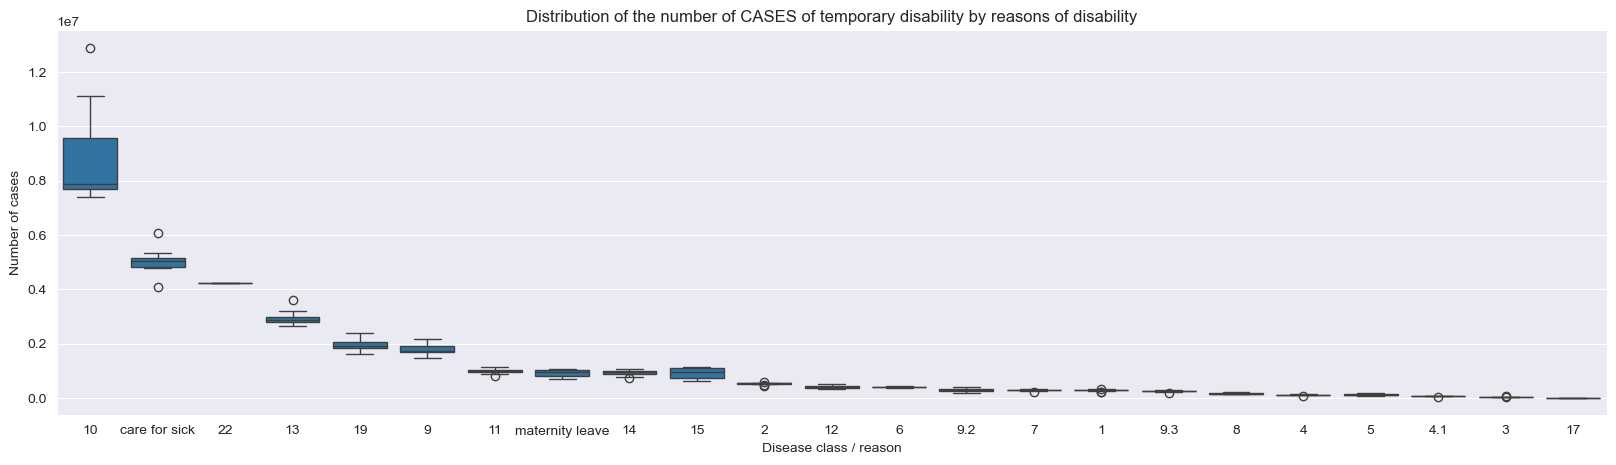

In [93]:
# boxplots

#calculate median cases by disease class
median_disease = df_disability_long.query('disease_class !="total"').groupby('disease_class')['disability_cases'].median().sort_values(ascending=False)

#create boxplots ordered by median number of cases
plt.figure(figsize=(20,5))
sns.boxplot(data=df_disability_long.query('disease_class !="total"'),
            x='disease_class',
            y='disability_cases',
            order=median_disease.index
           )

plt.title('Distribution of the number of CASES of temporary disability by reasons of disability')
plt.ylabel('Number of cases')
plt.xlabel('Disease class / reason')
plt.show()

Let's take a closer look at the dynamics of temporal disability by reasons of disability. Let's build different plots to visualize the data.

- **Respiratory diseases (10); leave to care for the sick (11); COVID-19 (22); diseases of the musculoskeletal system and connective tissue (13)**

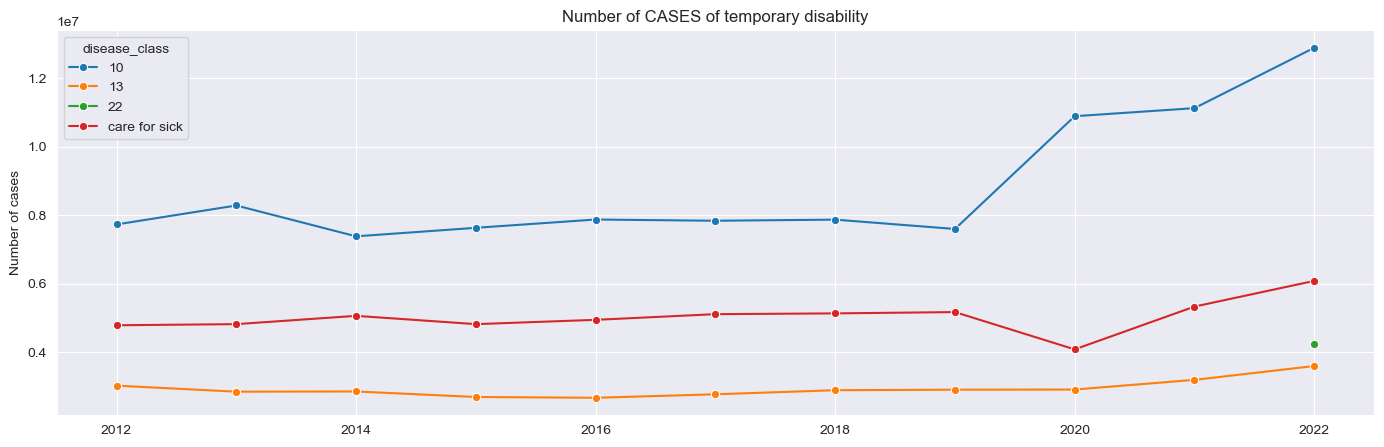

In [94]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(
    data=df_disability_long.query(
        'disease_class in ["10", "care for sick", "22", "13"]'),
    x='year',
    y='disability_cases',
    hue='disease_class',
    marker='o')

plt.title('Number of CASES of temporary disability')
plt.ylabel('Number of cases')
plt.xlabel(None)
plt.show()

- **Injuries (19); diseases of the circulatory system (9); digestive system (11), genitourinary system (14), pregnancy (15)**

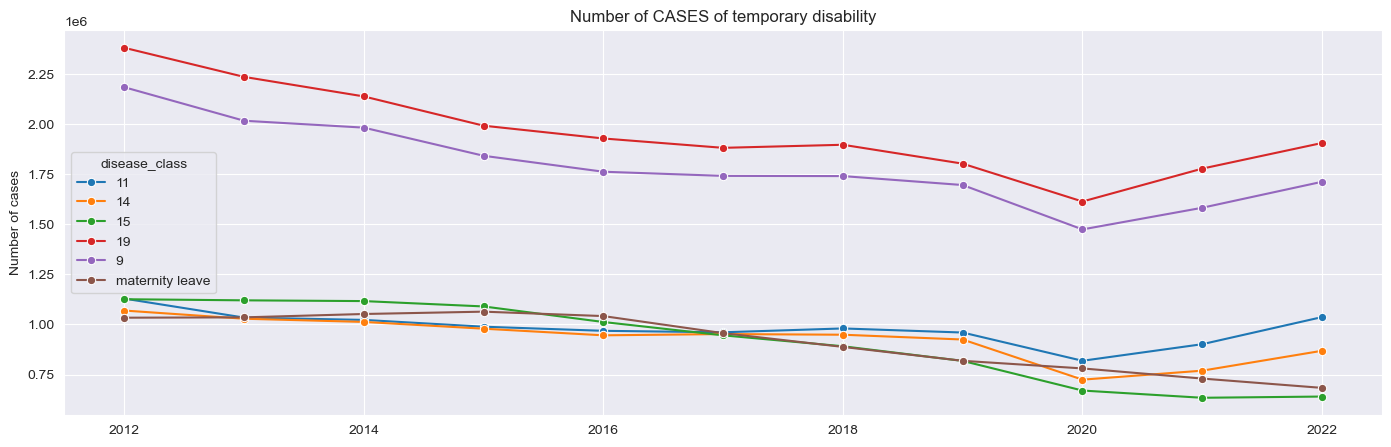

In [95]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(
    data=df_disability_long.query(
        'disease_class in ["19", "9", "11", "maternity leave", "14", "15"]'),
    x='year',
    y='disability_cases',
    hue='disease_class',
    marker='o')

plt.title('Number of CASES of temporary disability')
plt.ylabel('Number of cases')
plt.xlabel(None)
plt.show()

#### Number of days and duration

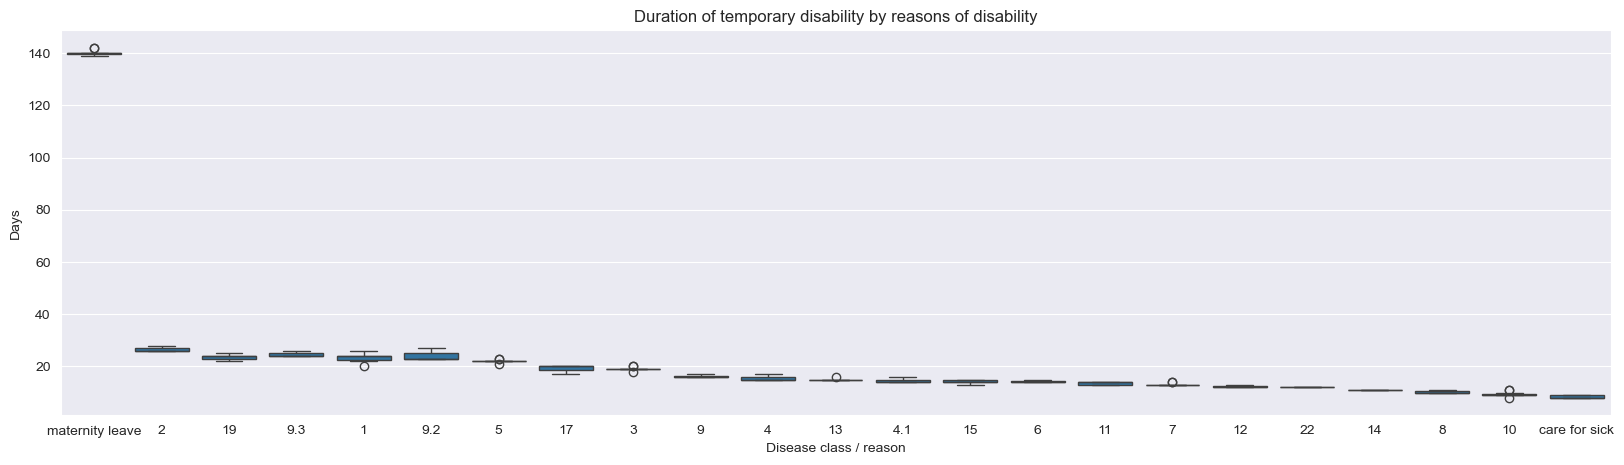

In [96]:
# boxplots

#calculate median cases by disease class
median_disease = df_disability_long.query('disease_class !="total"').groupby('disease_class')['disability_duration'].median().sort_values(ascending=False)

#create boxplots ordered by median number of cases
plt.figure(figsize=(20,5))
sns.boxplot(data=df_disability_long.query('disease_class !="total"'),
            x='disease_class',
            y='disability_duration',
            order=median_disease.index
           )

plt.title('Duration of temporary disability by reasons of disability')
plt.ylabel('Days')
plt.xlabel('Disease class / reason')
plt.show()

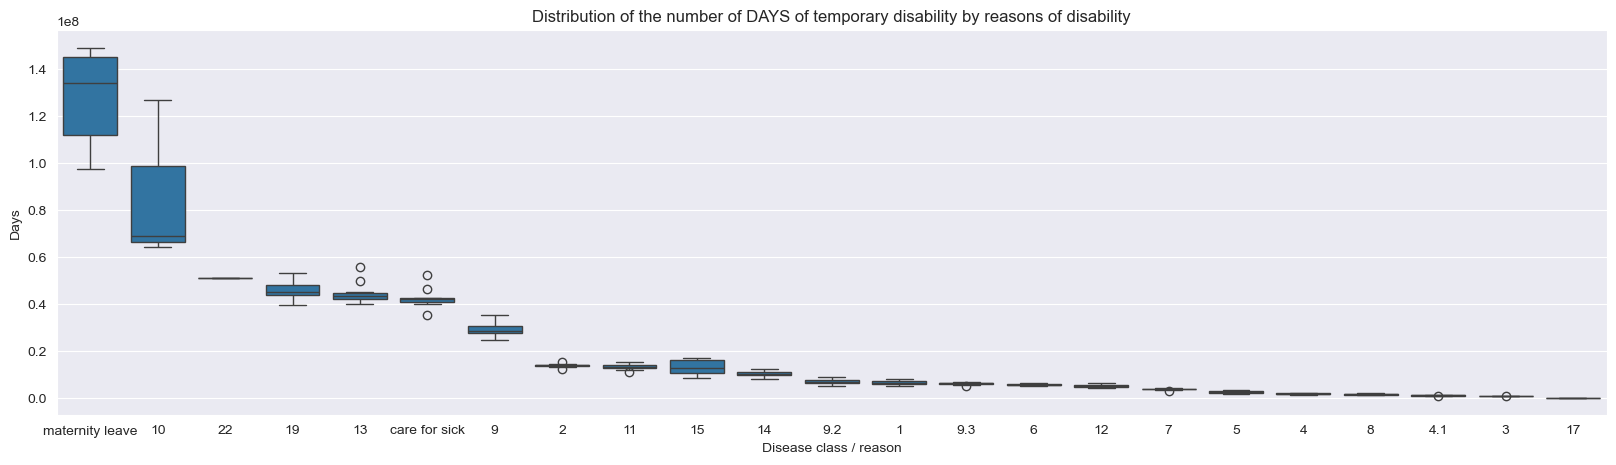

In [97]:
# boxplots

#calculate median cases by disease class
median_disease = df_disability_long.query('disease_class !="total"').groupby('disease_class')['disability_days'].median().sort_values(ascending=False)

#create boxplots ordered by median number of cases
plt.figure(figsize=(20,5))
sns.boxplot(data=df_disability_long.query('disease_class !="total"'),
            x='disease_class',
            y='disability_days',
            order=median_disease.index
           )

plt.title('Distribution of the number of DAYS of temporary disability by reasons of disability')
plt.ylabel('Days')
plt.xlabel('Disease class / reason')
plt.show()

Let's take a closer look at the dynamics of days of temporal disability by reasons of disability. Let's build different plots to visualize the data.

- **Respiratory diseases (10); COVID-19 (22); injuries (19)**

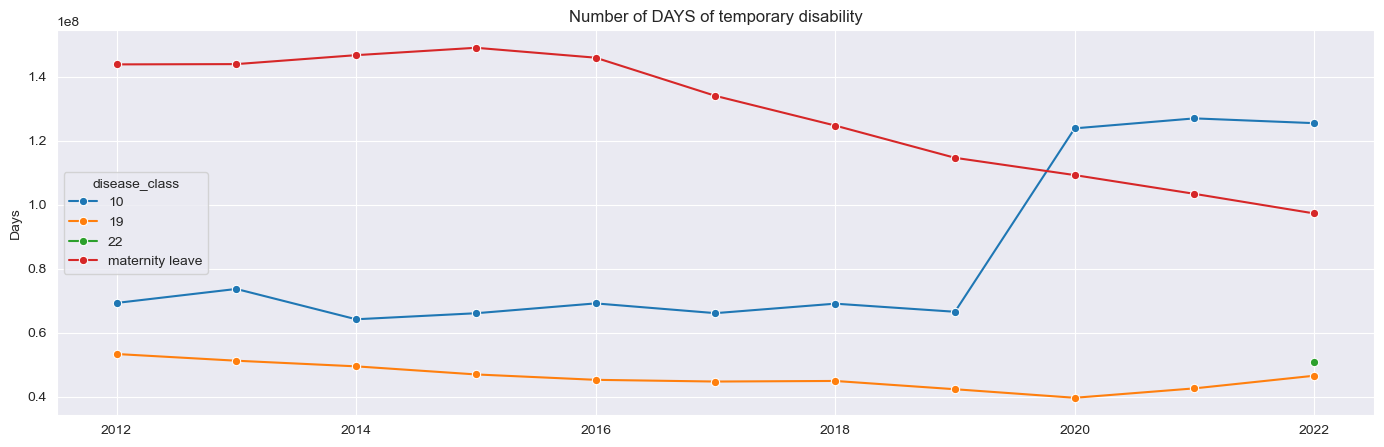

In [98]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_disability_long.query('disease_class in ["maternity leave", "10", "22", "19"]'),
                x='year',
                y='disability_days',
                hue='disease_class',
            marker='o')

plt.title('Number of DAYS of temporary disability')
plt.ylabel('Days')
plt.xlabel(None)
plt.show()

- **Diseases of the musculoskeletal system (13); circulatory system (9); digestive system (11); neoplasms (2); pregnancy (15)**

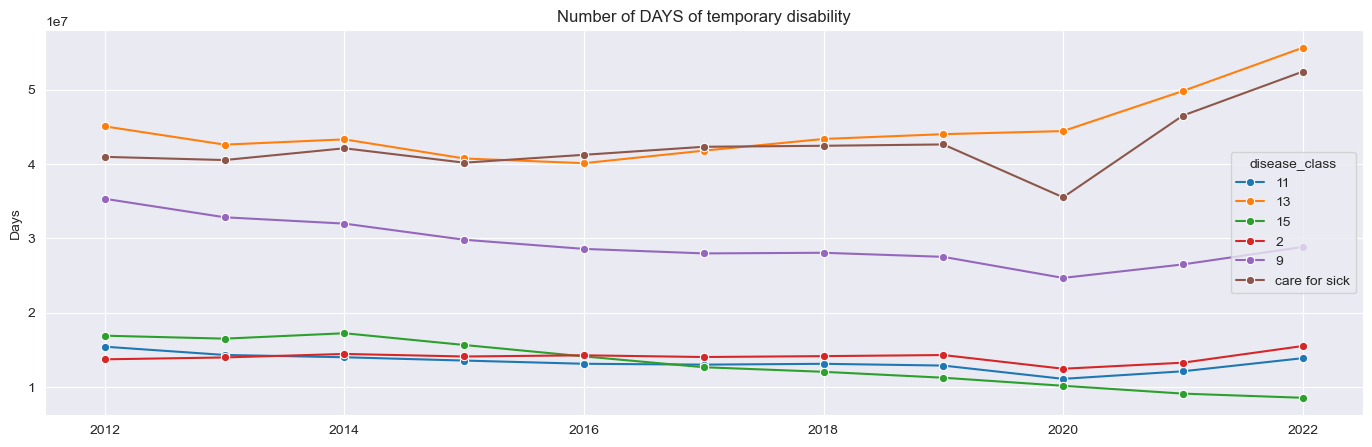

In [99]:
# scatterplot
plt.figure(figsize=(17,5))
sns.lineplot(data=df_disability_long.query('disease_class in ["13", "care for sick", "9", "2", "11", "15"]'),
                x='year',
                y='disability_days',
                hue='disease_class',
            marker='o')

plt.title('Number of DAYS of temporary disability')
plt.ylabel('Days')
plt.xlabel(None)
plt.show()

### Merge and Export DataFrames

Let's create merged DataFrame with previous data and save it as .csv file.

In [100]:
# merge data
disease_classes = disease_classes.merge(df_disability_long.drop(columns=['disability_duration']), 
                                        how='outer', on=['disease_class', 'year'])

# add names of disease classes
disease_classes['class_name'] = disease_classes.disease_class.map(icd_10).fillna(disease_classes['disease_class'])
disease_classes['class_name_short'] = disease_classes.disease_class.map(icd_10_short).fillna(disease_classes['disease_class'])

disease_classes

,disease_class,year,first_abs_all,first_per100k_all,total_abs_all,total_per100k_all,total_abs_1y,total_per100k_1y,total_abs_child,total_per100k_child,total_abs_teen,total_per100k_teen,disability_cases,disability_days,class_name,class_name_short
0,1,1990,5165.4,3492.2,7610.4,5145.2,NaN,NaN,3002.7,8841.6,NaN,NaN,NaN,NaN,Certain infectious and parasitic diseases,Infections
1,1,1995,6983.3,4725.7,9268.8,6272.3,127.9,104.4,3361.3,10717.6,268.2,4092.7,NaN,NaN,Certain infectious and parasitic diseases,Infections
2,1,1996,6399.1,4367.7,8843.9,6036.3,109.3,94.6,2790.0,9225.9,265.1,4031.5,NaN,NaN,Certain infectious and parasitic diseases,Infections
3,1,1997,6157.4,4213.4,8720.4,5967.3,102.1,87.4,2554.9,8723.6,269.2,4022.6,NaN,NaN,Certain infectious and parasitic diseases,Infections
4,1,1998,6414.7,4401.3,9021.1,6189.6,104.0,91.8,2718.6,9647.1,289.4,4188.1,NaN,NaN,Certain infectious and parasitic diseases,Infections
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,maternity leave,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,888044.0,1.2475e+08,Maternity leave,Maternity Leave
977,maternity leave,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,818639.0,1.1468e+08,Maternity leave,Maternity Leave
978,maternity leave,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780642.0,1.0928e+08,Maternity leave,Maternity Leave
979,maternity leave,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,730023.0,1.0341e+08,Maternity leave,Maternity Leave


In [101]:
# Saving dataframe to CSV file
disease_classes.to_csv('disease_classes.csv', index=False)

## Conclusions

The impact of the COVID-19 pandemic is clearly visible. Before the COVID-19 pandemic, the number of cases of temporary disability and its duration were decreasing. 

In terms of the **number of cases**, the main cause of temporary disability is respiratory diseases, followed by leave to care for the sick. Except for the pandemic period, their dynamics remained relatively unchanged. And the number of injuries and circulatory system diseases as causes of temporary disability decreased by about 20% from 2012 to 2016. It is worth noting that the number of maternity leaves has gradually decreased since 2016, and by 2022 it has decreased by about 30%.

People are out of work the longest due to maternity leave, averaging around 140 days, which is logical. Temporary disability caused by other classes of diseases lasts around 20 days, the shortest of all is leave to care for the sick (around 10 days). 

In terms of the total **number of days**, the main reason for temporary disability is maternity leave,followed by respiratory diseases. Other reasons, as a result of which the total number of days of temporary disability is high, include injuries, neoplasms, leave to care for the sick.

## Morbidity by regions of the Russian Federation

The data by region are presented as the incidence rate per 1,000 people  by major disease classes.

The incidence rate of the population is characterized by the number of cases where patients are diagnosed with a disease for the first time in their lives, identified during the year either when seeking medical care or during a preventive examination. The calculation of the incidence per 1,000 people is based on data from the Ministry of Health of the Russian Federation and is determined as the ratio of the number of patients with newly diagnosed diseases to the average annual population size.

> *For the years 2003-2009, the relative indicators calculated using population data were presented without considering the results of the 2010 All-Russian Census. For 2010, these indicators were calculated taking into account the preliminary results of the 2010 Census.*

### Data Load and Pre-Processing
For the years 1990-2012, regional data were published in analytical reports titled "Healthcare in Russia." Starting from 2013, these data have been published in separate analytical reports called "Regions of Russia. Socio-economic indicators," which is why the parsed data lacks this information. As a result, for the years 2010-2022, the data were obtained from [Moscow's unified data repository](https://ehd.moscow/index.php?show=inds&source=-9993)

In [102]:
class_dict = {'паразит': '1', 'новообр': '2',
             'крови': '3', 'эндокрин': '4', 
             'психич': '5', 'нервн': '6', 
             'глаз': '7', 'уха': '8',
             'кровообр': '9', 'дыхан': '10',
             'пищеварен': '11', 'кожи': '12',
             'костно': '13',
             'мочепол': '14', 'период': '15', 
             'аномалии': '17', 'травмы': '19',
             'VID-19': '22'}

#### Years 2010-2022 (data from Moscow's unified data repository)

The data consist of the .xlsx files, each containing the incidence rates for specific disease classes across different regions of the Russian Federation.

In [103]:
def read_table(filename):

    """
    Input: filename.
    Function reads the file, add the disease class numbers, 
    format region names.
    Output: DataFrame with regions, disease class numbers, and 
    incidence by year
    """
    
    if filename == '2_1_22.xlsx':
        header=[11]
    else:
        header=[15]
        
    df = pd.read_excel(os.path.join(*[PATH_data], 'reg_2010-2022', filename), header=header)
    df = df.rename(columns={df.columns[0]: 'region'})
    df.columns = df.columns.str.replace(' ', '')
    df['disease_class'] = re.search('(?<=2_1_)\w+', filename)[0]

    # format regions
    table = str.maketrans('acexopcyx', 'асехорсух')
    df['region'] = (df['region']
                    .str.lower()
                    .str.translate(table)
                    .str.replace('- ', '')
                    .str.replace(r'\(кроме[^)]*\)', '(без АО)', regex=True)
                   )
    
    return df

In [104]:
# creating list with filenames
pattern = r"2_1.*\.xlsx$"        # match all files ending with ".xlsx"
files = [f for f in os.listdir(PATH_data+'/reg_2010-2022') if re.search(pattern, f)]

In [105]:
# join all files into the one DataFrame
df_reg = pd.concat((read_table(filename) for filename in files), ignore_index=True)

In [106]:
df_reg.query("disease_class == '19'")

,region,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,disease_class
864,российская федерация,91.7,92.7,93.6,92.4,90.7,90.1,88.6,87.7,88.4,89.7,80.6,82.8,85.6,19
865,центральный федеральный округ,83.7,85.7,87.2,86.1,85.0,84.6,84.8,83.0,85.1,87.4,78.6,81.6,84.9,19
866,белгородская область,88.3,86.0,88.7,88.4,90.8,92.6,97.7,96.9,95.2,96.6,88.5,90.5,91.3,19
867,брянская область,91.7,101.0,110.9,109.0,106.7,98.6,101.3,98.3,94.7,95.0,95.1,100.9,101.7,19
868,владимирская область,100.0,93.0,100.6,94.6,94.9,98.9,102.7,96.0,97.3,100.2,94.9,101.1,99.1,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,амурская область,85.6,93.5,91.7,92.2,92.3,90.4,89.5,90.3,89.5,94.7,83.0,85.3,86.5,19
956,магаданская область,107.2,112.3,102.1,124.7,117.9,115.8,102.6,110.0,111.1,100.4,97.4,91.9,96.6,19
957,сахалинская область,71.6,65.1,64.8,55.5,62.2,74.1,72.5,59.7,48.9,39.8,38.2,43.0,91.8,19
958,еврейская автономная область,99.0,94.4,92.1,89.8,82.1,80.7,79.2,78.9,81.0,77.8,72.2,82.1,81.4,19


In [107]:
print('\033[1mNumber of missing values\033[0m')
df_reg.isna().sum()

Number of missing values


region             0
2010             128
2011             128
2012             128
2013             128
2014              96
2015              96
2016              96
2017              96
2018              96
2019              96
2020               0
2021               0
2022               0
disease_class      0
dtype: int64

In [108]:
df_reg[df_reg['2010'].isna()]

,region,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,disease_class
36,республика крым,NaN,NaN,NaN,NaN,23.1,12.6,15.1,16.1,20.7,18.6,13.2,14.2,17.0,11
41,г. севастополь,NaN,NaN,NaN,NaN,21.0,12.6,12.7,14.5,13.3,19.9,10.2,14.7,14.4,11
132,республика крым,NaN,NaN,NaN,NaN,64.1,18.8,18.0,19.6,20.6,18.2,14.3,16.1,18.2,1
137,г. севастополь,NaN,NaN,NaN,NaN,67.2,25.9,23.8,28.0,24.6,24.9,17.7,20.9,20.2,1
228,республика крым,NaN,NaN,NaN,NaN,436.4,235.8,234.1,221.0,221.4,231.8,231.3,252.4,287.2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1385,г. севастополь,NaN,NaN,NaN,NaN,35.8,21.9,22.4,23.1,22.5,22.1,18.6,22.3,21.8,13
1476,республика крым,NaN,NaN,NaN,NaN,92.0,26.7,29.2,25.3,26.2,27.8,22.8,23.5,22.8,12
1481,г. севастополь,NaN,NaN,NaN,NaN,89.1,42.0,34.8,37.2,43.0,40.6,29.0,35.2,40.6,12
1572,республика крым,NaN,NaN,NaN,NaN,4.2,2.0,2.0,2.0,1.9,2.0,1.6,1.5,1.9,3


In [109]:
df_reg[df_reg['2014'].isna()]

,region,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,disease_class
960,российская федерация,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.6,80.3,85.5,22
961,центральный федеральный округ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.6,87.3,85.4,22
962,белгородская область,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.5,66.5,54.5,22
963,брянская область,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.8,64.1,65.9,22
964,владимирская область,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.7,104.6,115.7,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,амурская область,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.9,73.0,80.8,22
1052,магаданская область,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.5,61.4,62.9,22
1053,сахалинская область,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.6,44.1,34.1,22
1054,еврейская автономная область,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,39.0,62.0,22


In [110]:
# convert the cleaned data to long format
df_reg_long = df_long_clean(df_reg, idvars=['region', 'disease_class'], pivot=False, start=3)
df_reg_long

,region,disease_class,year,cases
0,российская федерация,11,2010,33.4
1,центральный федеральный округ,11,2010,24.4
2,белгородская область,11,2010,33.6
3,брянская область,11,2010,54.7
4,владимирская область,11,2010,38.7
...,...,...,...,...
21211,амурская область,3,2022,3.6
21212,магаданская область,3,2022,3.4
21213,сахалинская область,3,2022,1.4
21214,еврейская автономная область,3,2022,2.0


In [111]:
# disease classes by year
df_reg_long.groupby("year").disease_class.unique()

year
2010    [11, 1, 10, 17, 6, total, 7, 4, 8, 19, 22, 9, 14, 2, 13, 12, 3]
2011    [11, 1, 10, 17, 6, total, 7, 4, 8, 19, 22, 9, 14, 2, 13, 12, 3]
2012    [11, 1, 10, 17, 6, total, 7, 4, 8, 19, 22, 9, 14, 2, 13, 12, 3]
2013    [11, 1, 10, 17, 6, total, 7, 4, 8, 19, 22, 9, 14, 2, 13, 12, 3]
2014    [11, 1, 10, 17, 6, total, 7, 4, 8, 19, 22, 9, 14, 2, 13, 12, 3]
2015    [11, 1, 10, 17, 6, total, 7, 4, 8, 19, 22, 9, 14, 2, 13, 12, 3]
2016    [11, 1, 10, 17, 6, total, 7, 4, 8, 19, 22, 9, 14, 2, 13, 12, 3]
2017    [11, 1, 10, 17, 6, total, 7, 4, 8, 19, 22, 9, 14, 2, 13, 12, 3]
2018    [11, 1, 10, 17, 6, total, 7, 4, 8, 19, 22, 9, 14, 2, 13, 12, 3]
2019    [11, 1, 10, 17, 6, total, 7, 4, 8, 19, 22, 9, 14, 2, 13, 12, 3]
2020    [11, 1, 10, 17, 6, total, 7, 4, 8, 19, 22, 9, 14, 2, 13, 12, 3]
2021    [11, 1, 10, 17, 6, total, 7, 4, 8, 19, 22, 9, 14, 2, 13, 12, 3]
2022    [11, 1, 10, 17, 6, total, 7, 4, 8, 19, 22, 9, 14, 2, 13, 12, 3]
Name: disease_class, dtype: object

Until 2014, there were no data for the Crimean Peninsula, and until 2020, there were no data on COVID-19. Since 2010, there has been no data on pregnancy complications ("Pregnancy, childbirth, and the puerperium", class 15).

#### Years 1990-2009 (data from Rosstat analytical reports "Healthcare in Russia")

- **Total cases**

In [112]:
def read_table(year, file_name='2_1_reg_total.csv', header = [1]):
    
    """
    Input: year, file_name, and header 
    - the row from which to take the column names.
    Function reads the file, formats the region names. 
    Output: DataFrame with region names and incidence by year. 
    """
    
    df = pd.read_csv(os.path.join(*[PATH_data], year, file_name), header = header, encoding='utf-8')
    df.columns = df.columns.astype(str)
    df = (df.rename(columns={df.columns[0]: 'region'})
            .dropna(subset=df.columns[1:], how='all'))
    
    # format regions
    table = str.maketrans('acexopcyx', 'асехорсух')
    df['region'] = (df['region']
                    .str.lower()
                    .str.translate(table)
                    .str.replace('- ', '')
                    .str.replace('в том числе ', '')
                   )
    return df

In [113]:
# create dict of dataframes
data = {}

for year in ['2001', '2005', '2007', '2009', '2011']:
    
    print('\033[1m'+year+'\033[0m')
    print('___________________')
    
    df = read_table(year)
    display(df.head())

    # add dataframe to the dict of dataframes
    data[year] = df

2001
___________________


,region,1992,1995,1996,1997,1998,1999,2000
0,российская федерация,615.6,678.8,648.5,674.2,670.4,710.0,735.7
1,центральный федеральный округ,603.2,676.9,636.6,673.8,677.6,725.1,734.6
2,белгородская область,556.1,609.1,574.7,611.5,605.9,658.6,757.4
3,брянская область,665.6,690.4,627.3,683.7,660.4,681.5,707.7
4,владимирская область,624.1,747.1,722.0,744.3,741.5,831.0,842.5


2005
___________________


,region,1995,2000,2001,2002,2003,2004
0,российская федерация,676.0,730.6,719.8,740.1,748.6,744.9
1,центральный федеральный округ,667.7,708.5,704.8,715.1,733.2,720.9
2,белгородская область,609.0,753.7,793.9,783.0,822.2,806.1
3,брянская область,693.6,715.5,715.8,713.7,699.5,741.8
4,владимирская область,753.5,858.4,889.9,929.2,935.0,920.9


2007
___________________


,region,1995,2000,2005,2006
0,российская федерация,676.0,730.6,745.9,763.9
1,центральный федеральный округ,667.7,708.5,706.5,718.3
2,белгородская область,609.0,753.7,780.1,783.5
3,брянская область,693.6,715.5,754.7,774.6
4,владимирская область,753.5,858.4,884.8,902.8


2009
___________________


,region,1995,2000,2005,2007,2008
0,российская федерация,676.0,730.6,745.9,771.0,772.0
1,центральный федеральный округ,667.7,708.5,706.5,722.8,726.9
2,белгородская область,609.0,753.7,780.1,798.6,755.5
3,брянская область,693.6,715.5,754.7,797.9,817.6
4,владимирская область,753.5,858.4,884.8,900.4,937.6


2011
___________________


,region,1995,2000,2005,2009,2010
0,российская федерация,676.0,730.6,745.9,802.5,779.6
1,центральный федеральный округ,667.7,708.5,706.5,760.2,719.0
2,белгородская область,609.0,753.7,780.1,780.0,756.7
3,брянская область,693.6,715.5,754.7,828.8,820.5
4,владимирская область,753.5,858.4,884.8,1009.9,925.8


In [114]:
# merge data
df_reg_total = (data['2001'].drop(columns=['1995', '2000'])
            .merge(data['2005'], how='outer', on=['region'])
            .merge(data['2007'].drop(columns=['1995', '2000']), how='outer', on=['region'])
            .merge(data['2009'].drop(columns=['1995', '2000', '2005']), how='outer', on=['region'])
            .merge(data['2011'].drop(columns=['1995', '2000', '2005', '2010']), how='outer', on=['region'])
         )

# add disease class
df_reg_total['disease_class'] = 'total'

In [115]:
df_reg_total[df_reg_total.isna().any(axis=1)]

,region,1992,1996,1997,1998,1999,1995,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,disease_class
57,пермская область,585.5,709.0,716.4,753.4,794.2,717.6,841.6,831.7,849.7,832.9,834.3,NaN,NaN,NaN,NaN,NaN,total
58,коми-пермяцкий автономный округ,...,...,...,...,...,...,689.2,...,729.4,821.9,830.9,NaN,NaN,NaN,NaN,NaN,total
66,ханты-мансийский автономный округ,...,...,...,...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,total
69,сибирский автономный округ,644.6,645.7,645.0,639.4,680.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,total
76,таймырский (долгано-ненецкий) автономный округ,...,...,...,...,...,...,832.1,...,981.0,987.2,946.0,934.6,927.8,NaN,NaN,NaN,total
77,эвенкийский автономный округ,...,...,...,...,...,...,790.7,...,966.0,894.7,710.0,689.5,678.4,NaN,NaN,NaN,total
79,усть-ордынский бурятский автономный округ,...,...,...,...,...,...,622.4,...,632.9,595.2,640.2,711.0,673.4,NaN,NaN,NaN,total
84,читинская область,512.3,561.1,510.8,533.6,517.8,610.5,593.5,611.2,681.2,675.7,620.3,637.3,659.5,NaN,NaN,NaN,total
85,агинский бурятский автономный округ,...,...,...,...,...,...,734.2,653.3,731.8,675.0,578.9,577.3,635.6,NaN,NaN,NaN,total
91,камчатская область,754.9,768.7,724.1,708.7,713.2,794.4,790.4,801.1,846.2,859.2,866.0,832.0,805.0,NaN,NaN,NaN,total


In [116]:
# convert the cleaned data to long format
df_reg_total_long = df_long_clean(df_reg_total, idvars=['region', 'disease_class'] , pivot=False, start=3)
df_reg_total_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648 entries, 0 to 1647
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   region         1648 non-null   object 
 1   disease_class  1648 non-null   object 
 2   year           1648 non-null   int64  
 3   cases          1462 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 51.6+ KB


- **Insidence by disease classes**

Some tables consisted of two parts, which were merged before loading the data.

In [117]:
def read_table(year, filename='2_1_reg.csv'):
    
    """
    Input: year, filename.
    Fгnction reads the file, formats the names of disease classes, 
    and replaces them with numbers, format region names,
    and add the column with year.
    Output: DataFrame with region names, incidence by disease classes, 
    and year.
    """
    
    df = pd.read_csv(os.path.join(*[PATH_data], year, filename), header = [0], encoding='utf-8')
    df = df[df.columns[~df.columns.str.contains('\.1')]]
    
    # format disease names
    table = str.maketrans('acexopcyx', 'асехорсух')
    df.columns = (df.columns.str.lower()
                  .str.translate(table)
                  .str.replace('- ', '')
                  .str.replace('-', ''))
    # change disease class names into numbers
    for k,v in class_dict.items():
        df.columns = np.where(df.columns.str.contains(k, case=False), v, df.columns)
    
    df = (df.rename(columns={df.columns[0]: 'region'})
            .dropna(subset=df.columns[1:], how='all')
            .reset_index(drop=True))
    
    # format regions
    table = str.maketrans('acexopcyx', 'асехорсух')
    df['region'] = (df['region']
                        .str.lower()
                        .str.translate(table)
                        .str.replace('- ', '')
                        .str.replace('в том числе ', ''))
    
    # add year as separate column and not row
    splits = df[df['region'].isna()].index
    df['year'] = np.nan
    for i in range(len(splits)):
        start_idx = splits[i]
        end_idx = splits[i + 1] if i + 1 < len(splits) else len(df)
        df.loc[start_idx:end_idx-1, 'year'] = re.search(r'\d{4}', df.iloc[start_idx, 1])[0]
    
    df = df.dropna(subset='region')
    
    return df

In [118]:
# create dict of dataframes
data = {}

data['1990'] = read_table('2001', filename='2_1_reg_1995,1998.csv')
print('\033[1m1990\033[0m')
print('___________________')
display(data['1990'].head())

for year in ['2001', '2005', '2007', '2009']:
    
    print('\033[1m'+year+'\033[0m')
    print('___________________')
    
    df = read_table(year)
    display(df.head())

    # add dataframe to the dict of dataframes
    data[year] = df

1990
___________________


,region,1,2,4,3,6,9,10,11,14,12,13,15,17,19,year
1,российская федерация,47.3,6.6,5.5,2.7,58.1,13.3,295.3,36.3,28.9,48.1,26.7,38.9,1.1,88.0,1995
2,центральный федеральный округ,42.7,7.3,5.8,1.9,55.6,13.3,331.2,21.8,25.9,41.9,26.5,31.5,1.0,82.0,1995
3,белгородская область,56.2,6.9,6.4,1.4,63.6,11.9,247.4,13.9,23.0,39.7,31.1,43.1,0.8,86.7,1995
4,брянская область,39.5,9.2,13.5,2.1,67.9,14.4,300.6,27.3,25.5,58.5,32.1,41.8,0.5,78.5,1995
5,владимирская область,43.4,7.7,5.5,2.5,73.8,14.4,352.9,25.4,34.2,46.8,34.7,20.2,1.0,88.7,1995


2001
___________________


,region,1,2,3,4,6,7,8,9,10,11,12,13,14,15,17,19,year
1,российская федерация,44.9,8.2,3.5,8.1,16.4,30.4,21.0,16.2,303.5,34.0,43.3,29.4,36.4,53.2,1.5,84.5,1999
2,центральный федеральный округ,43.2,9.1,2.2,7.3,14.3,29.8,21.3,16.4,341.1,24.1,41.3,30.8,34.4,40.7,1.3,83.0,1999
3,белгородская область,42.5,9.2,2.4,10,22.4,33.7,19.1,16.8,261.9,23.0,35.5,36.2,33.5,40.2,1.1,83.6,1999
4,брянская область,39.4,8,2.3,9.8,20.1,33.1,22.9,16.9,296.0,20.2,49.6,32.2,29.0,60.4,0.9,73.4,1999
5,владимирская область,48.5,11.3,3.1,6.7,20.1,35.4,29.8,18.3,378.9,29.7,53.3,39.0,47.0,21.6,1.3,87.8,1999


2005
___________________


,region,1,2,3,4,6,7,8,9,10,11,12,13,14,15,17,19,year
1,российская федерация,44.3,8.4,3.8,8.5,15.3,31.8,21.9,17.0,316.9,32.2,44.0,30.5,37.5,52.9,1.5,86.1,2000
2,центральный федеральный округ,39.5,9.1,2.2,7.4,13.4,29.8,21.3,16.5,331.9,23.5,41.7,30.9,34.5,38.9,1.2,81.3,2000
3,белгородская область,39.6,11.0,2.3,11.0,24.3,42.4,22.0,21.4,304.0,30.5,43.0,43.7,42.2,46.3,1.1,86.0,2000
4,брянская область,38.4,8.5,2.7,11.0,19.4,30.9,24.9,16.9,325.6,21.2,52.3,32.0,28.3,67.5,0.6,73.0,2000
5,владимирская область,50.4,11.0,3.1,8.7,20.2,38.8,30.2,19.3,389.5,26.5,60.2,42.9,49.8,17.6,1.2,87.4,2000


2007
___________________


,region,1,2,3,4,6,7,8,9,10,11,12,13,14,15,17,19,year
1,российская федерация,37.4,9.6,4.6,9.6,15.3,33.7,24.1,23.1,295.3,35.5,49.8,33.4,46.2,62.9,1.7,90.2,2005
2,центральный федеральный округ,32.5,9.5,2.0,8.1,13.0,30.3,22.6,21.3,312.2,25.6,45.8,32.6,41.5,46.6,1.3,81.7,2005
3,белгородская область,40.1,13.5,4.2,8.8,28.3,52.5,28.0,45.6,255.0,29.8,48.3,49.4,57.1,49.0,1.0,89.2,2005
4,брянская область,33.2,10.4,2.9,16.3,18.0,36.2,25.5,24.9,296.5,37.4,59.9,40.7,36.6,63.2,1.0,82.2,2005
5,владимирская область,42.4,11.7,3.2,9.7,16.8,40.9,31.5,19.7,394.0,30.6,65.4,45.1,59.1,39.9,1.4,88.3,2005


2009
___________________


,region,1,2,3,4,6,7,8,9,10,11,12,13,14,15,17,19,year
1,российская федерация,37.5,10.1,5.5,11.5,16.6,35.0,25.1,26.2,302.3,34.5,50.4,35.3,48.8,68.2,1.9,92.0,2007
2,центральный федеральный округ,32.1,10.0,2.1,9.4,13.1,31.0,23.7,23.0,316.1,25.2,46.7,34.3,43.4,51.5,1.4,83.3,2007
3,белгородская область,43.0,16.7,4.3,10.7,24.8,54.5,29.2,46.5,260.5,32.2,47.1,50.4,62.8,46.1,1.1,85.8,2007
4,брянская область,32.2,13.2,3.6,18.0,22.4,42.1,27.3,36.1,288.7,49.4,62.1,43.2,42.3,59.0,1.2,83.6,2007
5,владимирская область,44.3,12.7,3.1,12.7,19.8,44.8,33.4,25.3,368.0,38.5,63.2,50.0,68.3,49.0,2.4,87.2,2007


In [119]:
# years of data in each analytical report
for k in data.keys():
    print(k)
    print('----------')
    print(data[k].year.unique(),'\n')

1990
----------
['1995' '1998'] 

2001
----------
['1999' '2000'] 

2005
----------
['2000' '2003' '2004'] 

2007
----------
['2005' '2006'] 

2009
----------
['2007' '2008'] 



Data is not repeated, except for 2000 in the 2001 report.

In [120]:
# Exclusion of 2000 from the 2001 report
data['2001'] = data['2001'].loc[data['2001']['year']!='2000']

In [121]:
# convert the cleaned data to long format
for k in data.keys():
    data[k] = df_long_clean(data[k], idvars=['region', 'year'], varname='disease_class', pivot=False, start=3)
    display(data[k])

,region,year,disease_class,cases
0,российская федерация,1995,1,47.3
1,центральный федеральный округ,1995,1,42.7
2,белгородская область,1995,1,56.2
3,брянская область,1995,1,39.5
4,владимирская область,1995,1,43.4
...,...,...,...,...
2459,камчатская область,1998,19,71.9
2460,магаданская область,1998,19,93.8
2461,сахалинская область,1998,19,75.6
2462,еврейская автономная область,1998,19,79.0


,region,year,disease_class,cases
0,российская федерация,1999,1,44.9
1,центральный федеральный округ,1999,1,43.2
2,белгородская область,1999,1,42.5
3,брянская область,1999,1,39.4
4,владимирская область,1999,1,48.5
...,...,...,...,...
1403,камчатская область,1999,19,67.7
1404,магаданская область,1999,19,86.6
1405,сахалинская область,1999,19,76.9
1406,еврейская автономная область,1999,19,87.3


,region,year,disease_class,cases
0,российская федерация,2000,1,44.3
1,центральный федеральный округ,2000,1,39.5
2,белгородская область,2000,1,39.6
3,брянская область,2000,1,38.4
4,владимирская область,2000,1,50.4
...,...,...,...,...
4507,корякский автономный округ,2004,19,136.6
4508,магаданская область,2004,19,123.5
4509,сахалинская область,2004,19,81.5
4510,еврейская автономная область,2004,19,101.8


,region,year,disease_class,cases
0,российская федерация,2005,1,37.4
1,центральный федеральный округ,2005,1,32.5
2,белгородская область,2005,1,40.1
3,брянская область,2005,1,33.2
4,владимирская область,2005,1,42.4
...,...,...,...,...
3067,корякский автономный округ,2006,19,120.8
3068,магаданская область,2006,19,114.2
3069,сахалинская область,2006,19,81.9
3070,еврейская автономная область,2006,19,82.8


,region,year,disease_class,cases
0,российская федерация,2007,1,37.5
1,центральный федеральный округ,2007,1,32.1
2,белгородская область,2007,1,43.0
3,брянская область,2007,1,32.2
4,владимирская область,2007,1,44.3
...,...,...,...,...
2907,амурская область,2008,19,81.7
2908,магаданская область,2008,19,116.0
2909,сахалинская область,2008,19,74.4
2910,еврейская автономная область,2008,19,88.1


In [122]:
# concatenate tabels from different analytical reports
df_reg_diseases_long = pd.concat(data.values(), axis=0)

In [123]:
df_reg_diseases_long.year.unique()

array([1995, 1998, 1999, 2000, 2003, 2004, 2005, 2006, 2007, 2008])

### Merge and Export DataFrames

Let's create merged DataFrames for different years and save it as .csv file.

In [124]:
# concatenate "total cases" data with incidence by disease classes and data for 2010-2022
df_reg_full = pd.concat([df_reg_total_long, df_reg_diseases_long, df_reg_long], axis=0)
df_reg_full

,region,disease_class,year,cases
0,российская федерация,total,1992,615.6
1,центральный федеральный округ,total,1992,603.2
2,белгородская область,total,1992,556.1
3,брянская область,total,1992,665.6
4,владимирская область,total,1992,624.1
...,...,...,...,...
21211,амурская область,3,2022,3.6
21212,магаданская область,3,2022,3.4
21213,сахалинская область,3,2022,1.4
21214,еврейская автономная область,3,2022,2.0


In [125]:
df_reg_full.disease_class.unique()

array(['total', '1', '2', '4', '3', '6', '9', '10', '11', '14', '12',
       '13', '15', '17', '19', '7', '8', '22'], dtype=object)

- **Format region names**

In [126]:
df_reg_full.region.sort_values().unique()

array(['агинский бурятский автономный округ', 'алтайский край',
       'амурская область', 'архангельская область',
       'архангельская область (без АО)', 'астраханская область',
       'белгородская область', 'брянская область', 'владимирская область',
       'волгоградская область', 'вологодская область',
       'воронежская область', 'г. москва', 'г. санкт-петербург',
       'г. севастополь', 'г.москва', 'г.санкт-петербург',
       'дальневосточный федеральный округ',
       'еврейская автономная область', 'забайкальский край',
       'ивановская область', 'иркутская область',
       'кабардино-балкарская республика', 'калининградская область',
       'калужская область', 'камчатская область', 'камчатский край',
       'карачаево-черкесская республика', 'кемеровская область',
       'кировская область', 'коми-пермяцкий автономный округ',
       'комипермяцкий автономный округ', 'корякский автономный округ',
       'костромская область', 'краснодарский край', 'красноярский край',
 

In [127]:
# correct region names
df_reg_full['region'] = (df_reg_full['region'].str.replace('г. ', 'г.')
                         .str.replace('комипер', 'коми-пер')
                         .str.replace('долганоненец', 'долгано-ненец')
                         .str.replace(r'(ханты-мансийский автономный округ)(.*югра)?', r'\1-югра', regex=True)
                         .str.replace('сибирский автономный округ', 'сибирский федеральный округ')
                        )

In [128]:
regions_translation = {
    'агинский бурятский автономный округ': 'Agin-Buryat Autonomous Okrug',
    'алтайский край': 'Altai Krai',
    'амурская область': 'Amur Oblast',
    'архангельская область': 'Arkhangelsk Oblast (with AO)',
    'архангельская область (без АО)': 'Arkhangelsk Oblast',
    'астраханская область': 'Astrakhan Oblast',
    'белгородская область': 'Belgorod Oblast',
    'брянская область': 'Bryansk Oblast',
    'владимирская область': 'Vladimir Oblast',
    'волгоградская область': 'Volgograd Oblast',
    'вологодская область': 'Vologda Oblast',
    'воронежская область': 'Voronezh Oblast',
    'г.москва': 'Moscow',
    'г.санкт-петербург': 'Saint Petersburg',
    'г.севастополь': 'Sevastopol',
    'дальневосточный федеральный округ': 'Far Eastern Federal District',
    'еврейская автономная область': 'Jewish Autonomous Oblast',
    'забайкальский край': 'Zabaykalsky Krai',
    'ивановская область': 'Ivanovo Oblast',
    'иркутская область': 'Irkutsk Oblast',
    'кабардино-балкарская республика': 'Kabardino-Balkarian Republic',
    'калининградская область': 'Kaliningrad Oblast',
    'калужская область': 'Kaluga Oblast',
    'камчатская область': 'Kamchatka Oblast',
    'камчатский край': 'Kamchatka Krai',
    'карачаево-черкесская республика': 'Karachay-Cherkess Republic',
    'кемеровская область': 'Kemerovo Oblast',
    'кировская область': 'Kirov Oblast',
    'коми-пермяцкий автономный округ': 'Komi-Permyak Autonomous Okrug',
    'корякский автономный округ': 'Koryak Autonomous Okrug',
    'костромская область': 'Kostroma Oblast',
    'краснодарский край': 'Krasnodar Krai',
    'красноярский край': 'Krasnoyarsk Krai',
    'курганская область': 'Kurgan Oblast',
    'курская область': 'Kursk Oblast',
    'ленинградская область': 'Leningrad Oblast',
    'липецкая область': 'Lipetsk Oblast',
    'магаданская область': 'Magadan Oblast',
    'московская область': 'Moscow Oblast',
    'мурманская область': 'Murmansk Oblast',
    'ненецкий автономный округ': 'Nenets Autonomous Okrug',
    'нижегородская область': 'Nizhny Novgorod Oblast',
    'новгородская область': 'Novgorod Oblast',
    'новосибирская область': 'Novosibirsk Oblast',
    'омская область': 'Omsk Oblast',
    'оренбургская область': 'Orenburg Oblast',
    'орловская область': 'Oryol Oblast',
    'пензенская область': 'Penza Oblast',
    'пермская область': 'Perm Oblast',
    'пермский край': 'Perm Krai',
    'приволжский федеральный округ': 'Volga Federal District',
    'приморский край': 'Primorsky Krai',
    'псковская область': 'Pskov Oblast',
    'республика адыгея': 'Republic of Adygea',
    'республика алтай': 'Altai Republic',
    'республика башкортостан': 'Republic of Bashkortostan',
    'республика бурятия': 'Republic of Buryatia',
    'республика дагестан': 'Republic of Dagestan',
    'республика ингушетия': 'Republic of Ingushetia',
    'республика калмыкия': 'Republic of Kalmykia',
    'республика карелия': 'Republic of Karelia',
    'республика коми': 'Komi Republic',
    'республика крым': 'Republic of Crimea',
    'республика марий эл': 'Mari El Republic',
    'республика мордовия': 'Republic of Mordovia',
    'республика саха (якутия)': 'Sakha Republic (Yakutia)',
    'республика северная осетия алания': 'Republic of North Ossetia-Alania',
    'республика татарстан': 'Republic of Tatarstan',
    'республика тыва': 'Republic of Tuva',
    'республика хакасия': 'Republic of Khakassia',
    'российская федерация': 'Russian Federation',
    'ростовская область': 'Rostov Oblast',
    'рязанская область': 'Ryazan Oblast',
    'самарская область': 'Samara Oblast',
    'саратовская область': 'Saratov Oblast',
    'сахалинская область': 'Sakhalin Oblast',
    'свердловская область': 'Sverdlovsk Oblast',
    'северо-западный федеральный округ': 'Northwestern Federal District',
    'северо-кавказский федеральный округ': 'North Caucasian Federal District',
    'сибирский федеральный округ': 'Siberian Federal District',
    'смоленская область': 'Smolensk Oblast',
    'ставропольский край': 'Stavropol Krai',
    'таймырский (долгано-ненецкий) автономный округ': 'Taimyr (Dolgan-Nenets) Autonomous Okrug',
    'тамбовская область': 'Tambov Oblast',
    'тверская область': 'Tver Oblast',
    'томская область': 'Tomsk Oblast',
    'тульская область': 'Tula Oblast',
    'тюменская область': 'Tyumen Oblast (with AO)',
    'тюменская область (без АО)': 'Tyumen Oblast',
    'удмуртская республика': 'Udmurt Republic',
    'ульяновская область': 'Ulyanovsk Oblast',
    'уральский федеральный округ': 'Ural Federal District',
    'усть-ордынский бурятский автономный округ': 'Ust-Orda Buryat Autonomous Okrug',
    'хабаровский край': 'Khabarovsk Krai',
    'ханты-мансийский автономный округ-югра': 'Khanty-Mansi Autonomous Okrug-Yugra',
    'центральный федеральный округ': 'Central Federal District',
    'челябинская область': 'Chelyabinsk Oblast',
    'чеченская республика': 'Chechen Republic',
    'читинская область': 'Chita Oblast',
    'чувашская республика': 'Chuvash Republic',
    'чукотский автономный округ': 'Chukotka Autonomous Okrug',
    'эвенкийский автономный округ': 'Evenk Autonomous Okrug',
    'южный федеральный округ': 'Southern Federal District',
    'ямало-ненецкий автономный округ': 'Yamalo-Nenets Autonomous Okrug',
    'ярославская область': 'Yaroslavl Oblast'
}

In [129]:
# translate region names into English
df_reg_full['region_eng'] = df_reg_full.region.map(regions_translation).fillna(df_reg_full['region'])
df_reg_full

,region,disease_class,year,cases,region_eng
0,российская федерация,total,1992,615.6,Russian Federation
1,центральный федеральный округ,total,1992,603.2,Central Federal District
2,белгородская область,total,1992,556.1,Belgorod Oblast
3,брянская область,total,1992,665.6,Bryansk Oblast
4,владимирская область,total,1992,624.1,Vladimir Oblast
...,...,...,...,...,...
21211,амурская область,3,2022,3.6,Amur Oblast
21212,магаданская область,3,2022,3.4,Magadan Oblast
21213,сахалинская область,3,2022,1.4,Sakhalin Oblast
21214,еврейская автономная область,3,2022,2.0,Jewish Autonomous Oblast


In [130]:
# add names of disease classes
df_reg_full['class_name'] = df_reg_full.disease_class.map(icd_10).fillna(df_reg_full['disease_class'])
df_reg_full['class_name_short'] = df_reg_full.disease_class.map(icd_10_short).fillna(df_reg_full['disease_class'])

df_reg_full

,region,disease_class,year,cases,region_eng,class_name,class_name_short
0,российская федерация,total,1992,615.6,Russian Federation,total,total
1,центральный федеральный округ,total,1992,603.2,Central Federal District,total,total
2,белгородская область,total,1992,556.1,Belgorod Oblast,total,total
3,брянская область,total,1992,665.6,Bryansk Oblast,total,total
4,владимирская область,total,1992,624.1,Vladimir Oblast,total,total
...,...,...,...,...,...,...,...
21211,амурская область,3,2022,3.6,Amur Oblast,"Diseases of the blood, blood-forming organs, and certain disorders involving the immune mechanism",Blood & Immune Diseases
21212,магаданская область,3,2022,3.4,Magadan Oblast,"Diseases of the blood, blood-forming organs, and certain disorders involving the immune mechanism",Blood & Immune Diseases
21213,сахалинская область,3,2022,1.4,Sakhalin Oblast,"Diseases of the blood, blood-forming organs, and certain disorders involving the immune mechanism",Blood & Immune Diseases
21214,еврейская автономная область,3,2022,2.0,Jewish Autonomous Oblast,"Diseases of the blood, blood-forming organs, and certain disorders involving the immune mechanism",Blood & Immune Diseases


In [131]:
df_reg_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37232 entries, 0 to 21215
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   region            37232 non-null  object 
 1   disease_class     37232 non-null  object 
 2   year              37232 non-null  int64  
 3   cases             35848 non-null  float64
 4   region_eng        37232 non-null  object 
 5   class_name        37232 non-null  object 
 6   class_name_short  37232 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 2.3+ MB


In [132]:
# save dataframe to .csv file
df_reg_full.to_csv('disease_classes_regions.csv', index=False)

### EDA

The exploratory data analysis (EDA) for this part of the data can be performed directly in the created dashboard.